# Premier League Engine: One vs Rest (OVR) Binary Classification for Win Model

In [1]:
# Importing Dependencies
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.feature_selection import RFECV, SelectFpr, SelectFromModel, SelectPercentile, SequentialFeatureSelector
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, StandardScaler, OrdinalEncoder
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.svm import SVC

from catboost import CatBoostClassifier
from IPython.core.display import HTML
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from boruta import BorutaPy

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import logging
import shutil
import skopt
import yaml
import os

In [2]:
logging.basicConfig(filename = '/Users/kzeynalzade/Documents/Project/Logs/win_modeling.log', filemode = 'w', format = '%(asctime)s - %(levelname)s - %(message)s', level = logging.INFO)
display(HTML('<style>.container{width:100% !important;}<style>'))
sns.set(font_scale = 1.5, style = 'darkgrid', palette = 'bright')
warnings.filterwarnings(action = 'ignore')
plt.rcParams['figure.figsize'] = (30, 10)
pd.options.display.max_columns = None
set_config(display = 'diagram')
np.random.seed(seed = 42)

Let's define a function to load a yaml file.

In [3]:
# Defining a function to load a yaml file
def load_yaml(filepath = None):
    """
    This is a function that will load a yaml file.
    
    Args:
        filepath: A path to a yaml file.
        
    Returns:
        A dictionary object.
    """
    # Loading the yaml file
    with open(file = filepath) as yaml_file:
        config = yaml.safe_load(stream = yaml_file)
    
    # Returning the yaml file
    return config

Let's load the yaml file and create global variables for batch model features and split date.

In [4]:
# Loading model properties from a yaml file
CONFIG = load_yaml(filepath = '/Users/kzeynalzade/Documents/Project/Configuration/config.yml')

# Creating a path to datasets
TARGET_PATH = '/Users/kzeynalzade/Documents/Project/Data/Converted data'

# Loading features for a batch model from model properties
FEATURES = CONFIG.get('features').get('batch_model_features')

# Extracting the season that will be used for out of time (OOT) test set
TEST_SEASON = CONFIG.get('test_split').get('test_season')

# Loading the dependent variable for Win modeling
TARGET = CONFIG.get('target').get('win_model')

# Loading the current season
CURRENT_SEASON = CONFIG.get('current_season')

Let's define a function to load the dataset.

In [5]:
# Defining a function to load the dataset
def load_data(target_path = None, non_na_ratio = 0.6):
    """
    This is a function that is used to load datasets from a specified path and create a cohesive dataset.
    
    Args:
        target_path: A path for the datasets.
        non_na_ratio: A non na ratio for variables.
        
    Returns:
        A pandas data frame.
    """
    # Creating a list of datasets based on the specified path
    datasets = [f'{target_path}/{file}' for file in os.listdir(path = target_path) if file.endswith('.brotli')]
    
    # Loading the datasets using list comprehension
    data_frames = [pd.read_parquet(path = dataset, engine = 'fastparquet') for dataset in datasets]
    
    # Concatenating data frames to create a cohesive data frame
    data_frame = pd.concat(objs = data_frames, ignore_index = True)
    
    # Casting the data type of the match date variable from object to datetime
    data_frame.match_date = pd.to_datetime(arg = data_frame.match_date, yearfirst = True)
    
    # Sorting the observations based on match_date variable in ascending order
    data_frame.sort_values(by = 'match_date', inplace = True)
    
    # Reseting the index to maintain index order
    data_frame.reset_index(drop = True, inplace = True)
    
    # Removing potential duplicate observations
    data_frame.drop_duplicates(inplace = True, ignore_index = True)
    
    # Dropping features that exceed non na ratio
    data_frame.dropna(axis = 1, thresh = int(data_frame.shape[0] * non_na_ratio), inplace = True)
    
    # Returning the data frame
    return data_frame

Let's call the function to load the dataset.

In [6]:
# Calling the function to load the dataset
df = load_data(target_path = TARGET_PATH)

# Filtering out the data of current season
df = df.loc[df.season != CURRENT_SEASON].sort_values(by = 'match_date').reset_index(drop = True)

# Logging information to the log file
logging.info(msg = 'Data has been loaded')

# Displaying the first five records of the dataset
df.head()

season  match_week match_date  month  day  weekday        referee  \
0  2016/17           1 2016-08-13      8   13        6   Kevin Friend   
1  2016/17           1 2016-08-13      8   13        6      Mike Dean   
2  2016/17           1 2016-08-13      8   13        6  Jonathan Moss   
3  2016/17           1 2016-08-13      8   13        6   Craig Pawson   
4  2016/17           1 2016-08-13      8   13        6  Robert Madley   

        home_team   away_team            stadium  attendance  h_position  \
0   Middlesbrough       Stoke  Riverside Stadium     32110.0          12   
1            Hull   Leicester       KCOM Stadium     21037.0           7   
2         Burnley     Swansea          Turf Moor     19126.0           3   
3  Crystal Palace   West Brom      Selhurst Park     24490.0           5   
4        Man City  Sunderland     Etihad Stadium     54362.0          10   

   a_position  goals_h  goals_a  possession_h  possession_a  \
0          15        1        1          45.6          54.4   
1           8        2        1          49.7          50.3   
2          17        0        1          47.5          52.5   
3          19        0        1          62.3          37.7   
4          16        2        1          76.9          23.1   

   shots_on_target_h  shots_on_target_a  shots_h  shots_a  touches_h  \
0                  2                  1       12       12        538   
1                  5                  5       14       18        645   
2                  3                  9       10       17        558   
3                  4                  3       14       13        620   
4                  4                  3       16        7        864   

   touches_a  passes_h  passes_a  tackles_h  tackles_a  clearances_h  \
0        611       349       420         17         16            20   
1        619       449       453         20         14            29   
2        613       353       383         14         19            16   
3        476       414       245         28         18            21   
4        395       681       189          5         17            26   

   clearances_a  corners_h  corners_a  offsides_h  offsides_a  yellow_cards_h  \
0            16          9          6           1           2               3   
1            15          5          3           1           0               2   
2            49          7          4           3           2               3   
3            23          3          6           0           2               2   
4            35          9          6           1           2               1   

   yellow_cards_a  red_cards_h  red_cards_a  fouls_conceded_h  \
0               5            0            0                18   
1               2            0            0                 8   
2               2            0            0                10   
3               2            0            0                12   
4               2            0            0                11   

   fouls_conceded_a formation_h formation_a result_h result_a  points_h  \
0                14     4-2-3-1     4-2-3-1     draw     draw         1   
1                17       4-3-3       4-4-2      win   defeat         3   
2                14       4-4-2       4-3-3   defeat      win         0   
3                15     4-2-3-1       4-4-2   defeat      win         0   
4                14     4-2-3-1     4-2-3-1      win   defeat         3   

   points_a  total_n_matches_played_h  total_n_matches_played_a  \
0         1                         0                         0   
1         0                         0                         0   
2         3                         0                         0   
3         3                         0                         0   
4         0                         0                         0   

   total_max_points_h  total_max_points_a  total_points_h_cum  \
0                   0                   0                   0   
1

Let's define a custom preprocessor that reallocates features.

In [7]:
# Defining a custom transformer to reallocate variables
class FeatureReallocator(BaseEstimator, TransformerMixin):
    # Defining a function for fitting data to custom transformer
    def fit(self, X, y = None):
        # Creating a list of binary features
        binary_features = [feature for feature in FEATURES if X[feature].nunique() == 2]

        # Creating a list of date features
        date_features = ['match_week', 'month', 'day', 'weekday']

        # Creating a list of ordinal features
        ordinal_features = ['h_position', 'a_position']

        # Creating a list of numeric features
        left_out_features = [feature for feature in X.columns.tolist() if feature not in binary_features + date_features + ordinal_features]

        # Creating a list of reallocated features
        reallocated_features = date_features + ordinal_features + left_out_features + binary_features
        
        # Defining the list for feature reallocation
        self.reallocated_features = reallocated_features
        
        # Defining the list for ordinal features
        self.ordinal_features = ordinal_features
        
        # Returning the fitted and transformed data
        return self
    
    # Defining a function for transforming data with custom transformer
    def transform(self, X, y = None):
        # Reallocating variables
        X = X[[feature for feature in self.reallocated_features if feature in FEATURES]]
        
        # Converting the values of ordinal variables into string
        X[self.ordinal_features] = X[self.ordinal_features].applymap(func = lambda x: str(x))
        
        # Returning the transformed data
        return X

Let's define a customer preprocessor that drops features with high **VIF** values.

In [8]:
# Defining a custom transformer to remove multicollinearity
class VifDropper(BaseEstimator, TransformerMixin):
    # Initializing the default threshold for variance inflation factor (VIF)
    def __init__(self, threshold = 2.5):
        # Default VIF threshold
        self.threshold = threshold

    # Defining a function for fitting data to custom transformer
    def fit(self, X, y = None):
        # Creating a copy of a Numpy array as Pandas dataframe
        data = pd.DataFrame(data = X).copy()
        
        # Creating a Pandas dataframe
        vif_df = pd.DataFrame()
        
        # Assigning the names of columns to a feature variable
        vif_df['feature'] = data.columns
        
        # Calculating VIF values
        vif_df['VIF'] = [VIF(exog = data.values, exog_idx = i) for i in range(len(data.columns))]
        
        # Creating an empty list
        features_with_max_vif = []
        
        # Calculating VIF values of variables based on default threshold
        while vif_df.VIF.max() > self.threshold:
            feature_with_max_vif = vif_df.loc[vif_df.VIF == vif_df.VIF.max()].feature.values[0]
            data.drop(columns = feature_with_max_vif, inplace = True)
            features_with_max_vif.append(feature_with_max_vif)
 
            vif_df = pd.DataFrame()
            vif_df['feature'] = data.columns
            vif_df['VIF'] = [VIF(exog = data.values, exog_idx = i) for i in range(len(data.columns))]
        
        # Defining the list of variables with maximum VIF values
        self.features_with_max_vif = features_with_max_vif
        
        # Returning the fitted and transformed data
        return self 
    
    # Defining a function for transforming data with custom transformer
    def transform(self, X, y = None):
        # Returning the transformed data
        return pd.DataFrame(data = X).drop(columns = self.features_with_max_vif).values

Let's define a function to split data into train and a test set.

In [9]:
# Defining a function to split data into train and test set based on time dimension
def train_test_split(data_frame = None, 
                     test_season = None, 
                     target = None):
    """
    This function is used to split data into train & test sets.
    
    Args:
        data_frame: A pandas data frame.
        test_season: A season which will be used as out of time (OOT) test set.
        target: A dependent variable.
        
    Returns:
        Features and labels for train & test set.
    """
    # Identifying the first match date in the test season
    split_date = str(data_frame.loc[data_frame.season == test_season, 'match_date'].min()).split()[0]
    
    # Creating train & test sets
    train_set = data_frame.loc[data_frame.match_date < split_date].reset_index(drop = True)
    test_set = data_frame.loc[data_frame.match_date >= split_date].reset_index(drop = True)
    
    # Creating features for train & test set
    X_train = train_set.drop(columns = target)
    X_test = test_set.drop(columns = target)
    
    # Creating labels for train & test set
    y_train = train_set[target]
    y_test = test_set[target]
    
    # Returning train & test features and labels
    return X_train, X_test, y_train, y_test

Let's split the data into a train and a test set.

In [10]:
# Splitting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(data_frame = df, 
                                                    test_season = TEST_SEASON, 
                                                    target = TARGET)

# Logging information to the log file
logging.info(msg = 'Train and test set has been created')

# Displaying the shapes of features and labels for train & test set
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1900, 236), (1900,), (380, 236), (380,))

Let's visualize the class ratio for train and test sets.

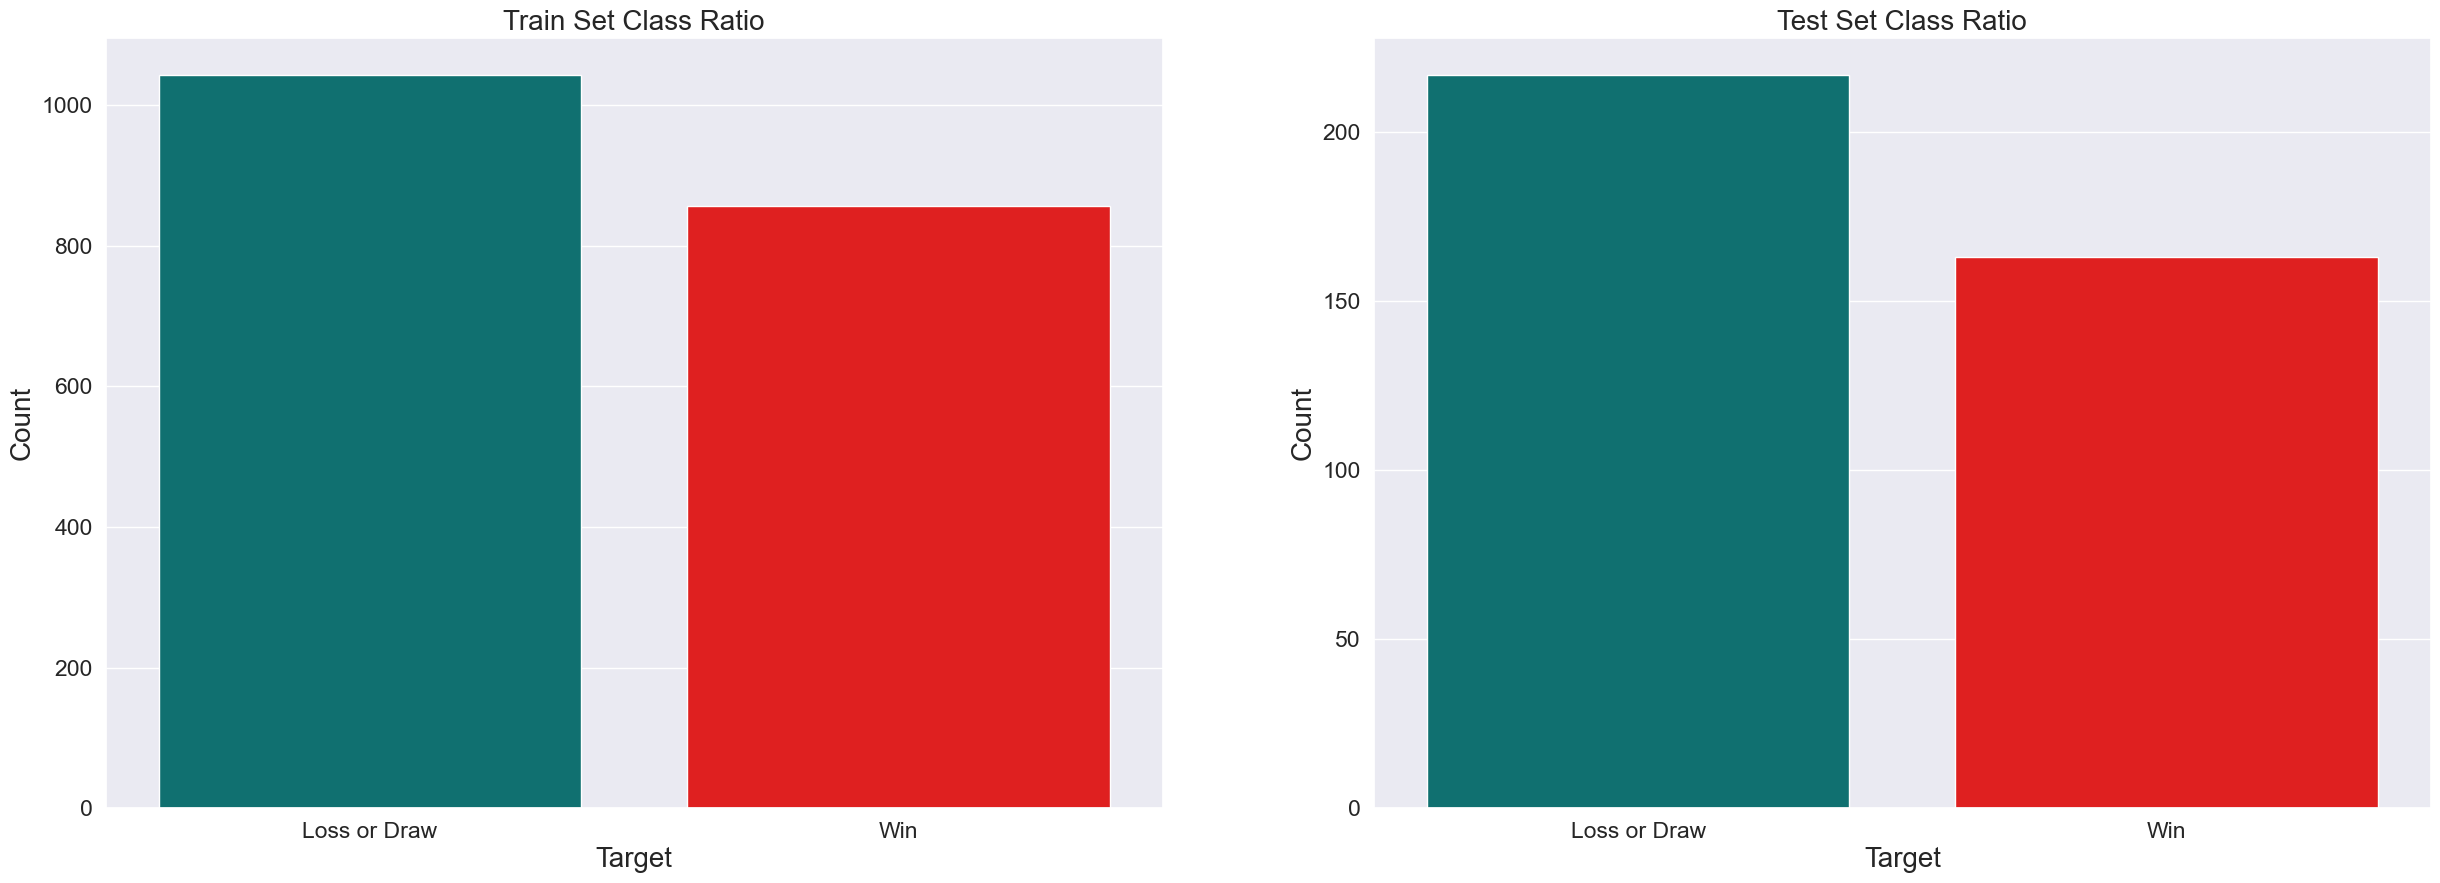

In [11]:
# Visualizing the class ratio for train set
plt.subplot(1, 2, 1)
sns.countplot(x = y_train, palette = ['teal', 'red'])
plt.title(label = 'Train Set Class Ratio', fontsize = 20)
plt.xlabel(xlabel = 'Target', fontsize = 20)
plt.ylabel(ylabel = 'Count', fontsize = 20)
plt.xticks(ticks = [0, 1], labels = ['Loss or Draw', 'Win'])

# Visualizing the class ratio for test set
plt.subplot(1, 2, 2)
sns.countplot(x = y_test, palette = ['teal', 'red'])
plt.title(label = 'Test Set Class Ratio', fontsize = 20)
plt.xlabel(xlabel = 'Target', fontsize = 20)
plt.ylabel(ylabel = 'Count', fontsize = 20)
plt.xticks(ticks = [0, 1], labels = ['Loss or Draw', 'Win'])
plt.show()

***
## Modeling
#### Gaussian Naïve Bayes

Let's define a function to build a classifier pipeline.

In [12]:
# Defining a function to build a classifier pipeline
def build_pipeline(classifier = None, 
                   metric = 'balanced_accuracy', 
                   data_frame = None, 
                   train_features = None, 
                   train_labels = None, 
                   apply_bayesian_optimization = True, 
                   hyperparameters = None, 
                   n_iterations = 50, 
                   scale = True, 
                   scaler_type = None,
                   drop_high_vif_features = True, 
                   apply_feature_selection = True, 
                   feature_selection_method = None, 
                   verbosity = 0):
    """
    This function is used to build a classifier pipeline.
    
    Args:
        classifier: A classifier instance.
        metric: A classification metric based on which to optimize a model.
        data_frame: A pandas data frame
        train_features: Train features.
        train_labels: Train labels.
        apply_bayesian_optimization: Whether or not to apply Bayesian Optimization to find the best hyper parameters.
        hyperparameters: A dictionary of hyperparameters.
        n_iterations: The number of repetitions for a hyperparameter tuning technique.
        scale: Whether or not to apply feature scaling.
        scaler_type: A type of a feature scaler instance as a string.
        drop_high_vif_features: Whether or not to drop features with high variance inflation factor (VIF) value.
        apply_feature_selection: Whether or not to apply feature selection.
        feature_selection_method: A type of a feature selection technique.
        verbosity: A level of verbosity to display an output of Bayesian Optimization.
        
    Returns:
        Builds a classifier pipeline.
    """
    # Creating a list of positions as string values in a descending order
    positions = [str(x) for x in sorted([int(x) for x in data_frame.h_position.unique().tolist()])[::-1]]
    
    # Creating a list of ordinal features
    ordinal_features = ['h_position', 'a_position']
    
    # Creating a list of date features
    date_features = ['match_week', 'month', 'day', 'weekday']
    
    # Creating a list of binary features
    binary_features = [feature for feature in FEATURES if data_frame[feature].nunique() == 2]
    
    # Creating a list of numeric features
    numeric_features = [feature for feature in FEATURES if feature not in ordinal_features + date_features + binary_features]
    
    # Asserting the number of features to be equal to 192
    assert len(ordinal_features) + len(date_features) + len(binary_features) + len(numeric_features) == len(FEATURES)
    
    # Instantiating a cross validation technique
    skf = StratifiedKFold()
    
    # Pipeline for binary features
    binary_pipeline = Pipeline(steps = [('mode_imputer', SimpleImputer(strategy = 'most_frequent'))])
    
    # Pipeline for ordinal features
    ordinal_pipeline = Pipeline(steps = [('mode_imputer', SimpleImputer(strategy = 'most_frequent')), 
                                         ('ore', OrdinalEncoder(categories = [positions, positions], handle_unknown = 'use_encoded_value', unknown_value = -1))])
    
    # A condition to apply feature scaling
    if scale:
        # Creating a dictionary of feature scaler and transformer instances
        scalers_dict = {'robust':RobustScaler(), 'minmax':MinMaxScaler(), 'maxabs':MaxAbsScaler(), 'standard':StandardScaler()}
        
        # A condition to drop features with high variance inflation factor (VIF) valdues
        if drop_high_vif_features:
            # Pipeline for numeric features with variance inflation factor (VIF) and feature scaling included 
            numeric_pipeline = Pipeline(steps = [('median_imputer', SimpleImputer(strategy = 'median')), 
                                                 ('vif_dropper', VifDropper()), 
                                                 ('feature_scaler', scalers_dict.get(scaler_type))])
        else:
            # Pipeline for numeric features with only feature scaling included 
            numeric_pipeline = Pipeline(steps = [('median_imputer', SimpleImputer(strategy = 'median')), 
                                                 ('feature_scaler', scalers_dict.get(scaler_type))])
    else:
        # Pipeline for numeric features without feature scaling 
        numeric_pipeline = Pipeline(steps = [('median_imputer', SimpleImputer(strategy = 'median'))])
        
    # Feature transformer with combined pipelines
    feature_transformer = ColumnTransformer(transformers = [('binary_pipeline', binary_pipeline, binary_features),
                                                            ('ordinal_pipeline', ordinal_pipeline, ordinal_features),
                                                            ('numeric_pipeline', numeric_pipeline, numeric_features)], remainder = 'passthrough', n_jobs = -1)
    
    # Creating a condition to apply feature selection
    if apply_feature_selection:
        if feature_selection_method == 'wrapper':
            # Instantiating a wrapper feature selection instance
            feature_selector = SequentialFeatureSelector(estimator = classifier, scoring = metric, cv = skf, n_jobs = -1)
        elif feature_selection_method == 'boruta':
            # Instantiating a tree based feature selection instance
            feature_selector = BorutaPy(estimator = classifier, random_state = 42, verbose = 0)
        elif feature_selection_method == 'meta':
            # Instantiating a meta transformer feature selection instance
            feature_selector = SelectFromModel(estimator = classifier)
        elif feature_selection_method == 'statistical':
            # Instantiating a meta transformer feature selection instance
            feature_selector = SelectFpr()
        elif feature_selection_method == 'mutual_info':
            # Instantiating a meta transformer feature selection instance
            feature_selector = SelectPercentile()
        elif feature_selection_method == 'hybrid':
            # Instantiating a meta transformer feature selection instance
            feature_selector = RFECV(estimator = classifier, cv = skf, scoring = metric, n_jobs = -1)
        
        # Final classifier pipeline with feature selection
        pipe = Pipeline(steps = [('feature_reallocator', FeatureReallocator()), 
                                 ('feature_transformer', feature_transformer), 
                                 ('feature_selector', feature_selector), 
                                 ('classifier', classifier)])
    else:
        # Final classifier pipeline without feature selection
        pipe = Pipeline(steps = [('feature_reallocator', FeatureReallocator()), 
                                 ('feature_transformer', feature_transformer), 
                                 ('classifier', classifier)])
    
    # A condition to apply hyperparameter tuning with Bayesian Optimization
    if apply_bayesian_optimization:
        # Creating an operating level seed
        np.random.seed(seed = 42)
        
        # Applying Bayesian Optimization to identify the best hyperparameters
        bayes_search = skopt.BayesSearchCV(estimator = pipe, 
                                           search_spaces = hyperparameters, 
                                           n_iter = n_iterations, 
                                           scoring = metric, 
                                           n_jobs = -1, 
                                           cv = skf, 
                                           verbose = verbosity, 
                                           random_state = 42)
        
        # Fitting the training features and labels
        bayes_search.fit(X = train_features, y = train_labels)
        
        # Extracting the pipeline with the best hyperparameters
        best_pipe = bayes_search.best_estimator_
        
        # Returning the classifier pipeline with the best hyperparameters
        return best_pipe
    else:
        # Fitting train features and labels to the pipeline
        pipe.fit(X = train_features, y = train_labels)
        
        # Returning the classifier pipeline with default hyperparameters
        return pipe

Let's call the function and build the modeling pipeline using **Gaussian Naïve Bayes** algorithm.

In [13]:
# Building a classifier
gnb_model = build_pipeline(classifier = GaussianNB(),
                           data_frame = df, 
                           train_features = X_train, 
                           train_labels = y_train,  
                           apply_bayesian_optimization = False, 
                           scale = False,
                           drop_high_vif_features = False,
                           apply_feature_selection = False)

# Logging information to the log file
logging.info(msg = 'Gaussian Naïve Bayes model has been built')

# Displaying the architecture of the classifier
gnb_model

Pipeline(steps=[('feature_reallocator', FeatureReallocator()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('binary_pipeline',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['is_boxing_day',
                                                   'finished_top_4_last_season_h',
                                                   'finished_top_4_last_season_a',
                                                   'won_carabao_cup_last_seaso...
                                                   'total_avg_shots_on_target_a',
                                                   'total_avg_shots_on_target_last_3_h',
                                                   'total_avg_shots_on_target_last_3_a',
                                                   'total_avg_shots_on_target_last_5_h',
                                                   'total_avg_shots_on_target_last_5_a',
                                                   'total_avg_shots_h',
                                                   'total_avg_shots_a',
                                                   'total_avg_shots_last_3_h',
                                                   'total_avg_shots_last_3_a',
                                                   'total_avg_shots_last_5_h',
                                                   'total_avg_shots_last_5_a', ...])])),
                ('classifier', GaussianNB())])

Let's define a function to identify the **best probability threshold** for train and test sets.

In [14]:
# Defining a function to find the best probability threshold
def find_optimal_threshold(model = None, 
                           metric = None, 
                           train_features = None, 
                           train_labels = None, 
                           test_features = None, 
                           test_labels = None, 
                           beta = None):
    """
    This function is used to find out the best probability thresholds for train & test set.
    
    Args:
        model: A classifier instance.
        metric: A classification metric based on which to optimize a model.
        train_features: Train features.
        train_labels: Train labels.
        test_features: Test features.
        test_labels: Train labels.
        beta: Beta to calculate the F Beta score.
        
    Returns:
        Plots thresholding plots and identifies best probability thresholds for train & test sets.
    """
    # Creating an array of probabilities
    probabilities = np.arange(0.1, 0.91, 0.01)
    
    # Creating a dictionary of labels for evaluation metrics of a classification problem
    metrics_dict = {'accuracy':'Accuracy',
                    'positive_recall':'Positive Recall', 
                    'negative_recall':'Negative Recall',
                    'balanced_accuracy':'Balanced Accuracy', 
                    'positive_precision':'Positive Precision', 
                    'negative_precision':'Negative Precision',
                    'positive_fbeta':f'Positive F{beta}',
                    'negative_fbeta':f'Negative F{beta}'}
    
    # Creating a condition to apply thresholding to a chosen evaluation metric
    if metric == 'accuracy':
        # Calculating the accuracy score based on given probability thresholds for train and test set
        train_metrics_per_proba = [accuracy_score(y_true = train_labels, y_pred = np.where(model.predict_proba(X = train_features)[:, 1] >= proba, 1, 0)) for proba in probabilities]
        test_metrics_per_proba = [accuracy_score(y_true = test_labels, y_pred = np.where(model.predict_proba(X = test_features)[:, 1] >= proba, 1, 0)) for proba in probabilities]
        
        # Calculating the accuracy score at default threshold for train and test set
        score_at_default_threshold_train = accuracy_score(y_true = train_labels, y_pred = model.predict(X = train_features))
        score_at_default_threshold_test = accuracy_score(y_true = test_labels, y_pred = model.predict(X = test_features))
    elif metric == 'balanced_accuracy':
        # Calculating the balanced accuracy score based on given probability thresholds for train and test set
        train_metrics_per_proba = [balanced_accuracy_score(y_true = train_labels, y_pred = np.where(model.predict_proba(X = train_features)[:, 1] >= proba, 1, 0)) for proba in probabilities]
        test_metrics_per_proba = [balanced_accuracy_score(y_true = test_labels, y_pred = np.where(model.predict_proba(X = test_features)[:, 1] >= proba, 1, 0)) for proba in probabilities]
        
        # Calculating the balanced accuracy score at default threshold for train and test set
        score_at_default_threshold_train = balanced_accuracy_score(y_true = train_labels, y_pred = model.predict(X = train_features))
        score_at_default_threshold_test = balanced_accuracy_score(y_true = test_labels, y_pred = model.predict(X = test_features))
    elif metric == 'positive_precision':
        # Calculating the positive precision score based on given probability thresholds for train and test set
        train_metrics_per_proba = [precision_score(y_true = train_labels, y_pred = np.where(model.predict_proba(X = train_features)[:, 1] >= proba, 1, 0)) for proba in probabilities]
        test_metrics_per_proba = [precision_score(y_true = test_labels, y_pred = np.where(model.predict_proba(X = test_features)[:, 1] >= proba, 1, 0)) for proba in probabilities]
        
        # Calculating the positive precision score at default threshold for train and test set
        score_at_default_threshold_train = precision_score(y_true = train_labels, y_pred = model.predict(X = train_features))
        score_at_default_threshold_test = precision_score(y_true = test_labels, y_pred = model.predict(X = test_features))
    elif metric == 'negative_precision':
        # Calculating the negative precision score based on given probability thresholds for train and test set
        train_metrics_per_proba = [precision_score(y_true = train_labels, y_pred = np.where(model.predict_proba(X = train_features)[:, 1] >= proba, 1, 0), pos_label = 0) for proba in probabilities]
        test_metrics_per_proba = [precision_score(y_true = test_labels, y_pred = np.where(model.predict_proba(X = test_features)[:, 1] >= proba, 1, 0), pos_label = 0) for proba in probabilities]
    
        # Calculating the negative precision score at default threshold for train and test set
        score_at_default_threshold_train = precision_score(y_true = train_labels, y_pred = model.predict(X = train_features), pos_label = 0)
        score_at_default_threshold_test = precision_score(y_true = test_labels, y_pred = model.predict(X = test_features), pos_label = 0)
    elif metric == 'positive_recall':
        # Calculating the positive recall score based on given probability thresholds for train and test set
        train_metrics_per_proba = [recall_score(y_true = train_labels, y_pred = np.where(model.predict_proba(X = train_features)[:, 1] >= proba, 1, 0)) for proba in probabilities]
        test_metrics_per_proba = [recall_score(y_true = test_labels, y_pred = np.where(model.predict_proba(X = test_features)[:, 1] >= proba, 1, 0)) for proba in probabilities]
        
        # Calculating the positive recall score at default threshold for train and test set
        score_at_default_threshold_train = recall_score(y_true = train_labels, y_pred = model.predict(X = train_features))
        score_at_default_threshold_test = recall_score(y_true = test_labels, y_pred = model.predict(X = test_features))
    elif metric == 'negative_recall':
        # Calculating the negative recall score based on given probability thresholds for train and test set
        train_metrics_per_proba = [recall_score(y_true = train_labels, y_pred = np.where(model.predict_proba(X = train_features)[:, 1] >= proba, 1, 0), pos_label = 0) for proba in probabilities]
        test_metrics_per_proba = [recall_score(y_true = test_labels, y_pred = np.where(model.predict_proba(X = test_features)[:, 1] >= proba, 1, 0), pos_label = 0) for proba in probabilities]
        
        # Calculating the negative recall score at default threshold for train and test set
        score_at_default_threshold_train = recall_score(y_true = train_labels, y_pred = model.predict(X = train_features), pos_label = 0)
        score_at_default_threshold_test = recall_score(y_true = test_labels, y_pred = model.predict(X = test_features), pos_label = 0)
    elif metric == 'positive_fbeta':
        # Calculating the positive fbeta score based on given probability thresholds for train and test set
        train_metrics_per_proba = [fbeta_score(y_true = train_labels, y_pred = np.where(model.predict_proba(X = train_features)[:, 1] >= proba, 1, 0), beta = beta) for proba in probabilities]
        test_metrics_per_proba = [fbeta_score(y_true = test_labels, y_pred = np.where(model.predict_proba(X = test_features)[:, 1] >= proba, 1, 0), beta = beta) for proba in probabilities]
        
        # Calculating the positive fbeta score at default threshold for train and test set
        score_at_default_threshold_train = fbeta_score(y_true = train_labels, y_pred = model.predict(X = train_features), beta = beta)
        score_at_default_threshold_test = fbeta_score(y_true = test_labels, y_pred = model.predict(X = test_features), beta = beta)
    elif metric == 'negative_fbeta':
        # Calculating the negative fbeta score based on given probability thresholds for train and test set
        train_metrics_per_proba = [fbeta_score(y_true = train_labels, y_pred = np.where(model.predict_proba(X = train_features)[:, 1] >= proba, 1, 0), beta = beta, pos_label = 0) for proba in probabilities]
        test_metrics_per_proba = [fbeta_score(y_true = test_labels, y_pred = np.where(model.predict_proba(X = test_features)[:, 1] >= proba, 1, 0), beta = beta, pos_label = 0) for proba in probabilities]
        
        # Calculating the negative fbeta score at default threshold for train and test set
        score_at_default_threshold_train = fbeta_score(y_true = train_labels, y_pred = model.predict(X = train_features), beta = beta, pos_label = 0)
        score_at_default_threshold_test = fbeta_score(y_true = test_labels, y_pred = model.predict(X = test_features), beta = beta, pos_label = 0)
    
    # Identifying the best probability threshold for train & test set
    best_threshold_train = probabilities[np.array(object = train_metrics_per_proba).argmax()]
    best_threshold_test = probabilities[np.array(object = test_metrics_per_proba).argmax()]
    
    # Filtering the best score based on chosen probability thresholds for train and test set
    score_at_best_threshold_train = train_metrics_per_proba[np.array(object = train_metrics_per_proba).argmax()]
    score_at_best_threshold_test = test_metrics_per_proba[np.array(object = test_metrics_per_proba).argmax()]
    
    # Plotting probability thresholding plot for train set
    plt.subplot(1, 2, 1)
    plt.plot(probabilities, train_metrics_per_proba, label = f'{metrics_dict.get(metric)} Score')
    plt.title(label = f'Train Set {metrics_dict.get(metric)} Thresholding', fontsize = 20)
    
    # Creating a condition based on thresholding for train set
    if score_at_best_threshold_train == score_at_default_threshold_train:
        # Drawing a vertical line at default (50%) probability threshold for train set
        plt.axvline(x = 0.5, color = 'teal', label = 'Best Threshold is Default Threshold (50%)')
        
        # Readdjusting the probability threshold for train set back to the default
        best_threshold_train = 0.5
    else:
        # Drawing vertical lines at both default and best probability thresholds for train set
        plt.axvline(x = 0.5, color = 'teal', label = 'Default Threshold (50%)')
        plt.axvline(x = best_threshold_train, color = 'red', label = f'Best Train Threshold ({best_threshold_train:.0%})')
    
    plt.ylabel(ylabel = f'{metrics_dict.get(metric)} Score', fontsize = 20)
    plt.xlabel(xlabel = 'Probability', fontsize = 20)
    plt.legend(loc = 'best')
    
    # Plotting probability thresholding plot for test set
    plt.subplot(1, 2, 2)
    plt.plot(probabilities, test_metrics_per_proba, label = f'{metrics_dict.get(metric)} Score')
    plt.title(label = f'Test Set {metrics_dict.get(metric)} Thresholding', fontsize = 20)
    
    # Creating a condition based on thresholding for test set
    if score_at_best_threshold_test == score_at_default_threshold_test:
        # Drawing a vertical line at default (50%) probability threshold for test set
        plt.axvline(x = 0.5, color = 'teal', label = 'Default Threshold (50%)')
        
        # Readdjusting the probability threshold for test set back to the default
        best_threshold_test = 0.5
    else:
        # Drawing vertical lines at both default and best probability thresholds for train set
        plt.axvline(x = 0.5, color = 'teal', label = 'Default Threshold (50%)')
        plt.axvline(x = best_threshold_test, color = 'red', label = f'Best Test Threshold ({best_threshold_test:.0%})')
    
    plt.ylabel(ylabel = f'{metrics_dict.get(metric)} Score', fontsize = 20)
    plt.xlabel(xlabel = 'Probability', fontsize = 20)
    plt.legend(loc = 'best')
    plt.show()
    
    # Returning best probabiltiy threshold for train and test set
    return best_threshold_train, best_threshold_test

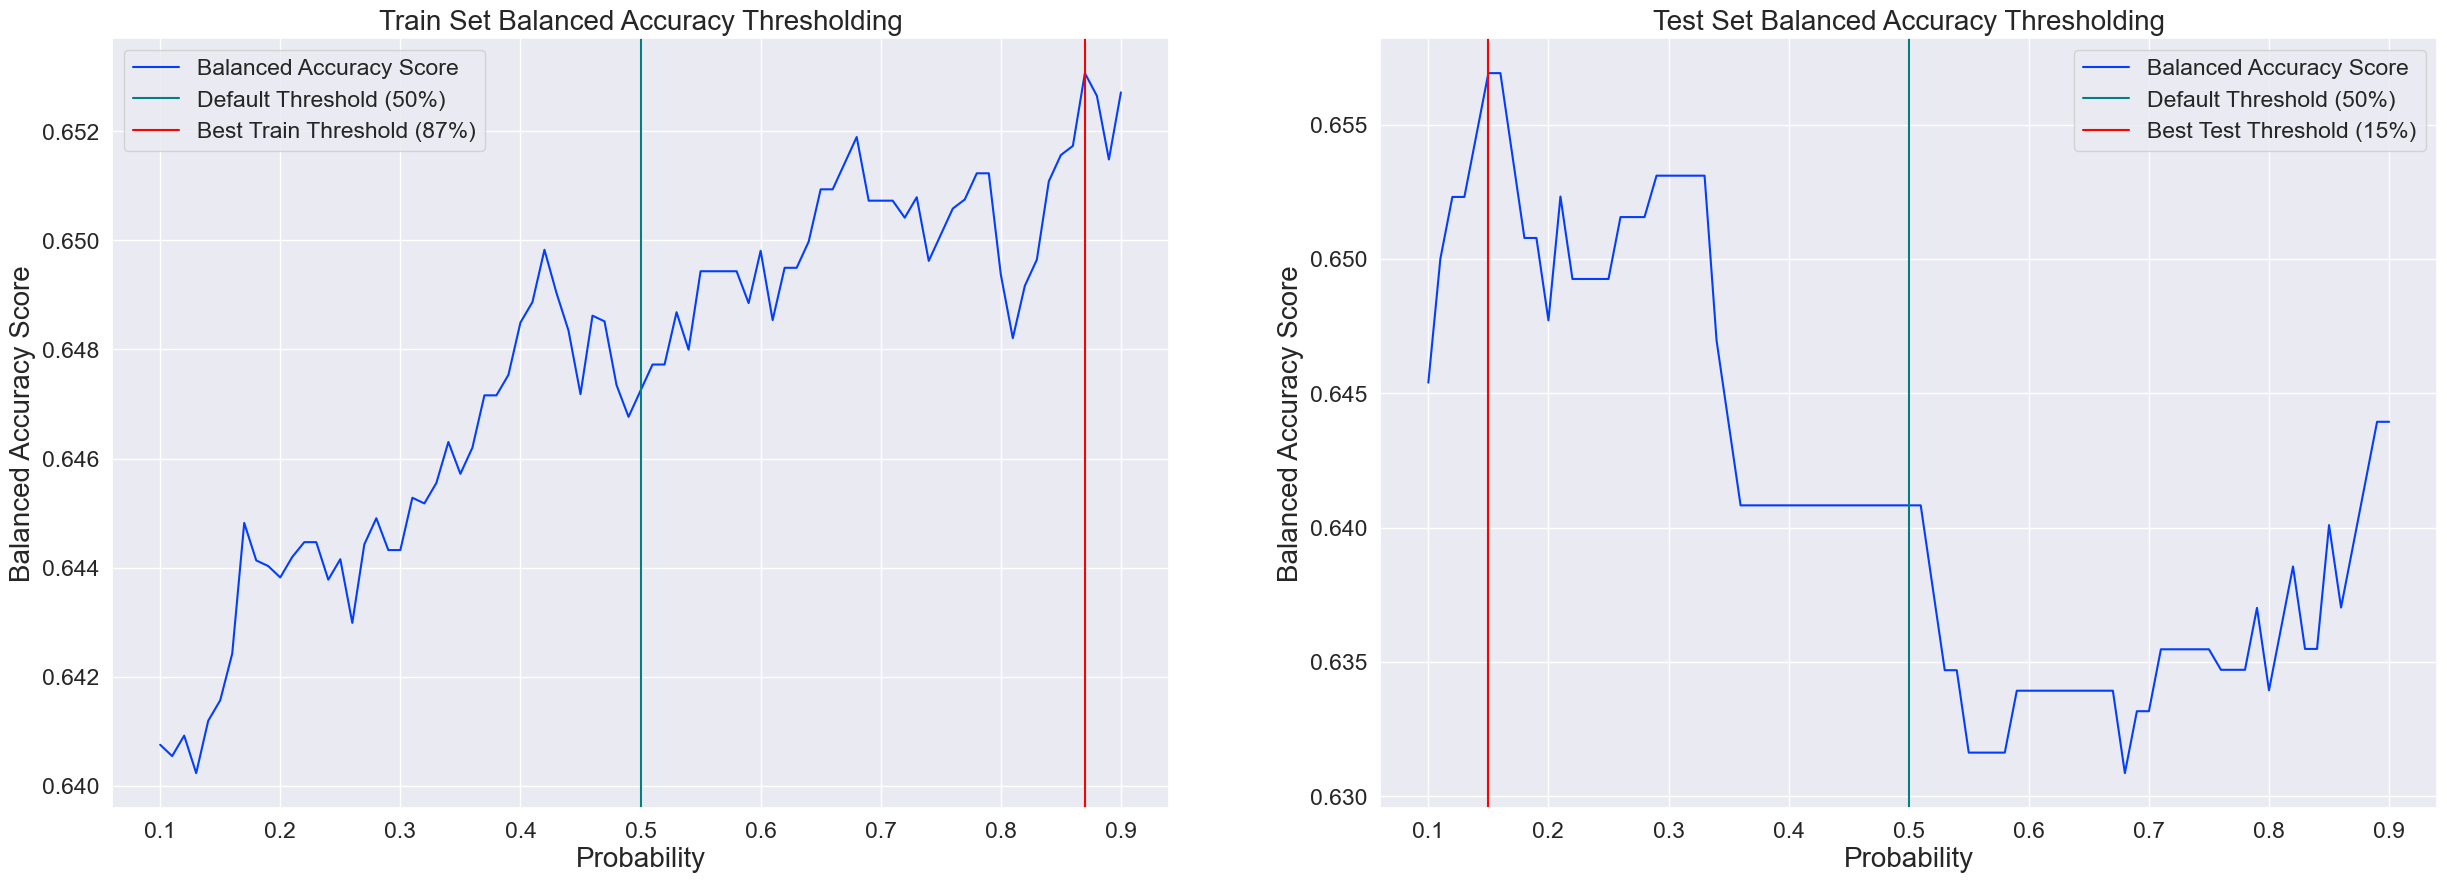

In [15]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = gnb_model, 
                                                         metric = 'balanced_accuracy', 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

Let's define a function to print out a **classification report**.

In [16]:
# Defining a function to print out the classification report
def print_classification_report(model = None, 
                                train_features = None, 
                                train_labels = None, 
                                test_features = None, 
                                test_labels = None, 
                                algorithm_name = None):
    """
    This function is used to print out a classification report for train & test set.
    
    Args:
        model: A classifier instance.
        train_features: Train features.
        train_labels: Train labels.
        test_features: Test features.
        test_labels: Train labels.
        algorithm_name: A name of an algoritm used to build the model.
        
    Returns:
        Prints out a classification report for train & test set.
    """
    # Creating a list of class labels
    classes = ['Loss or Draw', 'Win']
    
    # Making predictions on train and test set based on chosen probability thresholds
    train_predictions = np.where(model.predict_proba(X = train_features)[:, 1] >= train_threshold, 1, 0)
    test_predictions = np.where(model.predict_proba(X = test_features)[:, 1] >= test_threshold, 1, 0)
    
    # Creating a classification report for train & test set
    train_report = classification_report(y_true = train_labels, y_pred = train_predictions, target_names = classes)
    test_report = classification_report(y_true = test_labels, y_pred = test_predictions, target_names = classes)
    
    # Printing out the classification report for train & test sets
    print(f'Classification Report Summary for {algorithm_name} Model:\n')
    print(f'Train report:\n{train_report}\n\n')
    print(f'Test report:\n{test_report}')

In [17]:
# Calling the function to print out the classification report
print_classification_report(model = gnb_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            algorithm_name = 'Gaussian Naïve Bayes')

Classification Report Summary for Gaussian Naïve Bayes Model:

Train report:
              precision    recall  f1-score   support

Loss or Draw       0.68      0.70      0.69      1043
         Win       0.62      0.61      0.62       857

    accuracy                           0.66      1900
   macro avg       0.65      0.65      0.65      1900
weighted avg       0.66      0.66      0.66      1900



Test report:
              precision    recall  f1-score   support

Loss or Draw       0.73      0.63      0.67       217
         Win       0.58      0.69      0.63       163

    accuracy                           0.65       380
   macro avg       0.65      0.66      0.65       380
weighted avg       0.66      0.65      0.65       380



Let's define a function to plot **Receiver Operating Characteristics (ROC)** curve for train and test sets.

In [18]:
# Defining a function to plot Receiver Operating Characteristics (ROC) curve
def plot_roc_curve(model = None, 
                   train_features = None, 
                   train_labels = None, 
                   test_features = None, 
                   test_labels = None, 
                   algorithm_name = None):
    """
    This function is used to plot Receiver Operating Characteristics (ROC) curve for train & test set.
    
    Args:
        model: A classifier instance.
        train_features: Train features.
        train_labels: Train labels.
        test_features: Test features.
        test_labels: Train labels.
        algorithm_name: A name of an algoritm used to build the model.
        
    Returns:
        Plots Receiver Operating Characteristics (ROC) curve for train & test set.
    """
    # Calculating Area Under the Curve (AUC) score for train & test set
    auc_score_train = roc_auc_score(y_true = train_labels, y_score = model.predict_proba(X = train_features)[:, 1])
    auc_score_test = roc_auc_score(y_true = test_labels, y_score = model.predict_proba(X = test_features)[:, 1])
    
    # Calculating False Positive Rate (FPR) and True Positive Rate (TPR) for train set
    fpr, tpr, _ = roc_curve(y_true = train_labels, y_score = model.predict_proba(X = train_features)[:, 1])
    
    # Plotting Receiver Operating Characteristics (ROC) curve for train set
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label = f'{algorithm_name} Model AUC Score: {auc_score_train:.2f}', color = 'red')
    plt.plot([0, 1], [0, 1], label = 'Random Model', linestyle = '--', color = 'teal')
    plt.title(label = 'Train Set ROC Curve', fontsize = 20)
    plt.xlabel(xlabel = 'False Positive Rate', fontsize = 20)
    plt.ylabel(ylabel = 'True Positive Rate', fontsize = 20)
    plt.legend(loc = 'lower right', fontsize = 20)
    
    # Calculating False Positive Rate (FPR) and True Positive Rate (TPR) for test set
    fpr, tpr, _ = roc_curve(y_true = test_labels, y_score = model.predict_proba(X = test_features)[:, 1])
    
    # Plotting Receiver Operating Characteristics (ROC) curve for test set
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label = f'{algorithm_name} Model AUC Score: {auc_score_test:.2f}', color = 'red')
    plt.plot([0, 1], [0, 1], label = 'Random Model', linestyle = '--', color = 'teal')
    plt.title(label = 'Test Set ROC Curve', fontsize = 20)
    plt.xlabel(xlabel = 'False Positive Rate', fontsize = 20)
    plt.ylabel(ylabel = 'True Positive Rate', fontsize = 20)
    plt.legend(loc = 'lower right', fontsize = 20)
    plt.show()

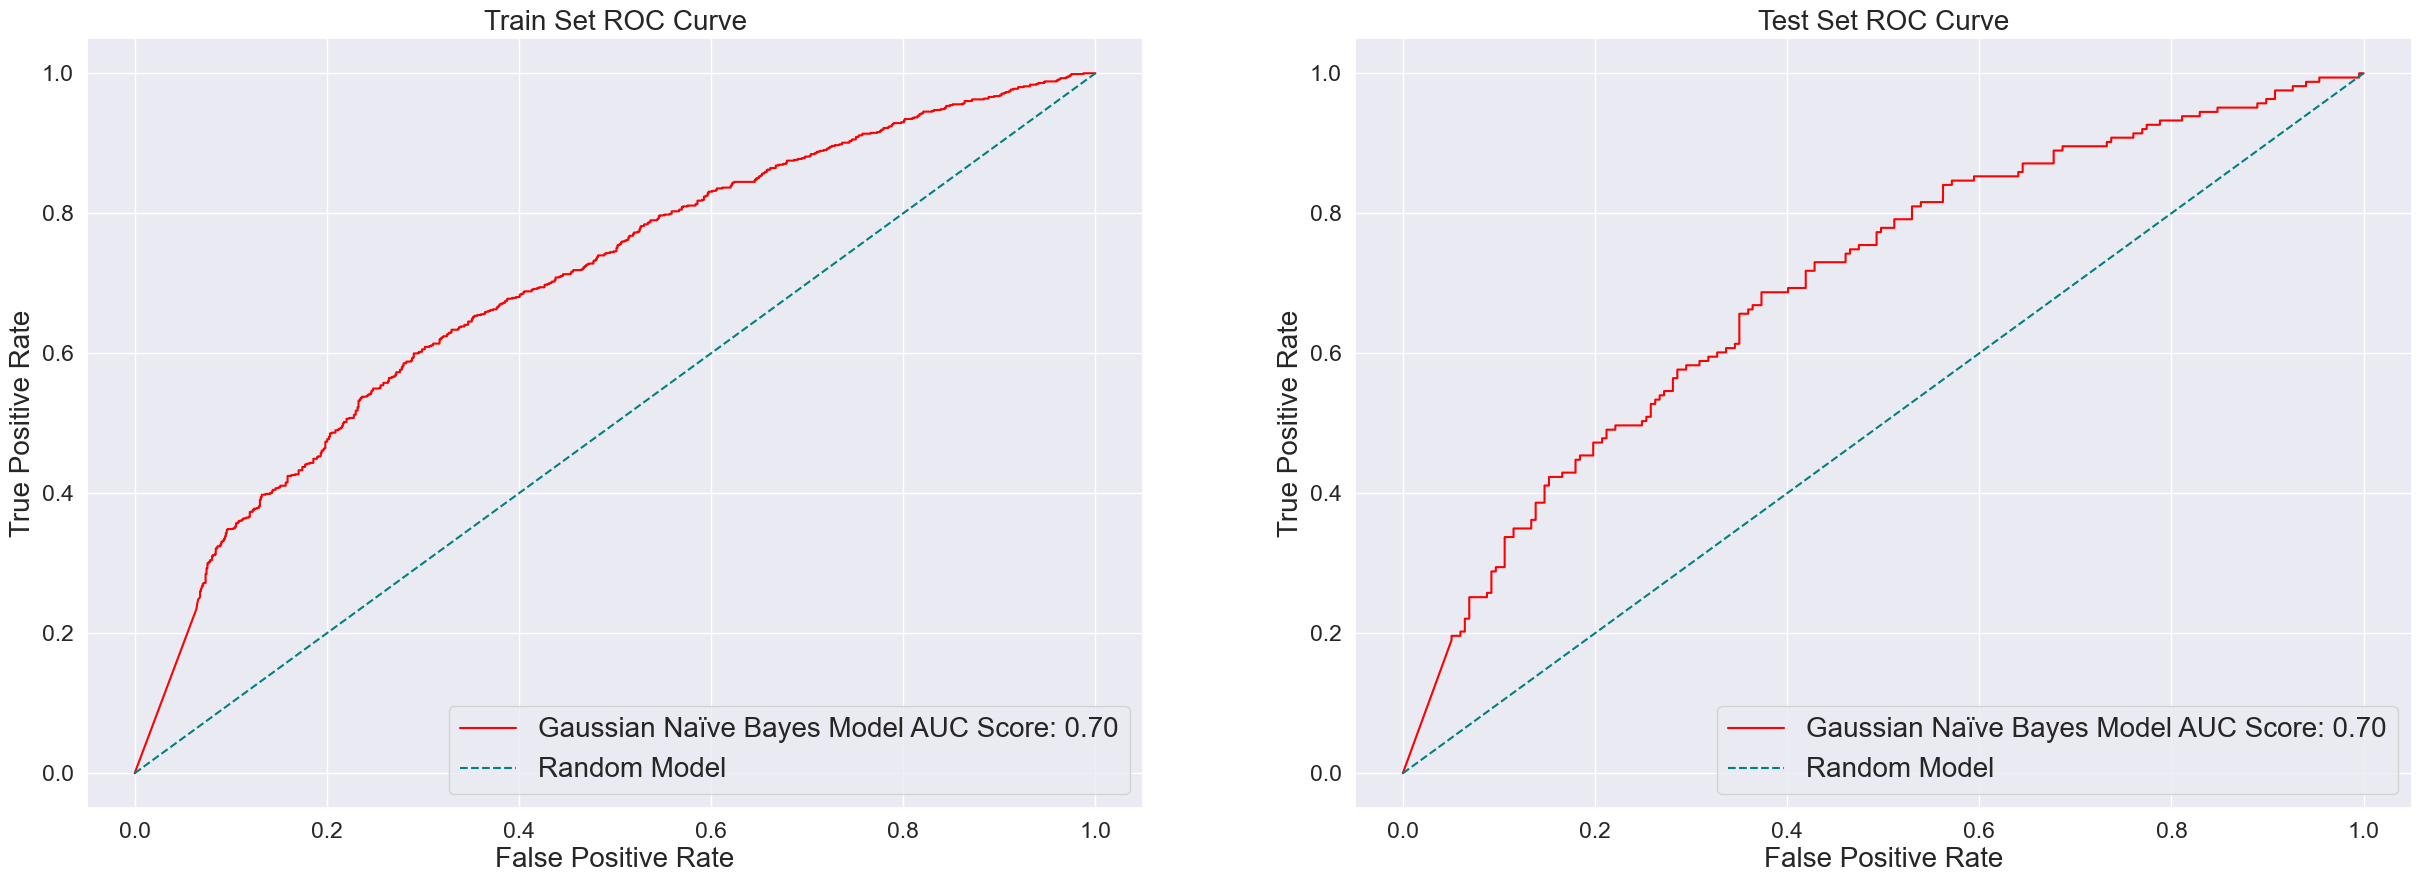

In [19]:
# Calling the function to plot ROC curve
plot_roc_curve(model = gnb_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = 'Gaussian Naïve Bayes')

Let's define a function to plot **confusion matrices**, **recall** & **precision ratio** for train and test sets.

In [20]:
# Defining a function to plot confusion matrices, recall & precision ratio
def plot_confusion_matrix(model = None, 
                          train_features = None, 
                          test_features = None, 
                          train_labels = None, 
                          test_labels = None):
    """
    This function is used to plot confusion matrices, recall & precision ratio for train & test set.
    
    Args:
        model: A classifier instance.
        train_features: Train features.
        train_labels: Train labels.
        test_features: Test features.
        test_labels: Train labels.
    
    Returns:
        Plots confusion matrices, recall and precision ratio for train & test set.
    """
    # Creating a list of class labels
    labels = ['Loss or Draw', 'Win']
    
    # Making predictions on train and test set based on chosen probability thresholds
    train_predictions = np.where(model.predict_proba(X = train_features)[:, 1] >= train_threshold, 1, 0)
    test_predictions = np.where(model.predict_proba(X = test_features)[:, 1] >= test_threshold, 1, 0)
    
    # Creating confusion matrices for train and test set
    cm_train = confusion_matrix(y_true = train_labels, y_pred = train_predictions)
    cm_test = confusion_matrix(y_true = test_labels, y_pred = test_predictions)
    
    # Plotting confusion matrix for train set
    plt.figure(figsize = (30, 18))
    plt.subplot(2, 3, 1)
    sns.heatmap(data = cm_train, cmap = plt.cm.Blues, annot = True, fmt = '.4g', cbar = False, xticklabels = labels, yticklabels = labels)
    plt.title(label = 'Train Set Confusion Matrix', fontsize = 16)
    plt.ylabel(ylabel = 'Ground Truth', fontsize = 16)
    plt.xlabel(xlabel = 'Predictions', fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xticks(fontsize = 16)
    
    # Calculating recall ratio for train set
    upper_array = np.divide(cm_train[0], cm_train.sum(axis = 1)[0])
    lower_array = np.divide(cm_train[1], cm_train.sum(axis = 1)[1])
    final_array = np.vstack(tup = (upper_array, lower_array))
    
    # Plotting recall ratio for train set
    plt.subplot(2, 3, 2)
    sns.heatmap(data = final_array, cmap = plt.cm.Blues, annot = True, fmt = '.0%', cbar = False, xticklabels = labels, yticklabels = labels)
    plt.title(label = 'Train Set Recall Ratio(%)', fontsize = 16)
    plt.ylabel(ylabel = 'Ground Truth', fontsize = 16)
    plt.xlabel(xlabel = 'Predictions', fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xticks(fontsize = 16)
    
    # Calculating precision ratio for train set
    negative_predictions = np.expand_dims(a = np.divide(cm_train[:, 0], cm_train.sum(axis = 0)[0]), axis = 1)
    positive_predictions = np.expand_dims(a = np.divide(cm_train[:, 1], cm_train.sum(axis = 0)[1]), axis = 1)
    final_array = np.hstack(tup = (negative_predictions, positive_predictions))
    
    # Plotting precision ratio for train set
    plt.subplot(2, 3, 3)
    sns.heatmap(data = final_array, cmap = plt.cm.Blues, annot = True, fmt = '.0%', cbar = False, xticklabels = labels, yticklabels = labels)
    plt.title(label = 'Train Set Precision Ratio(%)', fontsize = 16)
    plt.ylabel(ylabel = 'Ground Truth', fontsize = 16)
    plt.xlabel(xlabel = 'Predictions', fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xticks(fontsize = 16)
    
    # Plotting confusion matrix for test set
    plt.subplot(2, 3, 4)
    sns.heatmap(data = cm_test, cmap = plt.cm.Blues, annot = True, fmt = '.4g', cbar = False, xticklabels = labels, yticklabels = labels)
    plt.title(label = 'Test Set Confusion Matrix', fontsize = 16)
    plt.ylabel(ylabel = 'Ground Truth', fontsize = 16)
    plt.xlabel(xlabel = 'Predictions', fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xticks(fontsize = 16)
    
    # Calculating recall ratio for test set
    upper_array = np.divide(cm_test[0], cm_test.sum(axis = 1)[0])
    lower_array = np.divide(cm_test[1], cm_test.sum(axis = 1)[1])
    final_array = np.vstack(tup = (upper_array, lower_array))
    
    # Plotting recall ratio for test set
    plt.subplot(2, 3, 5)
    sns.heatmap(data = final_array, cmap = plt.cm.Blues, annot = True, fmt = '.0%', cbar = False, xticklabels = labels, yticklabels = labels)
    plt.title(label = 'Test Set Recall Ratio(%)', fontsize = 16)
    plt.ylabel(ylabel = 'Ground Truth', fontsize = 16)
    plt.xlabel(xlabel = 'Predictions', fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xticks(fontsize = 16)
    
    # Calculating precision ratio for test set
    negative_predictions = np.expand_dims(a = np.divide(cm_test[:, 0], cm_test.sum(axis = 0)[0]), axis = 1)
    positive_predictions = np.expand_dims(a = np.divide(cm_test[:, 1], cm_test.sum(axis = 0)[1]), axis = 1)
    final_array = np.hstack(tup = (negative_predictions, positive_predictions))
    
    # Plotting precision ratio for test set
    plt.subplot(2, 3, 6)
    sns.heatmap(data = final_array, cmap = plt.cm.Blues, annot = True, fmt = '.0%', cbar = False, xticklabels = labels, yticklabels = labels)
    plt.title(label = 'Test Set Precision Ratio(%)', fontsize = 16)
    plt.ylabel(ylabel = 'Ground Truth', fontsize = 16)
    plt.xlabel(xlabel = 'Predictions', fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.show()

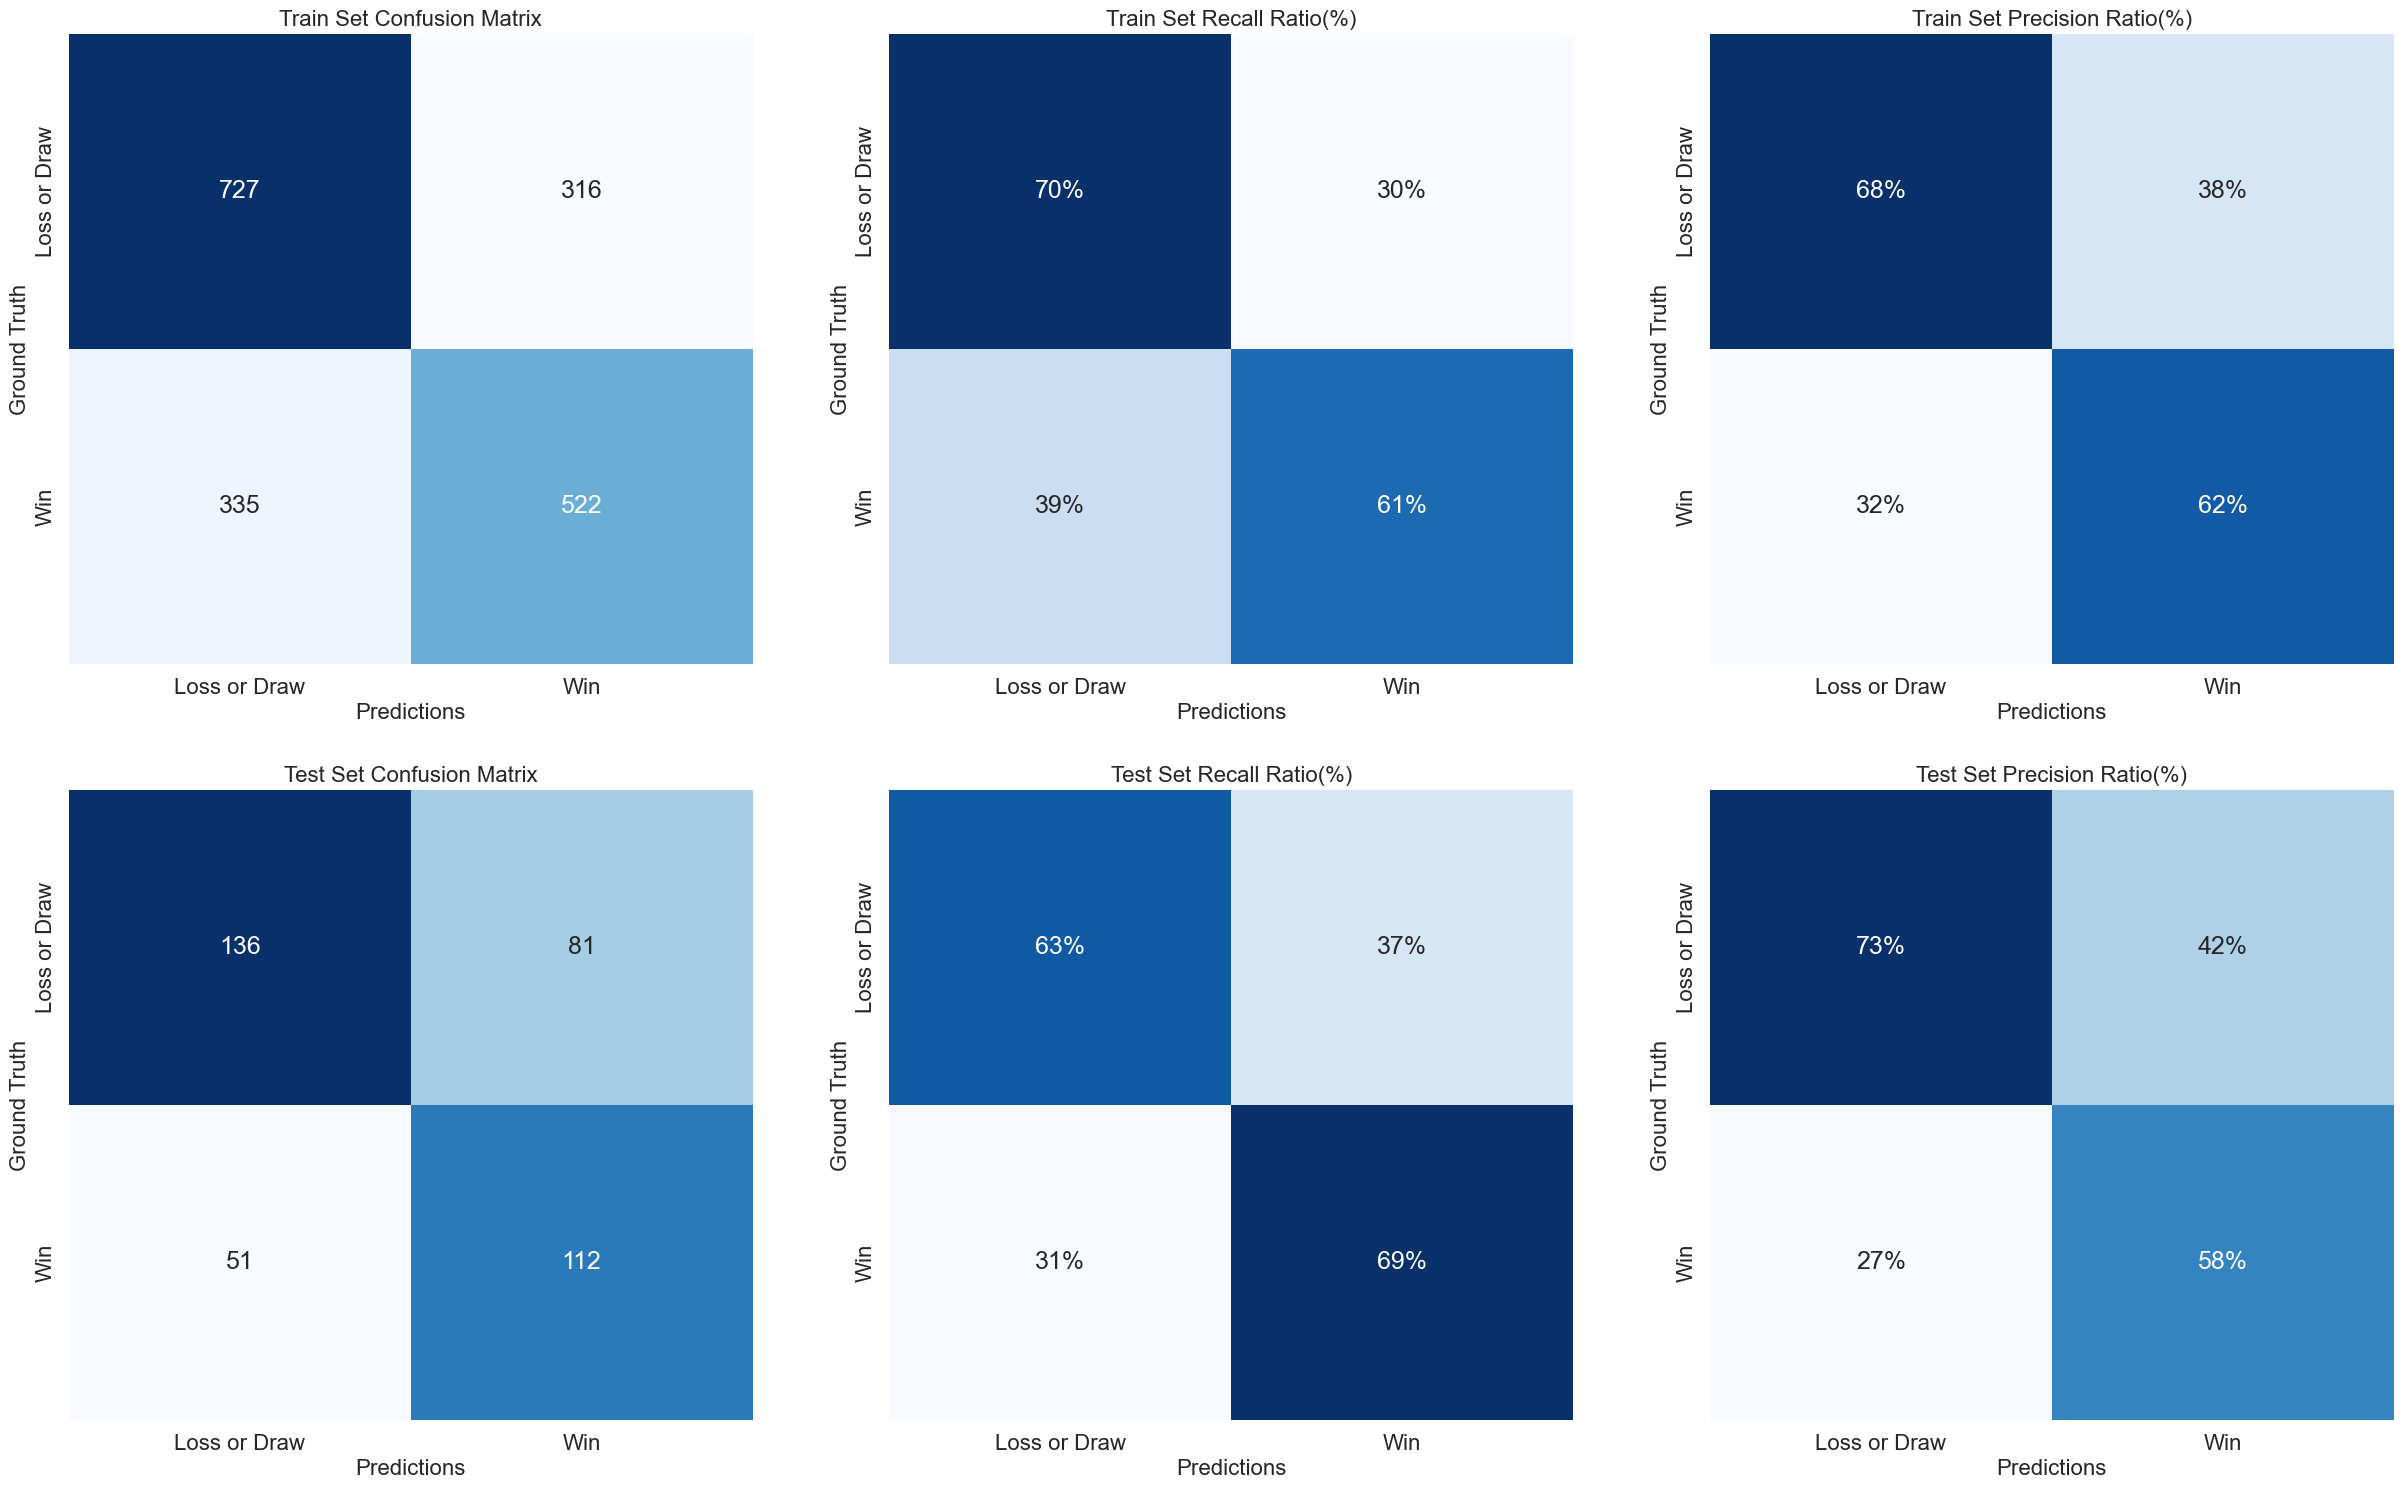

In [21]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = gnb_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test)

Let's define a function to evaluate the performance of a classifier.

In [22]:
# Defining a function to evaluate the performance of a classifier
def evaluate_model_performance(model = None, 
                               train_features = None, 
                               train_labels = None, 
                               test_features = None, 
                               test_labels = None, 
                               algorithm_name = None, 
                               beta = 0.5):
    """
    Args:
        model: A classifier instance.
        train_features: Train features.
        train_labels: Train labels.
        test_features: Test features.
        test_labels: Train labels.
        algorithm_name: A name of an algoritm used to build the model.
        beta: Beta to calculate F Beta score
        
    Returns:
        A pandas data frame.
    """
    # Making predictions on train and test set based on chosen probability thresholds
    train_predictions = np.where(model.predict_proba(X = train_features)[:, 1] >= train_threshold, 1, 0)
    test_predictions = np.where(model.predict_proba(X = test_features)[:, 1] >= test_threshold, 1, 0)
    
    # Calculating confusion matrix for train and test set
    cm_train = confusion_matrix(y_true = train_labels, y_pred = train_predictions)
    cm_test = confusion_matrix(y_true = test_labels, y_pred = test_predictions)
    
    # Calculating TPs, FPs, TNs, and FNs for train set
    TP_train = cm_train[1][1]
    TN_train = cm_train[0][0]
    FP_train = cm_train[0][1]
    FN_train = cm_train[1][0]
    
    # Calculating TPs, FPs, TNs, and FNs for test set
    TP_test = cm_test[1][1]
    TN_test = cm_test[0][0]
    FP_test = cm_test[0][1]
    FN_test = cm_test[1][0]
    
    # Calculating the sensitivity and specificity for train set
    sensitivity_train = TP_train / (TP_train + FN_train)
    specificity_train = TN_train / (TN_train + FP_train)
    
    # Calculating the sensitivity and specificity for test set
    sensitivity_test = TP_test / (TP_test + FN_test)
    specificity_test = TN_test / (TN_test + FP_test)
    
    # Evaluating the performance of the model based on evaluation metrics for a classification problem
    brier_loss = round(number = np.mean(a = np.power(test_labels - model.predict_proba(X = test_features)[:, 1], 2)), ndigits = 2)
    auc = round(number = roc_auc_score(y_true = test_labels, y_score = model.predict_proba(X = test_features)[:, 1]), ndigits = 2)
    accuracy = round(number = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test), ndigits = 2)
    balanced_accuracy_train = round(number = (sensitivity_train + specificity_train) / 2, ndigits = 2)
    balanced_accuracy_test = round(number = (sensitivity_test + specificity_test) / 2, ndigits = 2)
    precision = round(number = TP_test / (TP_test + FP_test), ndigits = 2)
    recall = round(number = TP_test / (TP_test + FN_test), ndigits = 2)
    f_beta = round(number = ((1 + (beta ** 2)) * precision * recall) / (((beta ** 2) * precision) + recall), ndigits = 2)
    
    # Creating a dictionary of evaluation metrics for a classification problem
    data_dictionary = {'Train Balanced Accuracy':balanced_accuracy_train, 'Test Balanced Accuracy':balanced_accuracy_test, 'Accuracy':accuracy, 'Precision':precision, 
                       'Recall':recall, f'F{beta}':f_beta , 'AUC':auc, 'Brier Score Loss':brier_loss, 'Train Threshold':train_threshold, 'Test Threshold':test_threshold}
    
    # Creating a pandas data frame to store evaluation metrics for the model
    summary_df = pd.DataFrame(data = data_dictionary, index = [algorithm_name])
    
    # Returning the summary for evaluation metrics
    return summary_df

In [23]:
# Calling the function to evaluate the performance of the classifier
gnb_model_summary_df = evaluate_model_performance(model = gnb_model, 
                                                  train_features = X_train, 
                                                  train_labels = y_train, 
                                                  test_features = X_test, 
                                                  test_labels = y_test,
                                                  algorithm_name = 'Gaussian Naïve Bayes')
gnb_model_summary_df

Train Balanced Accuracy  Test Balanced Accuracy  \
Gaussian Naïve Bayes                     0.65                    0.66   

                      Accuracy  Precision  Recall  F0.5  AUC  \
Gaussian Naïve Bayes      0.65       0.58    0.69   0.6  0.7   

                      Brier Score Loss  Train Threshold  Test Threshold  
Gaussian Naïve Bayes              0.34             0.87            0.15

***
### Logistic Regression

In [24]:
# Building a classifier
lr_model = build_pipeline(classifier = LogisticRegression(solver = 'liblinear', random_state = 42),  
                          data_frame = df, 
                          train_features = X_train, 
                          train_labels = y_train,
                          apply_bayesian_optimization = False,
                          scaler_type = 'robust',
                          feature_selection_method = 'statistical')

# Logging information to the log file
logging.info(msg = 'Logistic Regression model has been built')

# Displaying the architecture of the classifier
lr_model

Pipeline(steps=[('feature_reallocator', FeatureReallocator()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('binary_pipeline',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['is_boxing_day',
                                                   'finished_top_4_last_season_h',
                                                   'finished_top_4_last_season_a',
                                                   'won_carabao_cup_last_seaso...
                                                   'total_avg_shots_on_target_last_3_a',
                                                   'total_avg_shots_on_target_last_5_h',
                                                   'total_avg_shots_on_target_last_5_a',
                                                   'total_avg_shots_h',
                                                   'total_avg_shots_a',
                                                   'total_avg_shots_last_3_h',
                                                   'total_avg_shots_last_3_a',
                                                   'total_avg_shots_last_5_h',
                                                   'total_avg_shots_last_5_a', ...])])),
                ('feature_selector', SelectFpr()),
                ('classifier',
                 LogisticRegression(random_state=42, solver='liblinear'))])

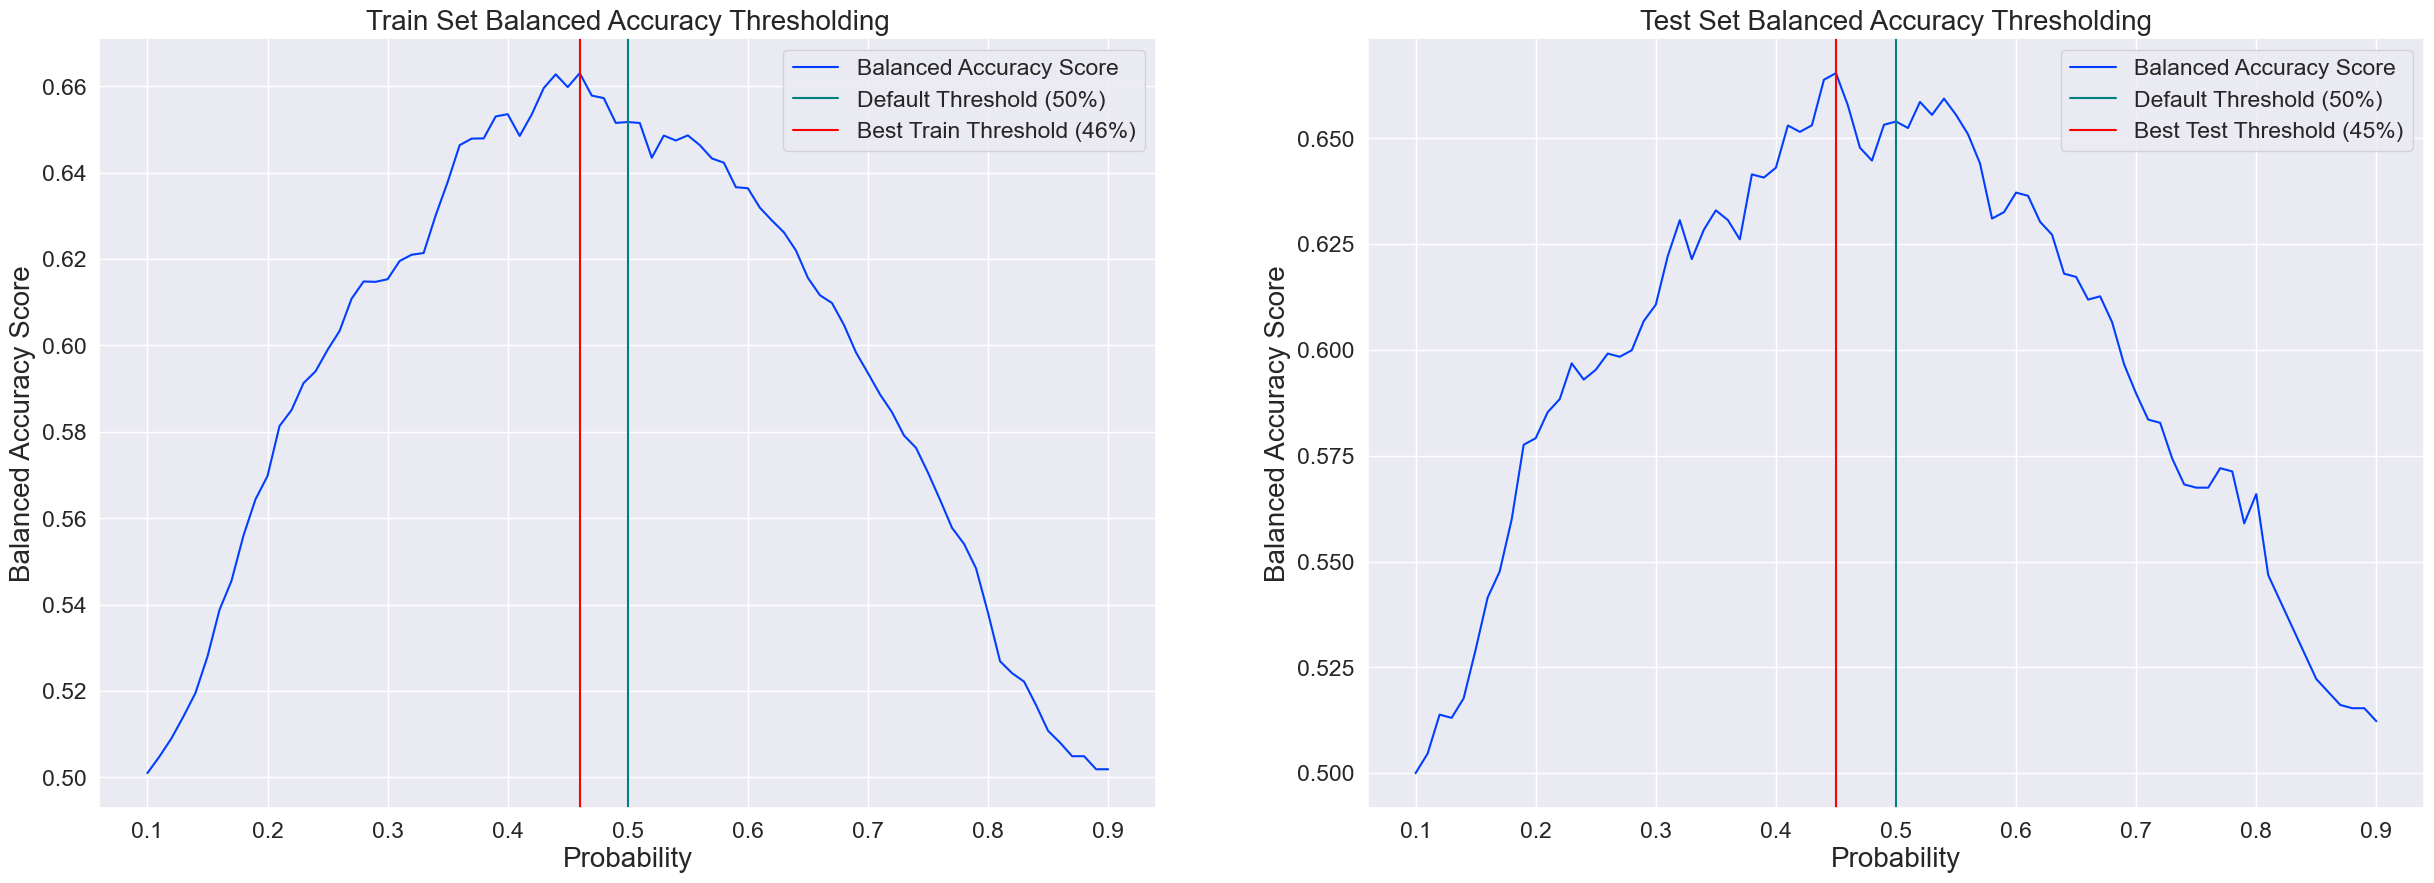

In [25]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = lr_model, 
                                                         metric = 'balanced_accuracy', 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [26]:
# Calling the function to print out the classification report
print_classification_report(model = lr_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            algorithm_name = 'Logistic Regression')

Classification Report Summary for Logistic Regression Model:

Train report:
              precision    recall  f1-score   support

Loss or Draw       0.69      0.71      0.70      1043
         Win       0.64      0.61      0.63       857

    accuracy                           0.67      1900
   macro avg       0.66      0.66      0.66      1900
weighted avg       0.67      0.67      0.67      1900



Test report:
              precision    recall  f1-score   support

Loss or Draw       0.71      0.71      0.71       217
         Win       0.61      0.63      0.62       163

    accuracy                           0.67       380
   macro avg       0.66      0.67      0.67       380
weighted avg       0.67      0.67      0.67       380



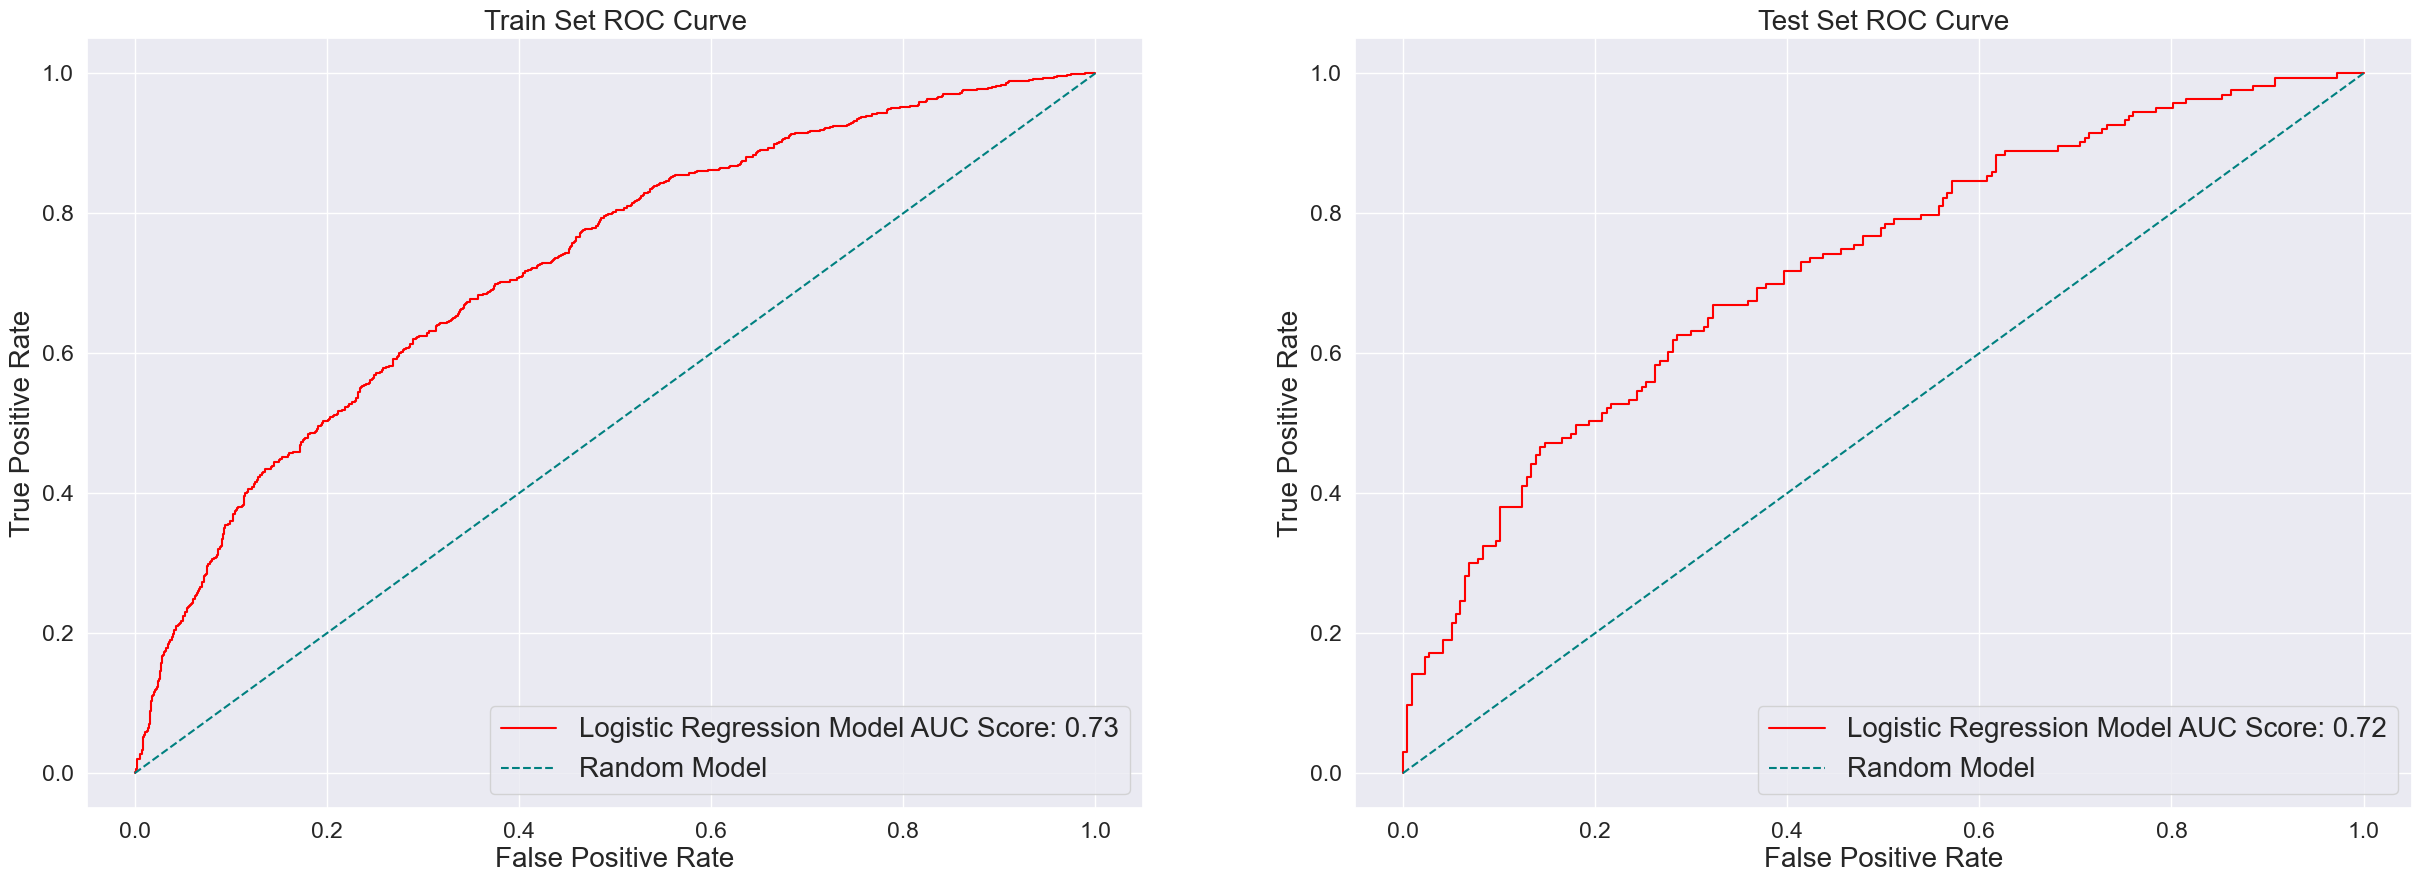

In [27]:
# Calling the function to plot ROC curve
plot_roc_curve(model = lr_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = 'Logistic Regression')

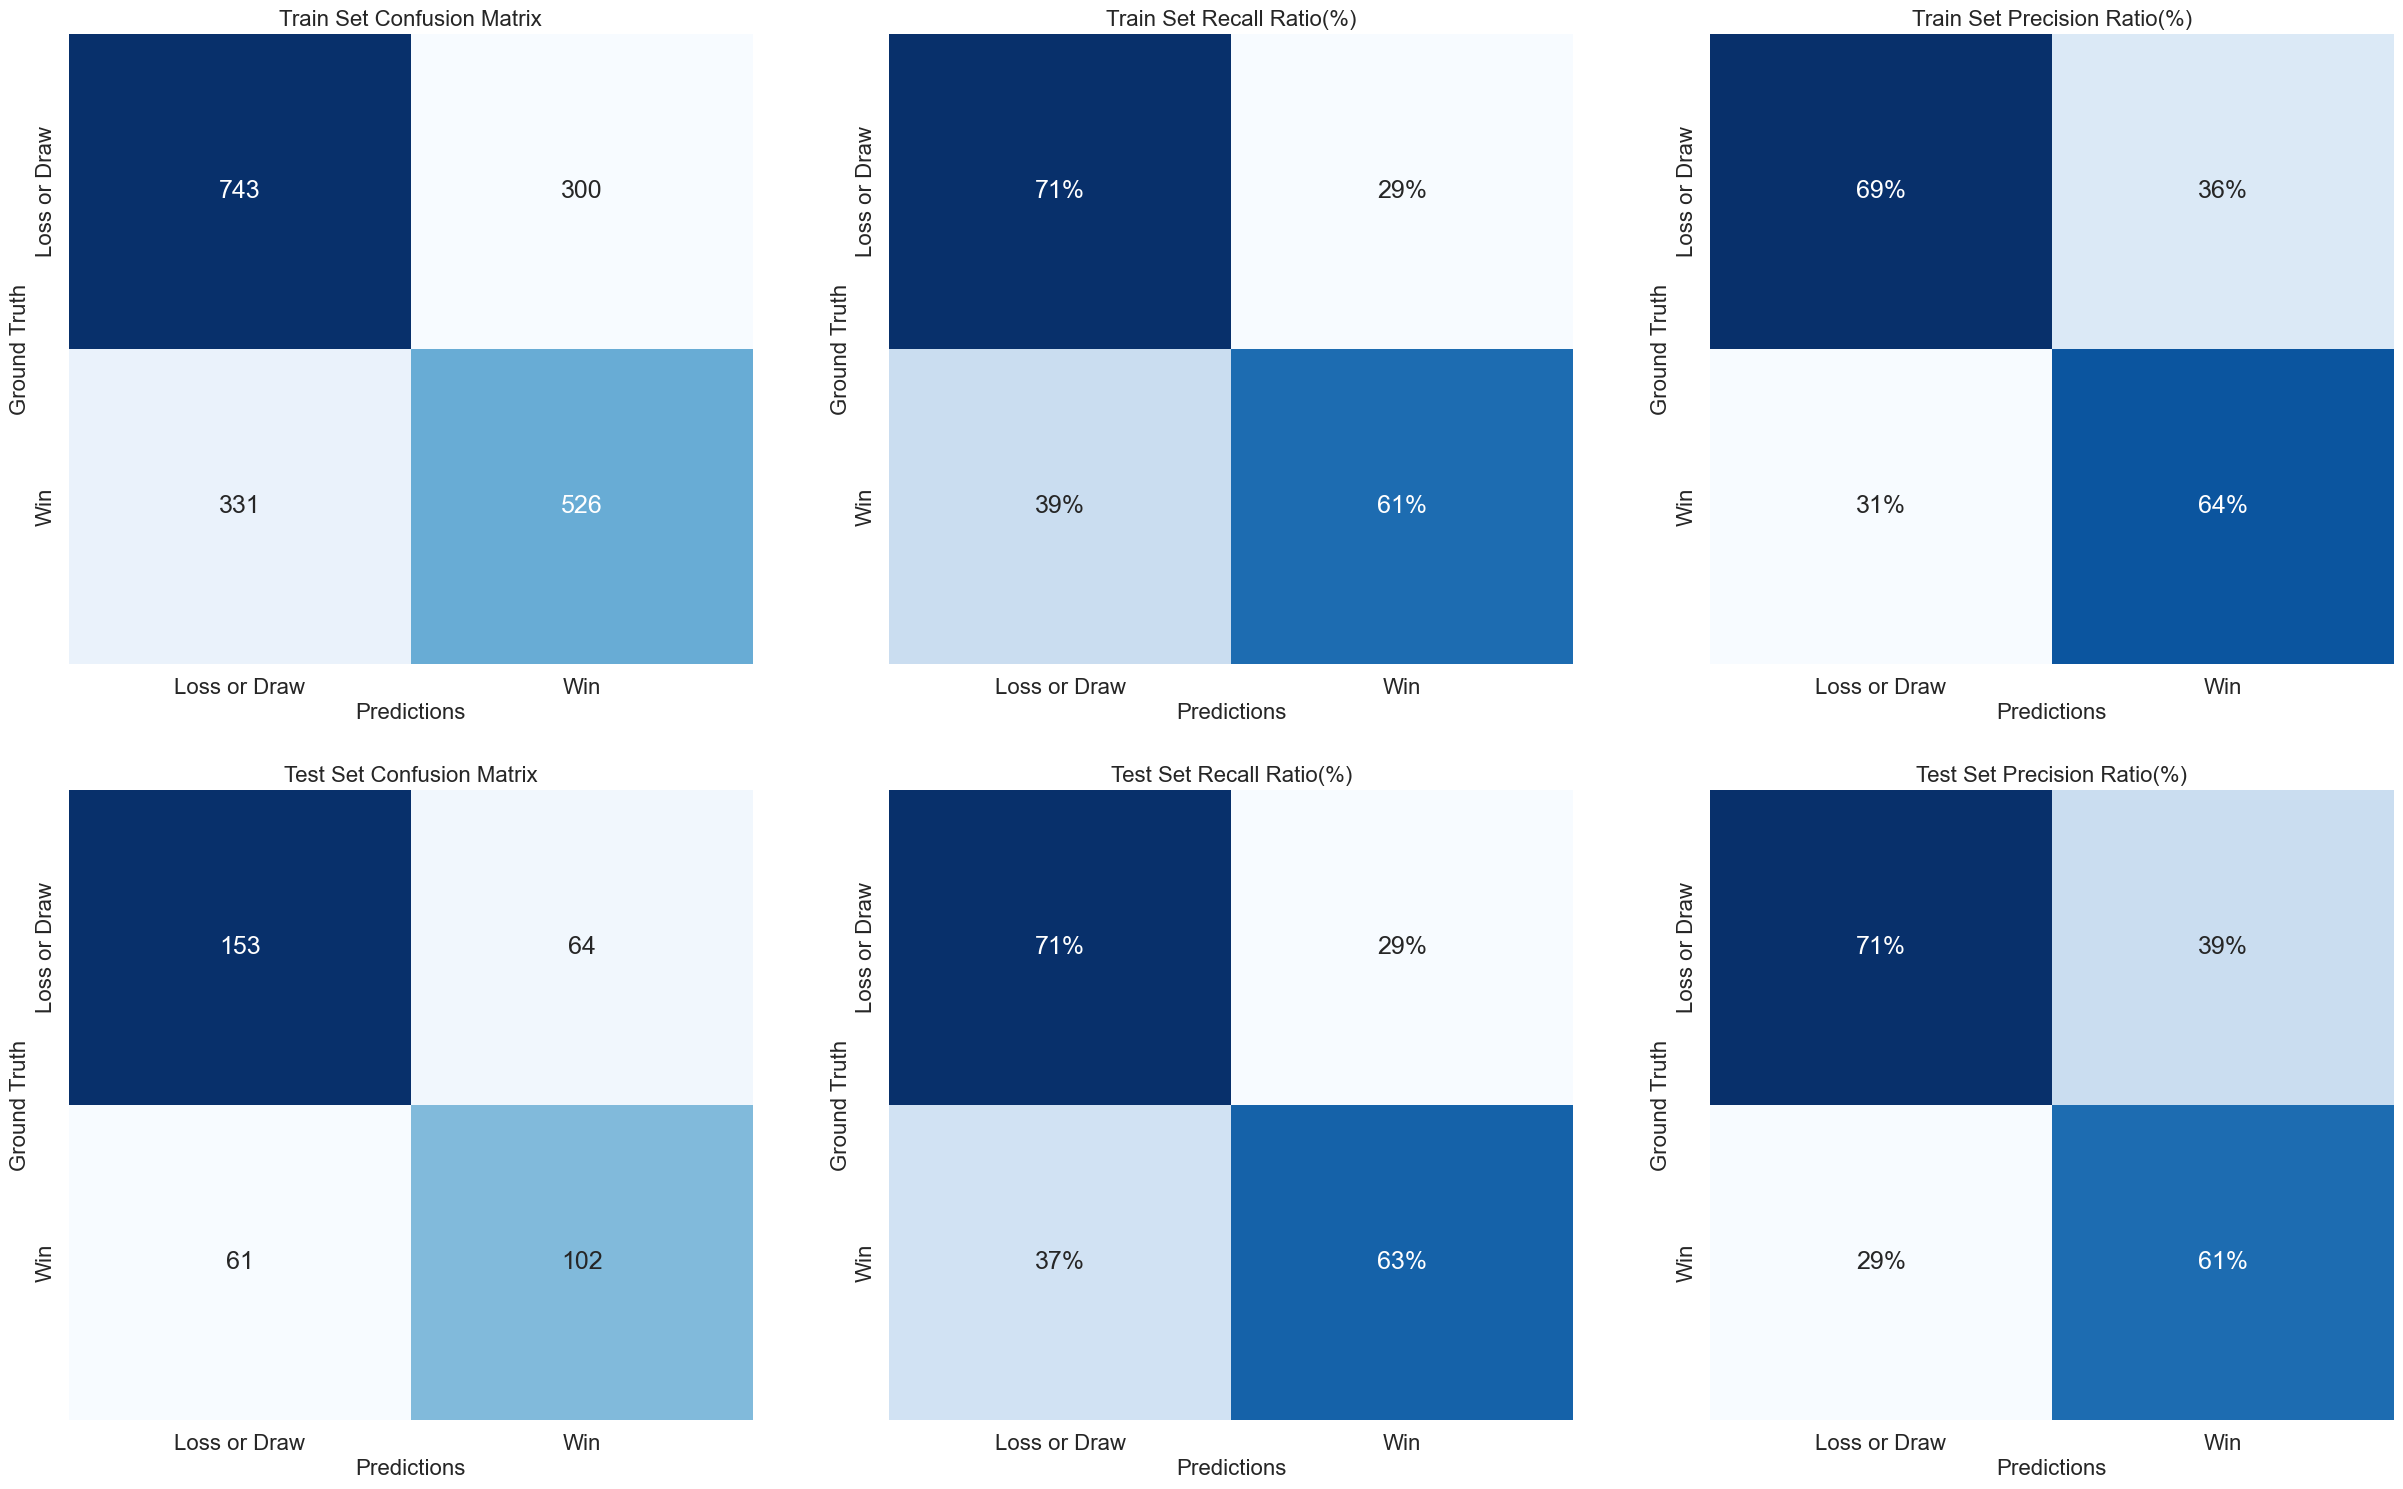

In [28]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = lr_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test)

In [29]:
# Calling the function to evaluate the performance of the classifier
lr_model_summary_df = evaluate_model_performance(model = lr_model, 
                                                 train_features = X_train, 
                                                 train_labels = y_train, 
                                                 test_features = X_test, 
                                                 test_labels = y_test,
                                                 algorithm_name = 'Logistic Regression')
lr_model_summary_df

Train Balanced Accuracy  Test Balanced Accuracy  \
Logistic Regression                     0.66                    0.67   

                     Accuracy  Precision  Recall  F0.5   AUC  \
Logistic Regression      0.67       0.61    0.63  0.61  0.72   

                     Brier Score Loss  Train Threshold  Test Threshold  
Logistic Regression              0.21             0.46            0.45

***
### Support Vector Machine

In [30]:
# Building a classifier
svm_model = build_pipeline(classifier = SVC(kernel = 'linear', probability = True, random_state = 42), 
                           data_frame = df, 
                           train_features = X_train, 
                           train_labels = y_train, 
                           apply_bayesian_optimization = False,
                           scaler_type = 'minmax',
                           drop_high_vif_features = False,
                           feature_selection_method = 'meta')

# Logging information to the log file
logging.info(msg = 'Support Vector Machine model has been built')

# Displaying the architecture of the classifier
svm_model

Pipeline(steps=[('feature_reallocator', FeatureReallocator()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('binary_pipeline',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['is_boxing_day',
                                                   'finished_top_4_last_season_h',
                                                   'finished_top_4_last_season_a',
                                                   'won_carabao_cup_last_seaso...
                                                   'total_avg_shots_on_target_last_5_a',
                                                   'total_avg_shots_h',
                                                   'total_avg_shots_a',
                                                   'total_avg_shots_last_3_h',
                                                   'total_avg_shots_last_3_a',
                                                   'total_avg_shots_last_5_h',
                                                   'total_avg_shots_last_5_a', ...])])),
                ('feature_selector',
                 SelectFromModel(estimator=SVC(kernel='linear',
                                               probability=True,
                                               random_state=42))),
                ('classifier',
                 SVC(kernel='linear', probability=True, random_state=42))])

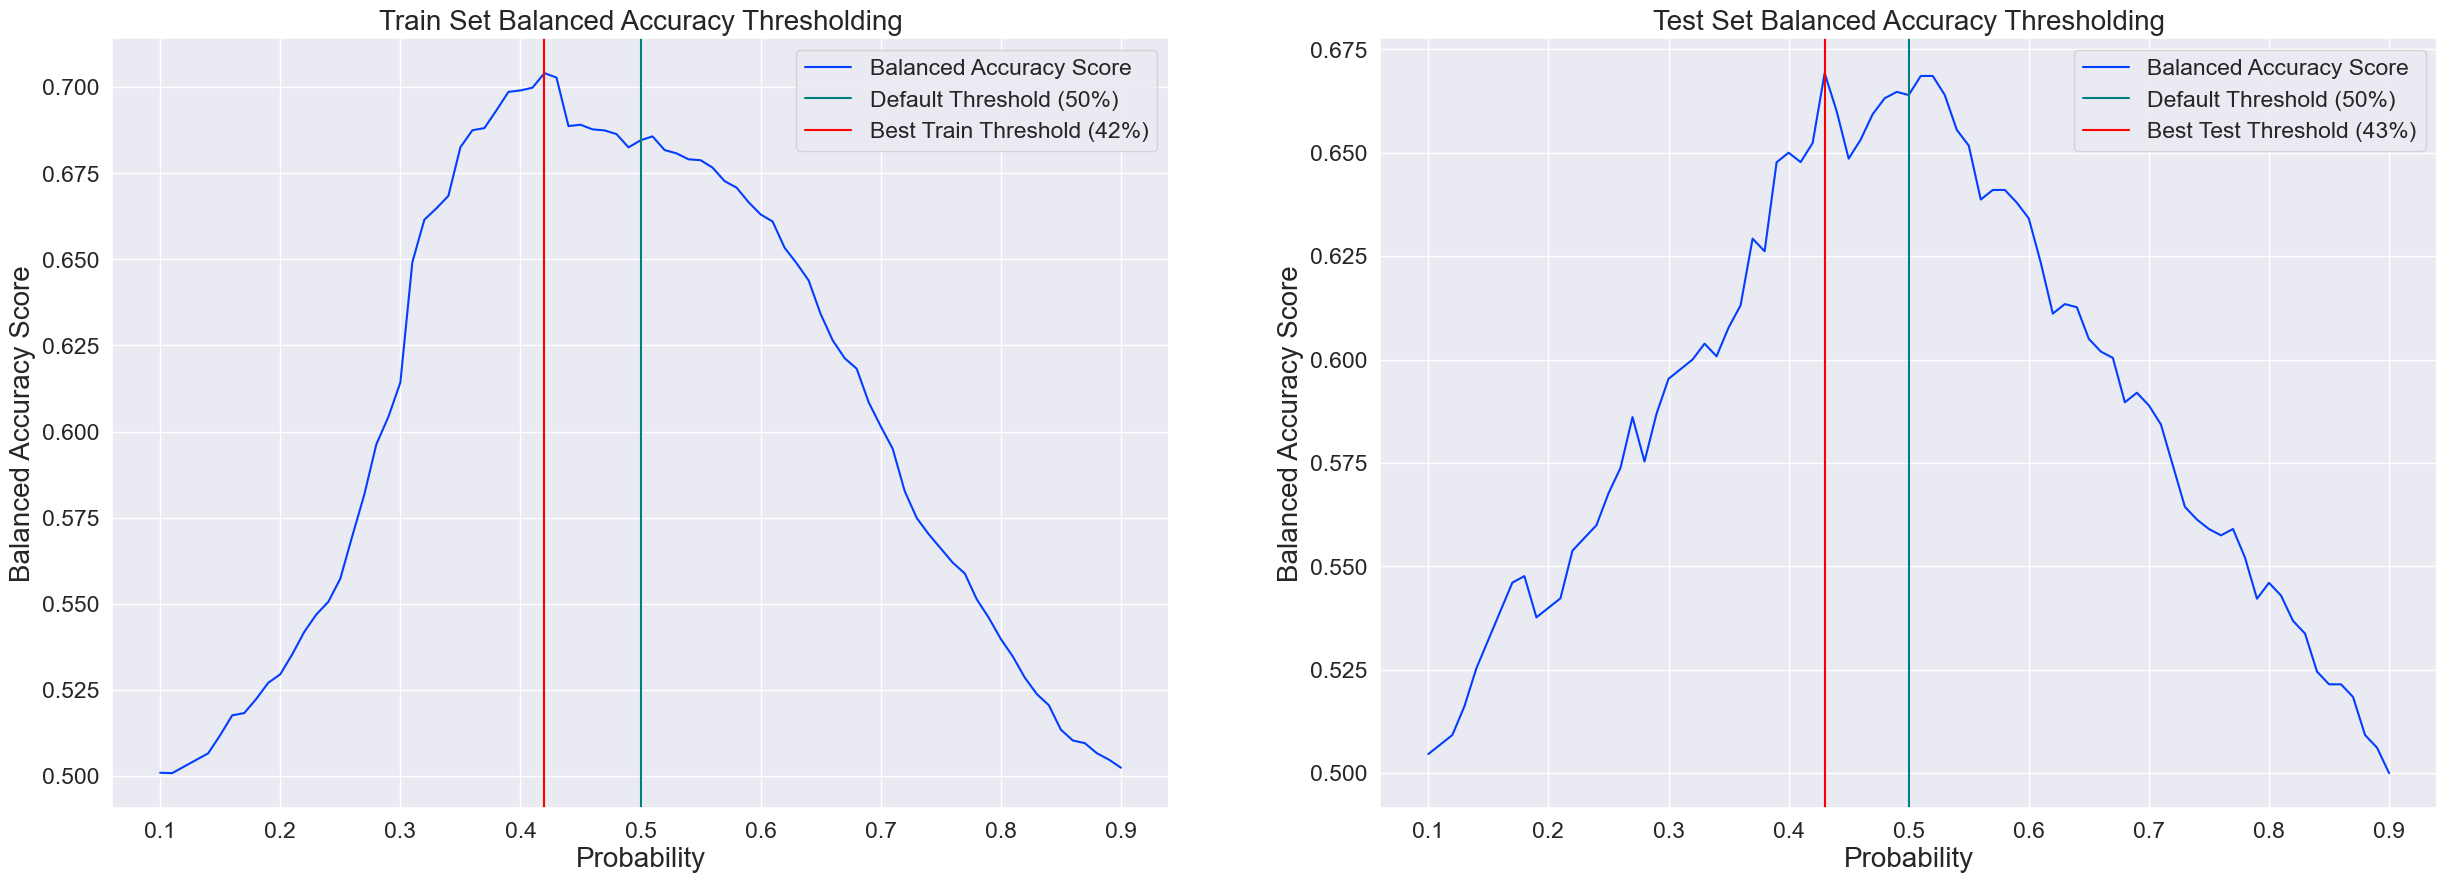

In [31]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = svm_model, 
                                                         metric = 'balanced_accuracy', 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [32]:
# Calling the function to print out the classification report
print_classification_report(model = svm_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            algorithm_name = 'Support Vector Machine')

Classification Report Summary for Support Vector Machine Model:

Train report:
              precision    recall  f1-score   support

Loss or Draw       0.74      0.71      0.72      1043
         Win       0.66      0.70      0.68       857

    accuracy                           0.70      1900
   macro avg       0.70      0.70      0.70      1900
weighted avg       0.71      0.70      0.70      1900



Test report:
              precision    recall  f1-score   support

Loss or Draw       0.72      0.70      0.71       217
         Win       0.62      0.64      0.63       163

    accuracy                           0.67       380
   macro avg       0.67      0.67      0.67       380
weighted avg       0.68      0.67      0.67       380



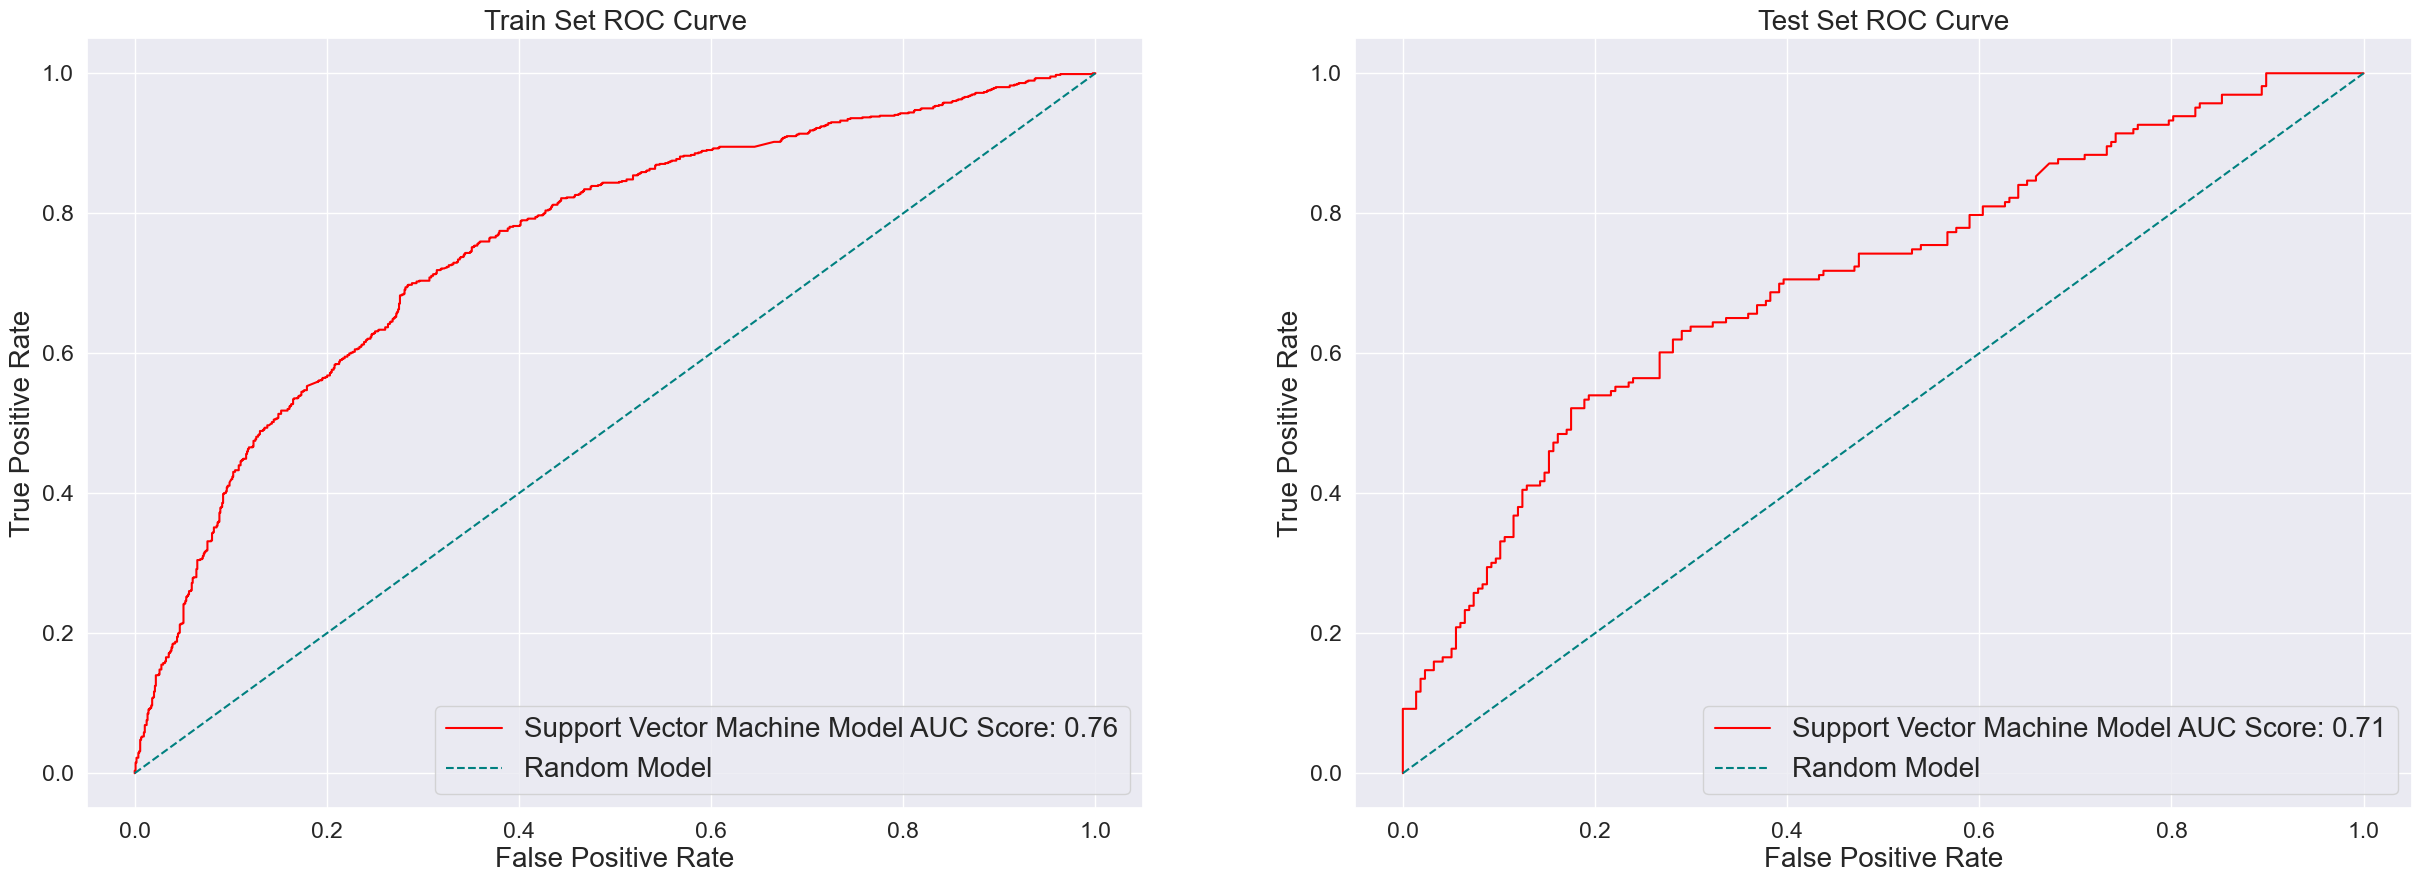

In [33]:
# Calling the function to plot ROC curve
plot_roc_curve(model = svm_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = 'Support Vector Machine')

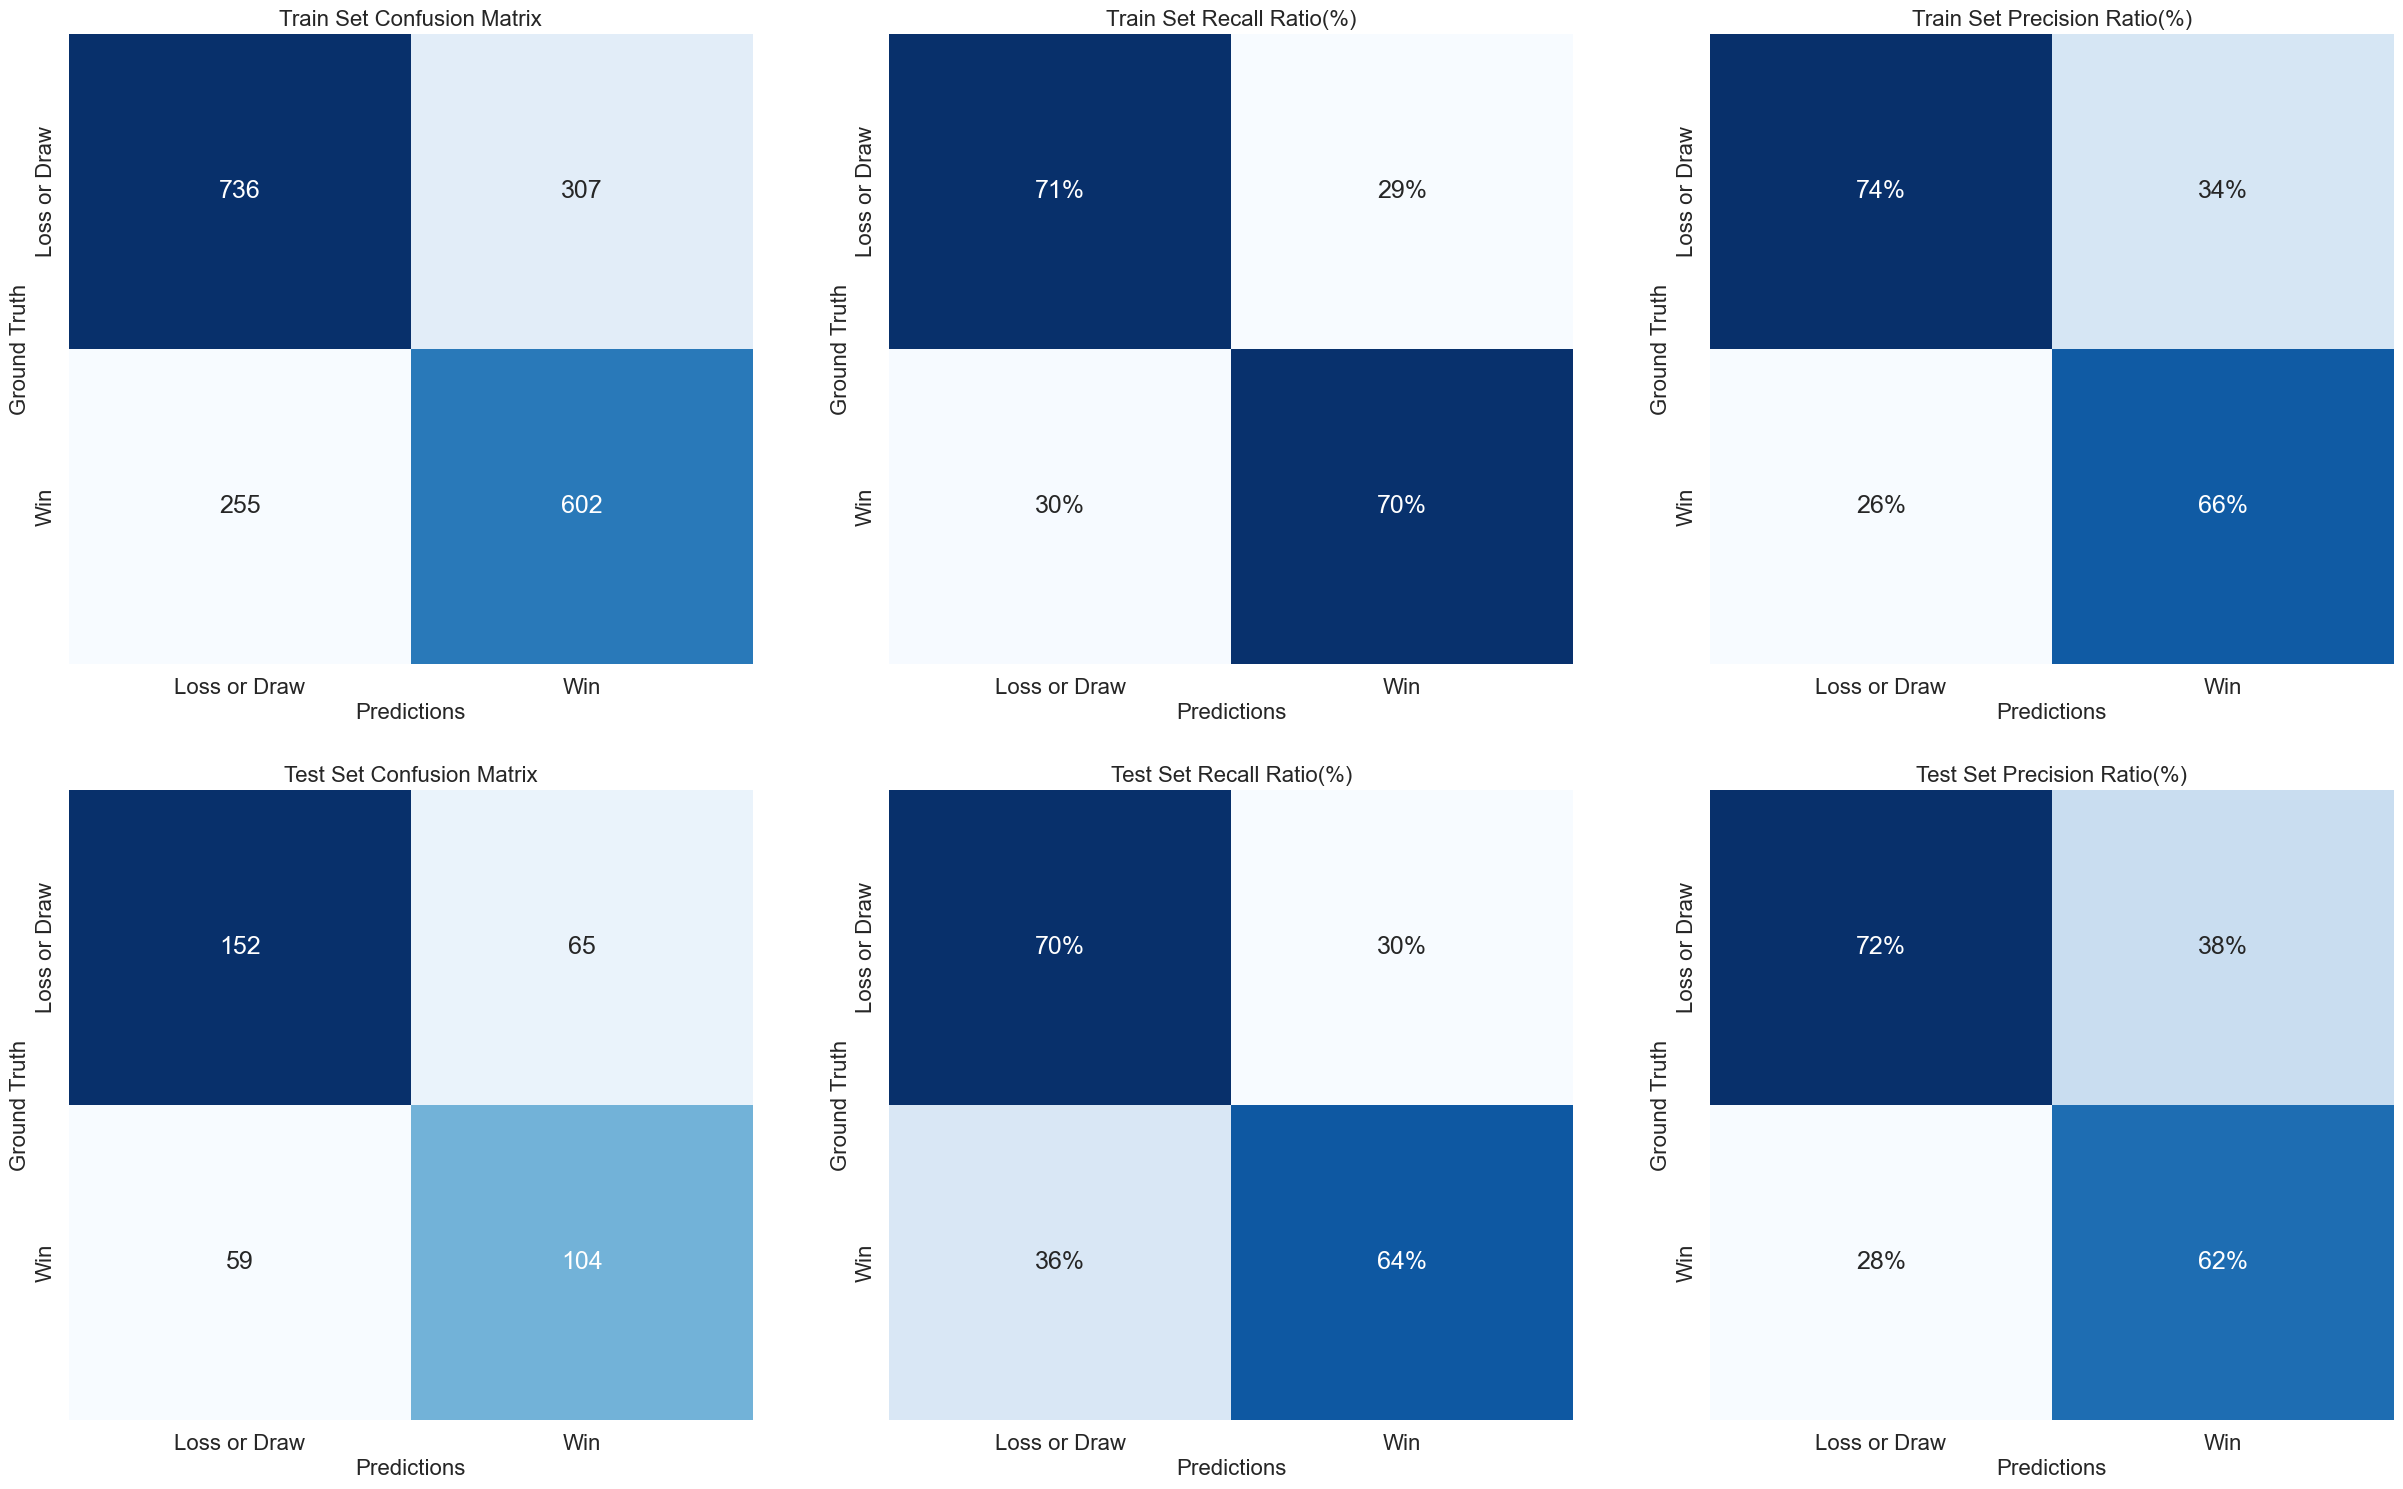

In [34]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = svm_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test)

In [35]:
# Calling the function to evaluate the performance of the classifier
svm_model_summary_df = evaluate_model_performance(model = svm_model, 
                                                  train_features = X_train, 
                                                  train_labels = y_train, 
                                                  test_features = X_test, 
                                                  test_labels = y_test,
                                                  algorithm_name = 'Support Vector Machine')
svm_model_summary_df

Train Balanced Accuracy  Test Balanced Accuracy  \
Support Vector Machine                      0.7                    0.67   

                        Accuracy  Precision  Recall  F0.5   AUC  \
Support Vector Machine      0.67       0.62    0.64  0.62  0.71   

                        Brier Score Loss  Train Threshold  Test Threshold  
Support Vector Machine              0.21             0.42            0.43

***
### K Nearest Neighbors

In [36]:
# Building a classifier
knn_model = build_pipeline(classifier = KNeighborsClassifier(), 
                           data_frame = df, 
                           train_features = X_train, 
                           train_labels = y_train, 
                           apply_bayesian_optimization = False, 
                           scaler_type = 'maxabs',
                           drop_high_vif_features = False,
                           feature_selection_method = 'mutual_info')

# Logging information to the log file
logging.info(msg = 'K Nearest Neighbors model has been built')

# Displaying the architecture of the classifier
knn_model

Pipeline(steps=[('feature_reallocator', FeatureReallocator()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('binary_pipeline',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['is_boxing_day',
                                                   'finished_top_4_last_season_h',
                                                   'finished_top_4_last_season_a',
                                                   'won_carabao_cup_last_seaso...
                                                   'total_avg_shots_on_target_last_3_h',
                                                   'total_avg_shots_on_target_last_3_a',
                                                   'total_avg_shots_on_target_last_5_h',
                                                   'total_avg_shots_on_target_last_5_a',
                                                   'total_avg_shots_h',
                                                   'total_avg_shots_a',
                                                   'total_avg_shots_last_3_h',
                                                   'total_avg_shots_last_3_a',
                                                   'total_avg_shots_last_5_h',
                                                   'total_avg_shots_last_5_a', ...])])),
                ('feature_selector', SelectPercentile()),
                ('classifier', KNeighborsClassifier())])

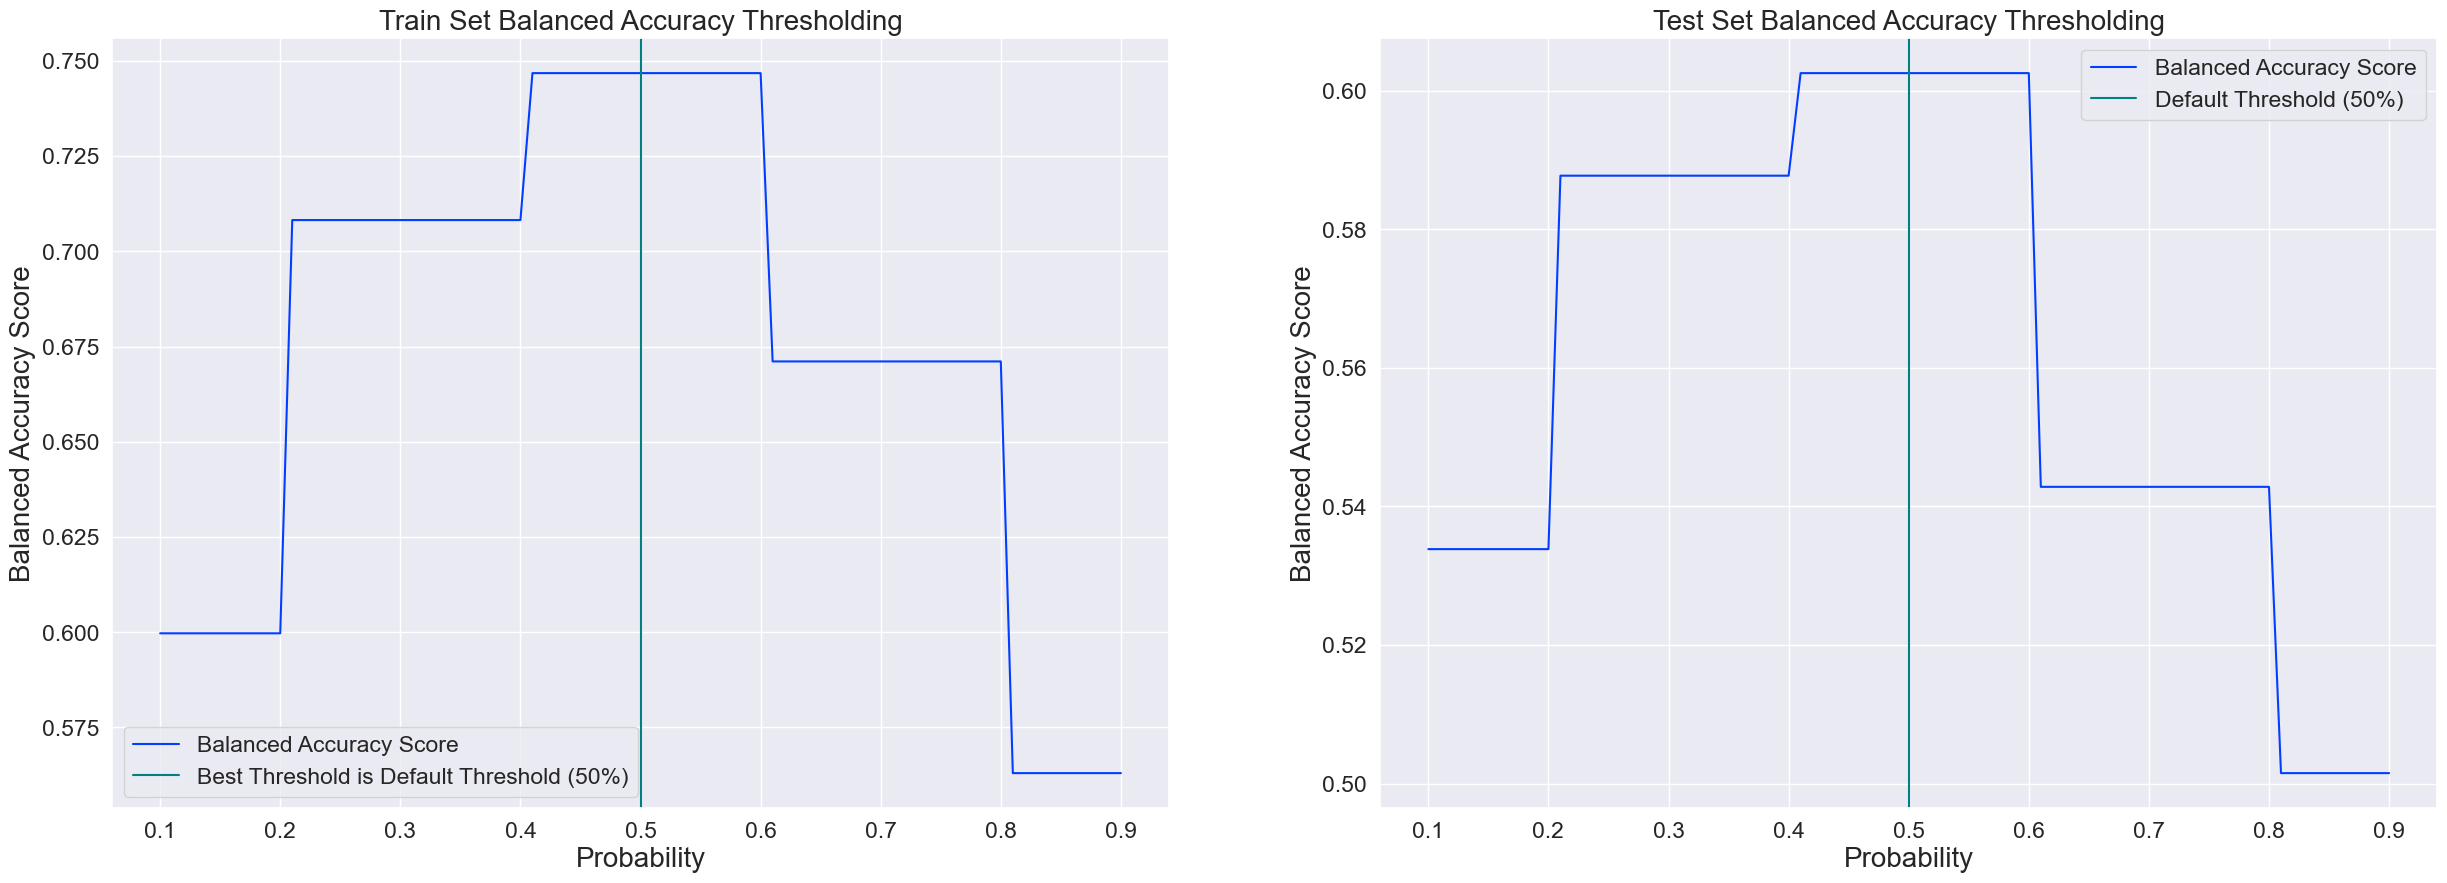

In [37]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = knn_model, 
                                                         metric = 'balanced_accuracy', 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [38]:
# Calling the function to print out the classification report
print_classification_report(model = knn_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            algorithm_name = 'K Nearest Neighbors')

Classification Report Summary for K Nearest Neighbors Model:

Train report:
              precision    recall  f1-score   support

Loss or Draw       0.76      0.81      0.78      1043
         Win       0.75      0.68      0.71       857

    accuracy                           0.75      1900
   macro avg       0.75      0.75      0.75      1900
weighted avg       0.75      0.75      0.75      1900



Test report:
              precision    recall  f1-score   support

Loss or Draw       0.65      0.71      0.68       217
         Win       0.56      0.49      0.52       163

    accuracy                           0.62       380
   macro avg       0.61      0.60      0.60       380
weighted avg       0.61      0.62      0.61       380



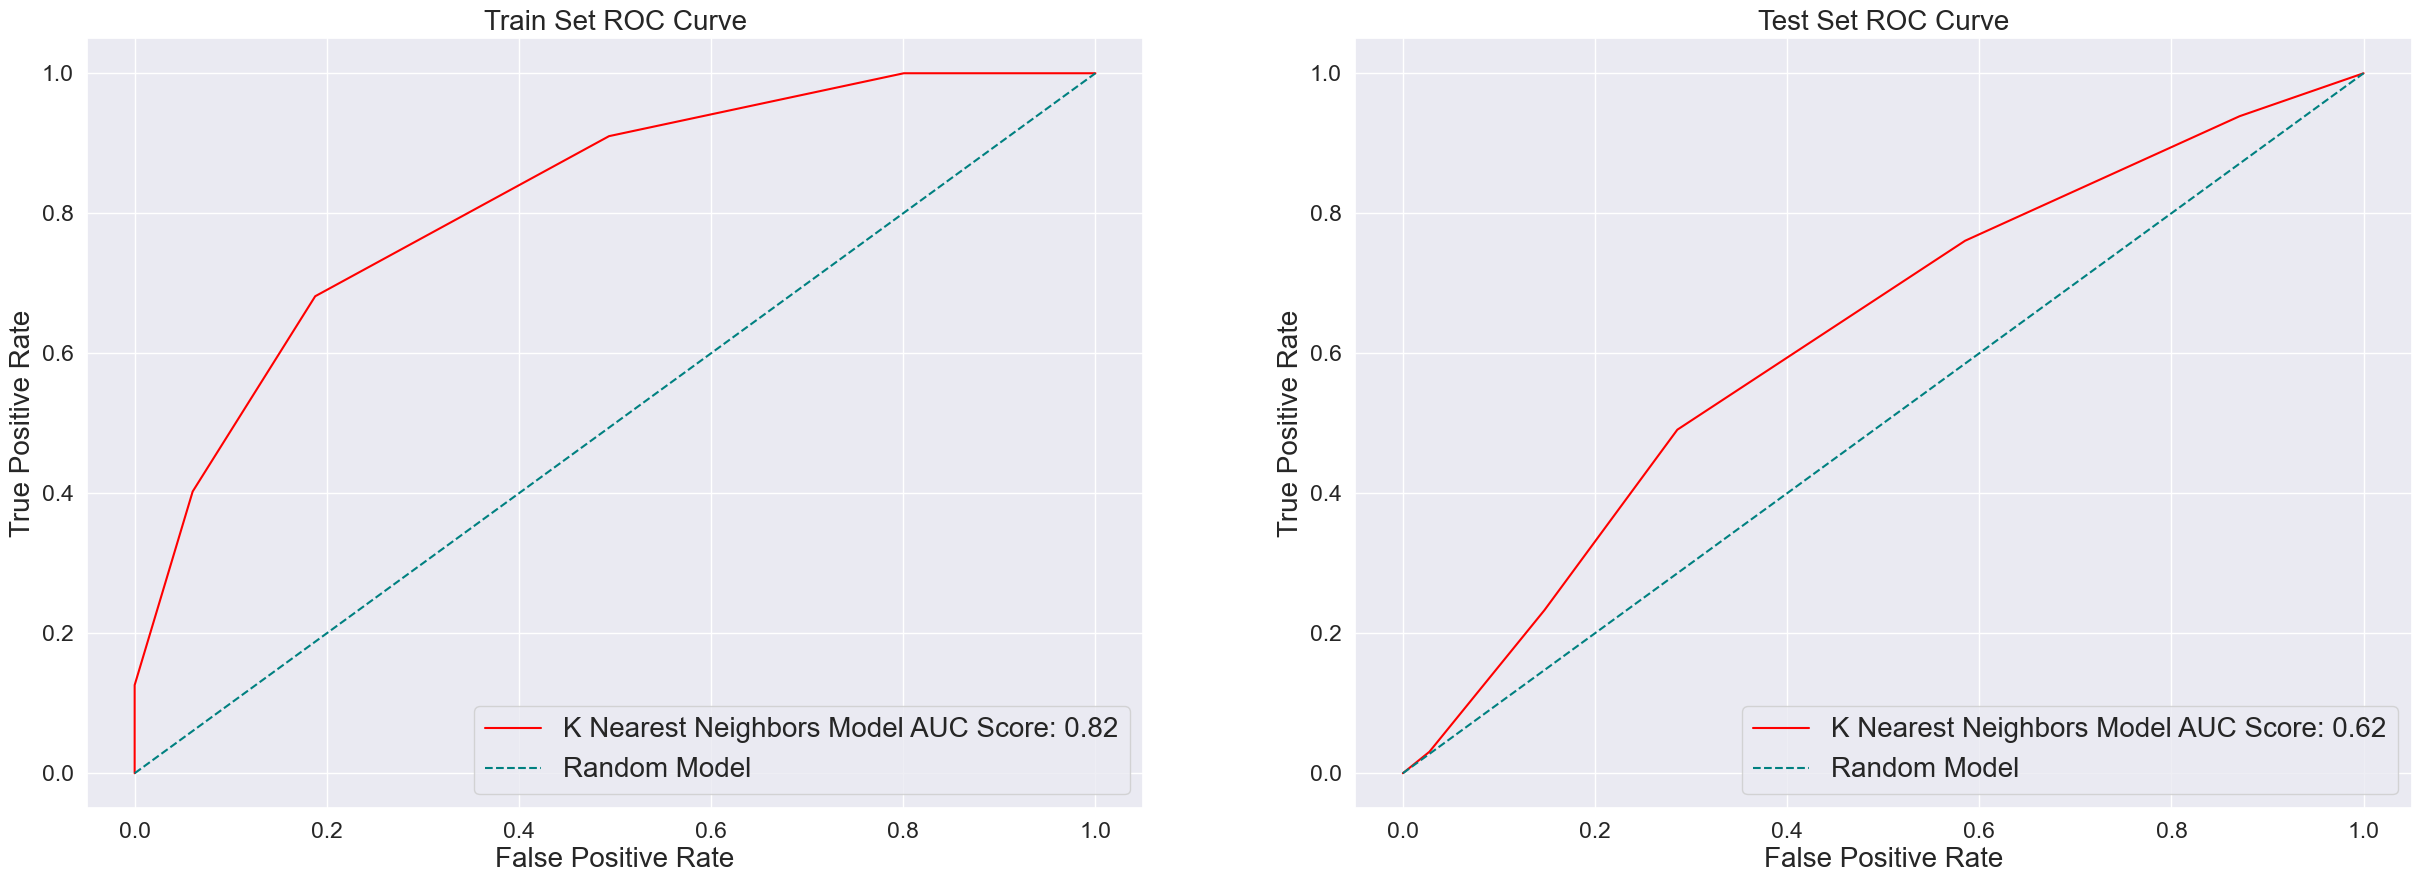

In [39]:
# Calling the function to plot ROC curve
plot_roc_curve(model = knn_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = 'K Nearest Neighbors')

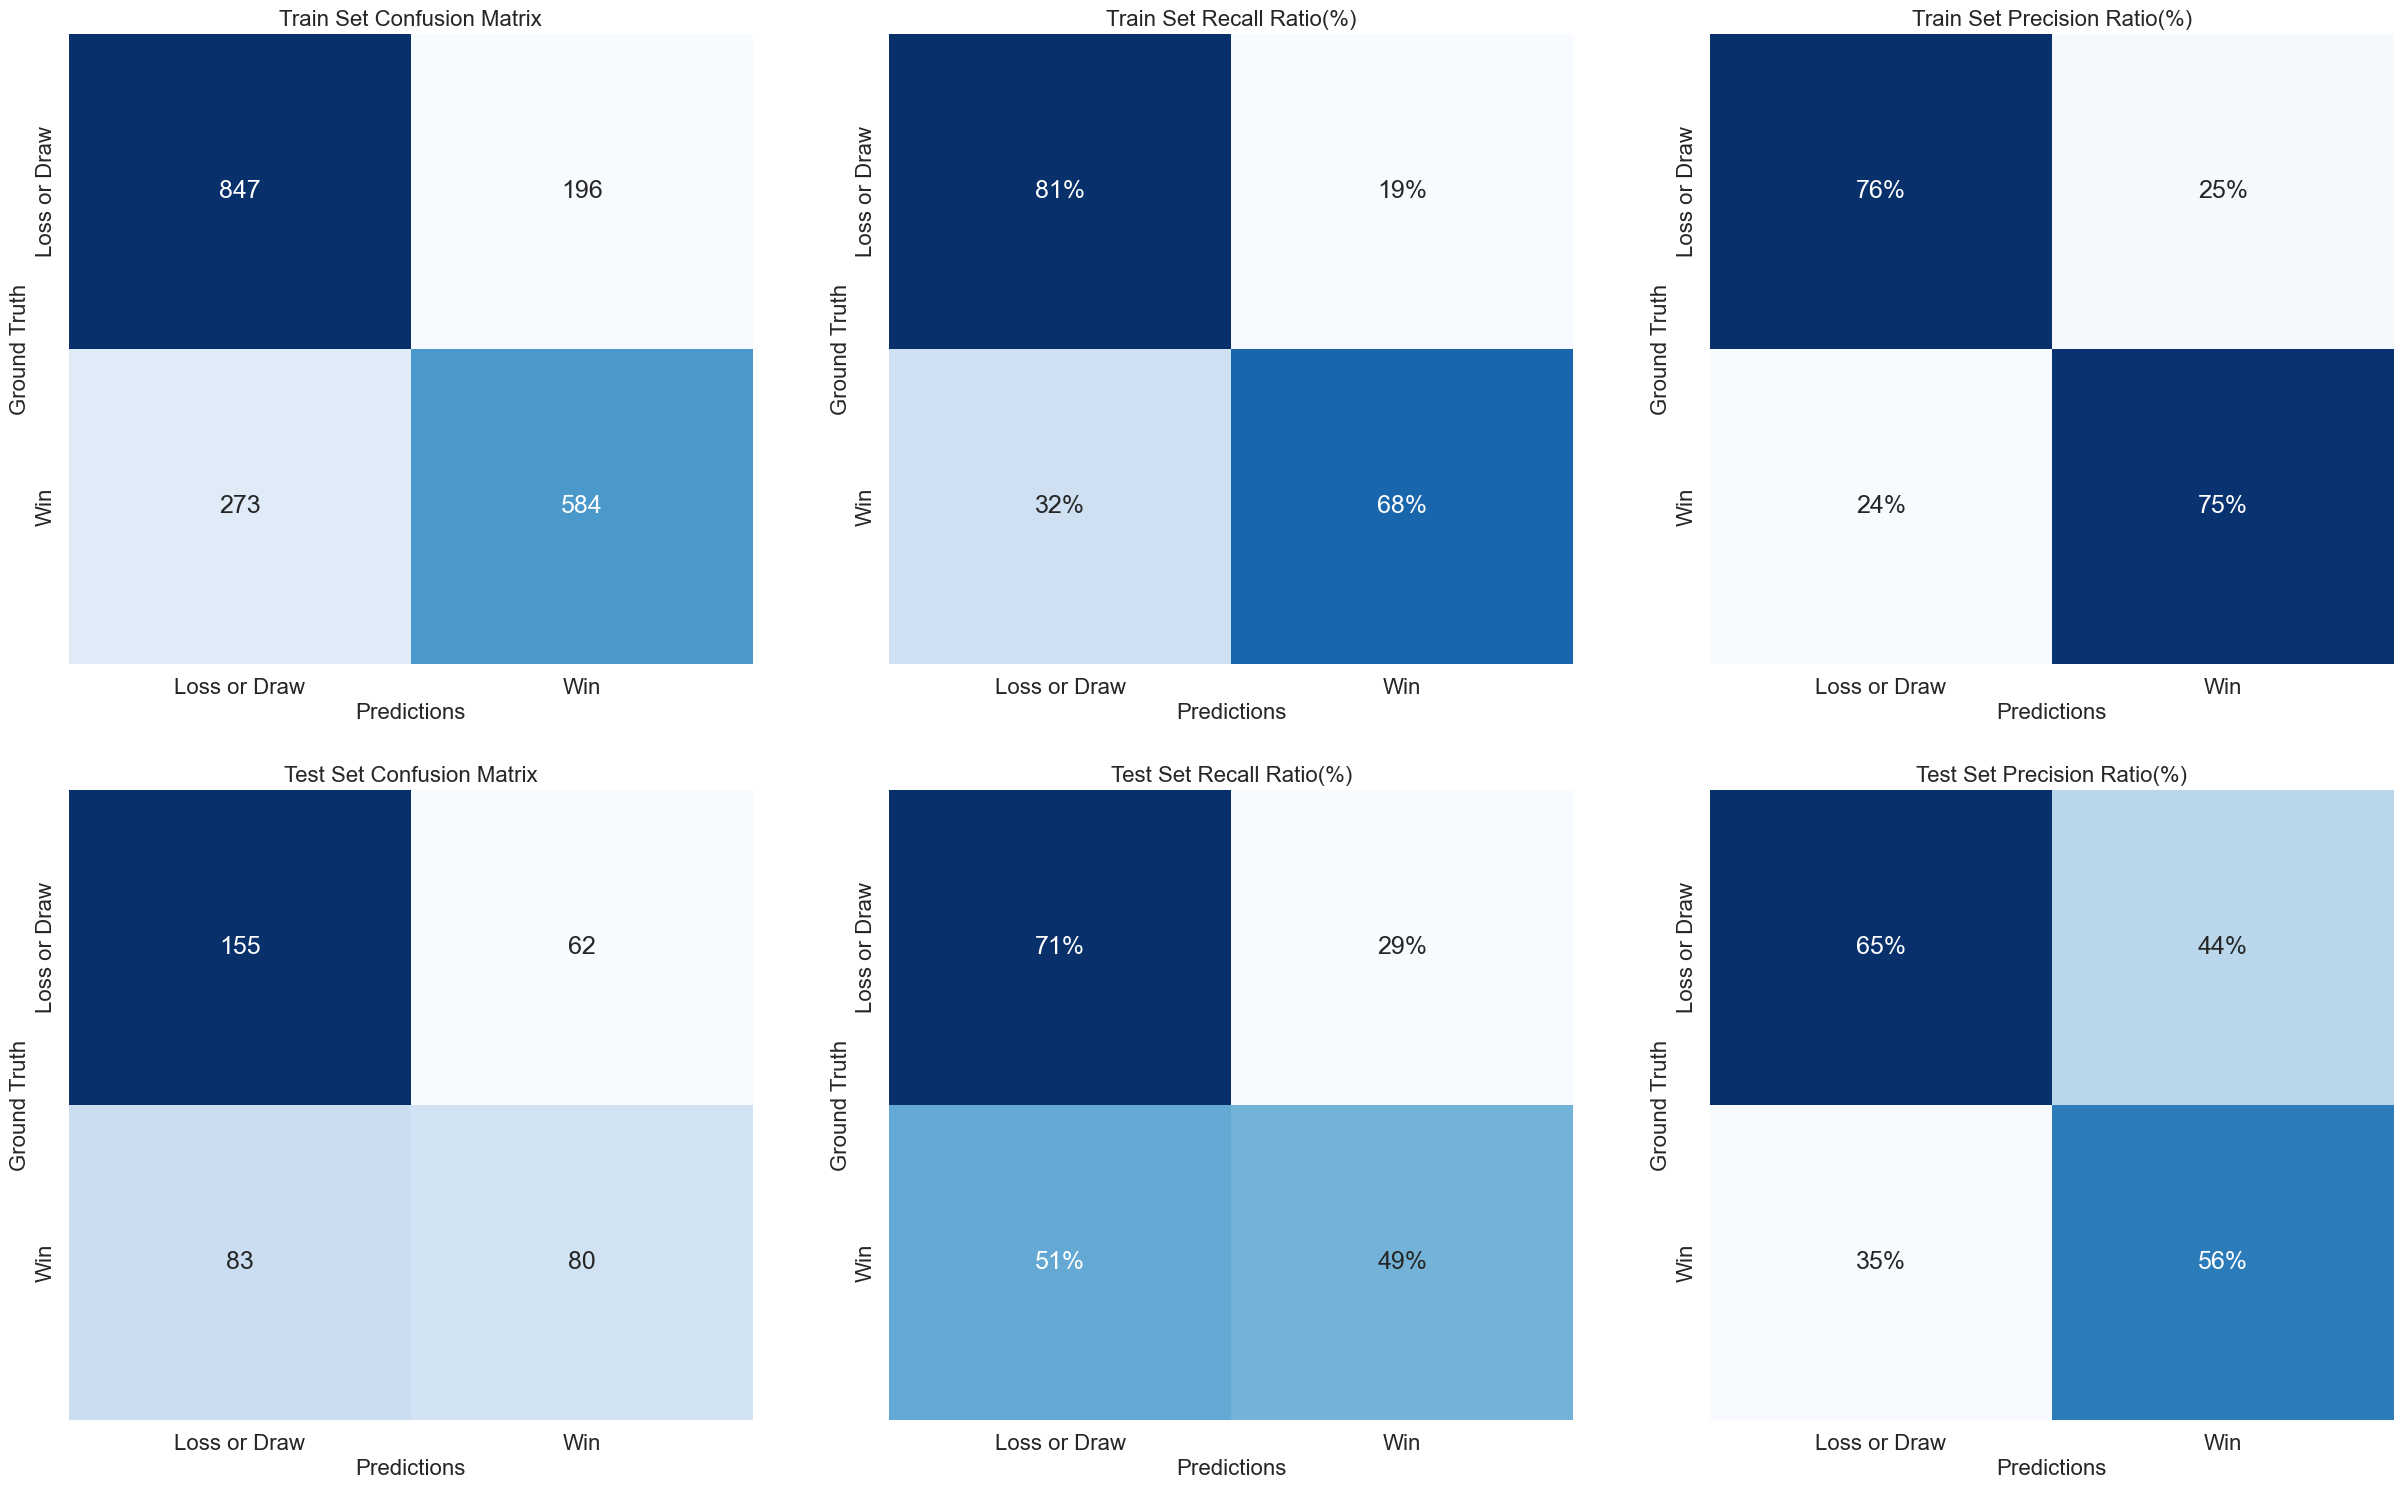

In [40]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = knn_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test)

In [41]:
# Calling the function to evaluate the performance of the classifier
knn_model_summary_df = evaluate_model_performance(model = knn_model, 
                                                  train_features = X_train, 
                                                  train_labels = y_train, 
                                                  test_features = X_test, 
                                                  test_labels = y_test,
                                                  algorithm_name = 'K Nearest Neighbors')
knn_model_summary_df

Train Balanced Accuracy  Test Balanced Accuracy  \
K Nearest Neighbors                     0.75                     0.6   

                     Accuracy  Precision  Recall  F0.5   AUC  \
K Nearest Neighbors      0.62       0.56    0.49  0.54  0.62   

                     Brier Score Loss  Train Threshold  Test Threshold  
K Nearest Neighbors              0.26              0.5             0.5

***
### Multi Layer Perceptron

In [42]:
# Building a classifier
mlp_model = build_pipeline(classifier = MLPClassifier(learning_rate = 'adaptive', shuffle = False, random_state = 42, early_stopping = True, n_iter_no_change = 3),  
                           data_frame = df, 
                           train_features = X_train, 
                           train_labels = y_train, 
                           apply_bayesian_optimization = False, 
                           scaler_type = 'standard',
                           drop_high_vif_features = False,
                           feature_selection_method = 'wrapper')

# Logging information to the log file
logging.info(msg = 'Multi Layer Perceptron model has been built')

# Displaying the architecture of the classifier
mlp_model

Pipeline(steps=[('feature_reallocator', FeatureReallocator()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('binary_pipeline',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['is_boxing_day',
                                                   'finished_top_4_last_season_h',
                                                   'finished_top_4_last_season_a',
                                                   'won_carabao_cup_last_seaso...
                 SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                                           estimator=MLPClassifier(early_stopping=True,
                                                                   learning_rate='adaptive',
                                                                   n_iter_no_change=3,
                                                                   random_state=42,
                                                                   shuffle=False),
                                           n_jobs=-1,
                                           scoring='balanced_accuracy')),
                ('classifier',
                 MLPClassifier(early_stopping=True, learning_rate='adaptive',
                               n_iter_no_change=3, random_state=42,
                               shuffle=False))])

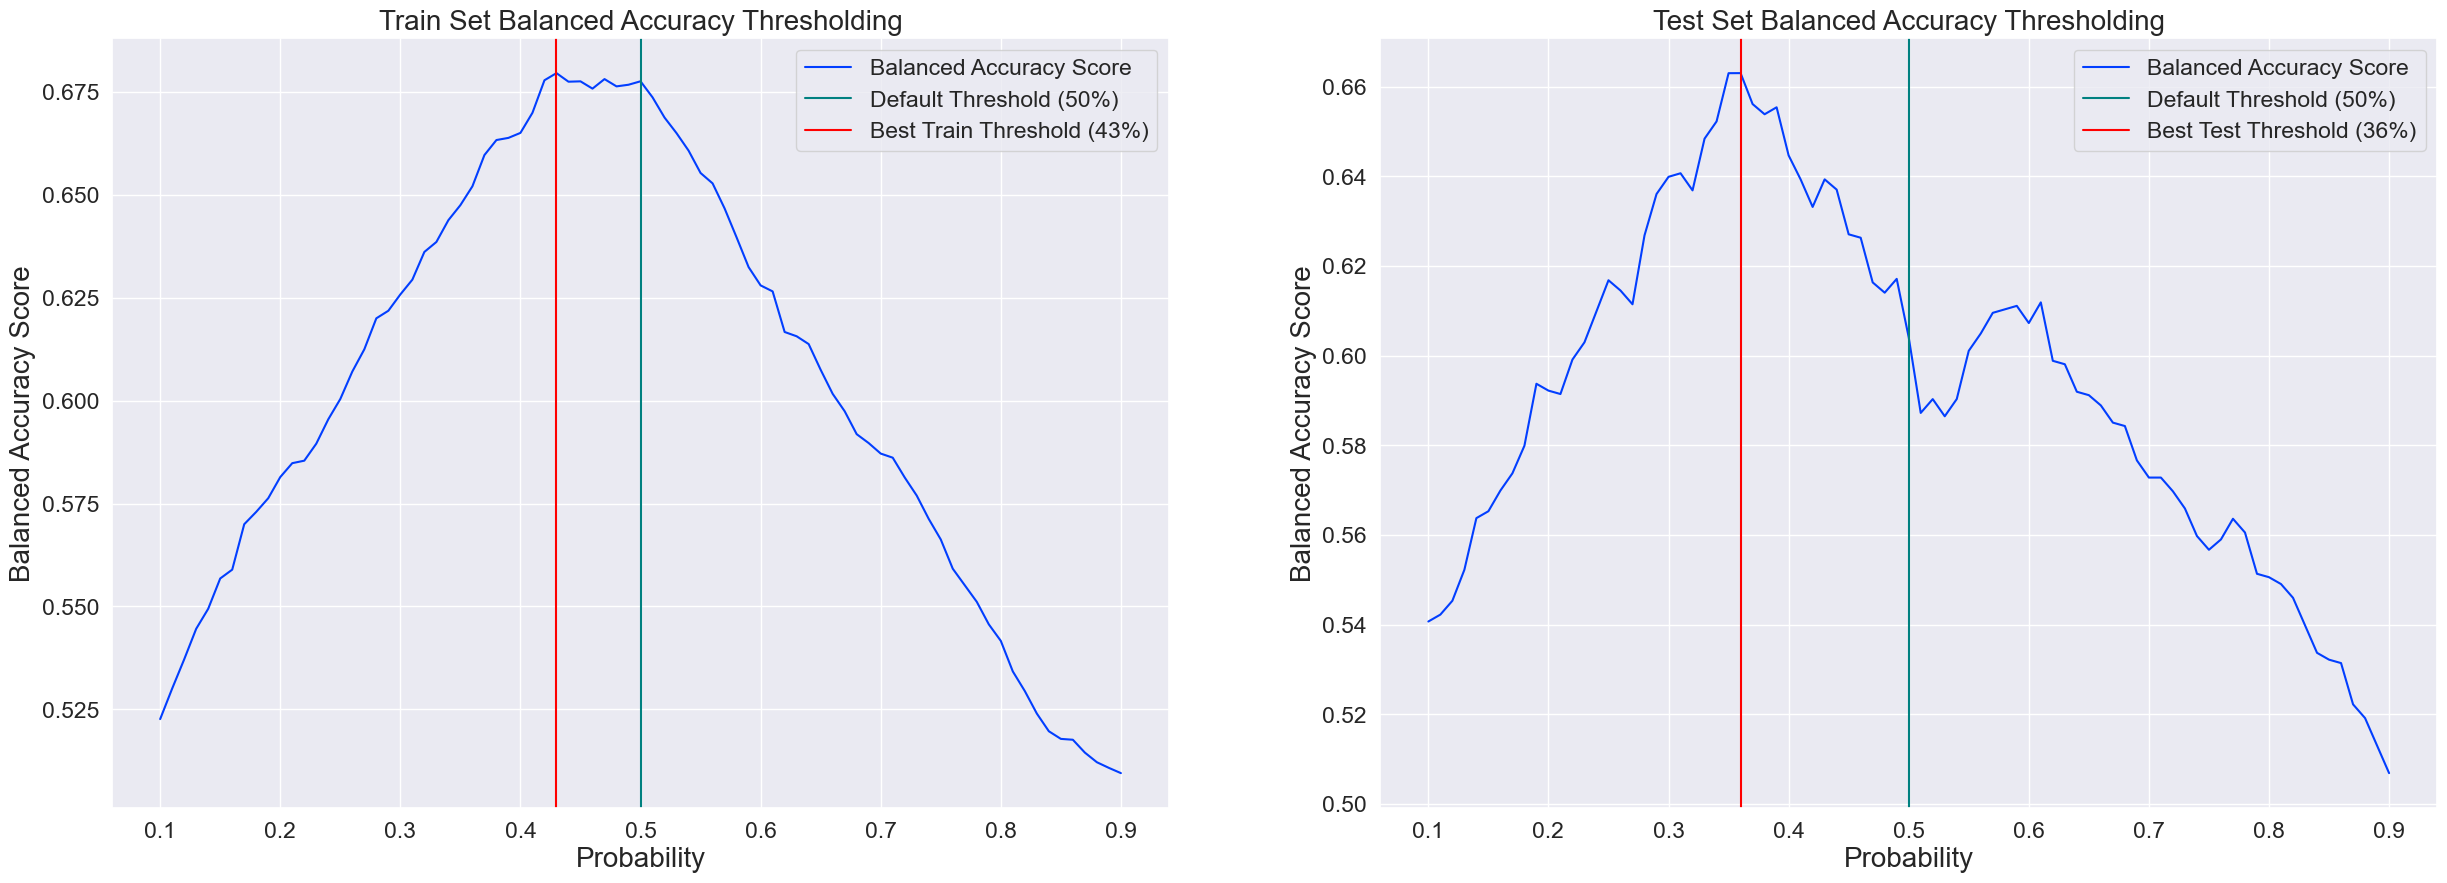

In [43]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = mlp_model, 
                                                         metric = 'balanced_accuracy', 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [44]:
# Calling the function to print out the classification report
print_classification_report(model = mlp_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            algorithm_name = 'Multi Layer Perceptron')

Classification Report Summary for Multi Layer Perceptron Model:

Train report:
              precision    recall  f1-score   support

Loss or Draw       0.72      0.68      0.70      1043
         Win       0.64      0.67      0.66       857

    accuracy                           0.68      1900
   macro avg       0.68      0.68      0.68      1900
weighted avg       0.68      0.68      0.68      1900



Test report:
              precision    recall  f1-score   support

Loss or Draw       0.76      0.57      0.65       217
         Win       0.57      0.75      0.65       163

    accuracy                           0.65       380
   macro avg       0.66      0.66      0.65       380
weighted avg       0.68      0.65      0.65       380



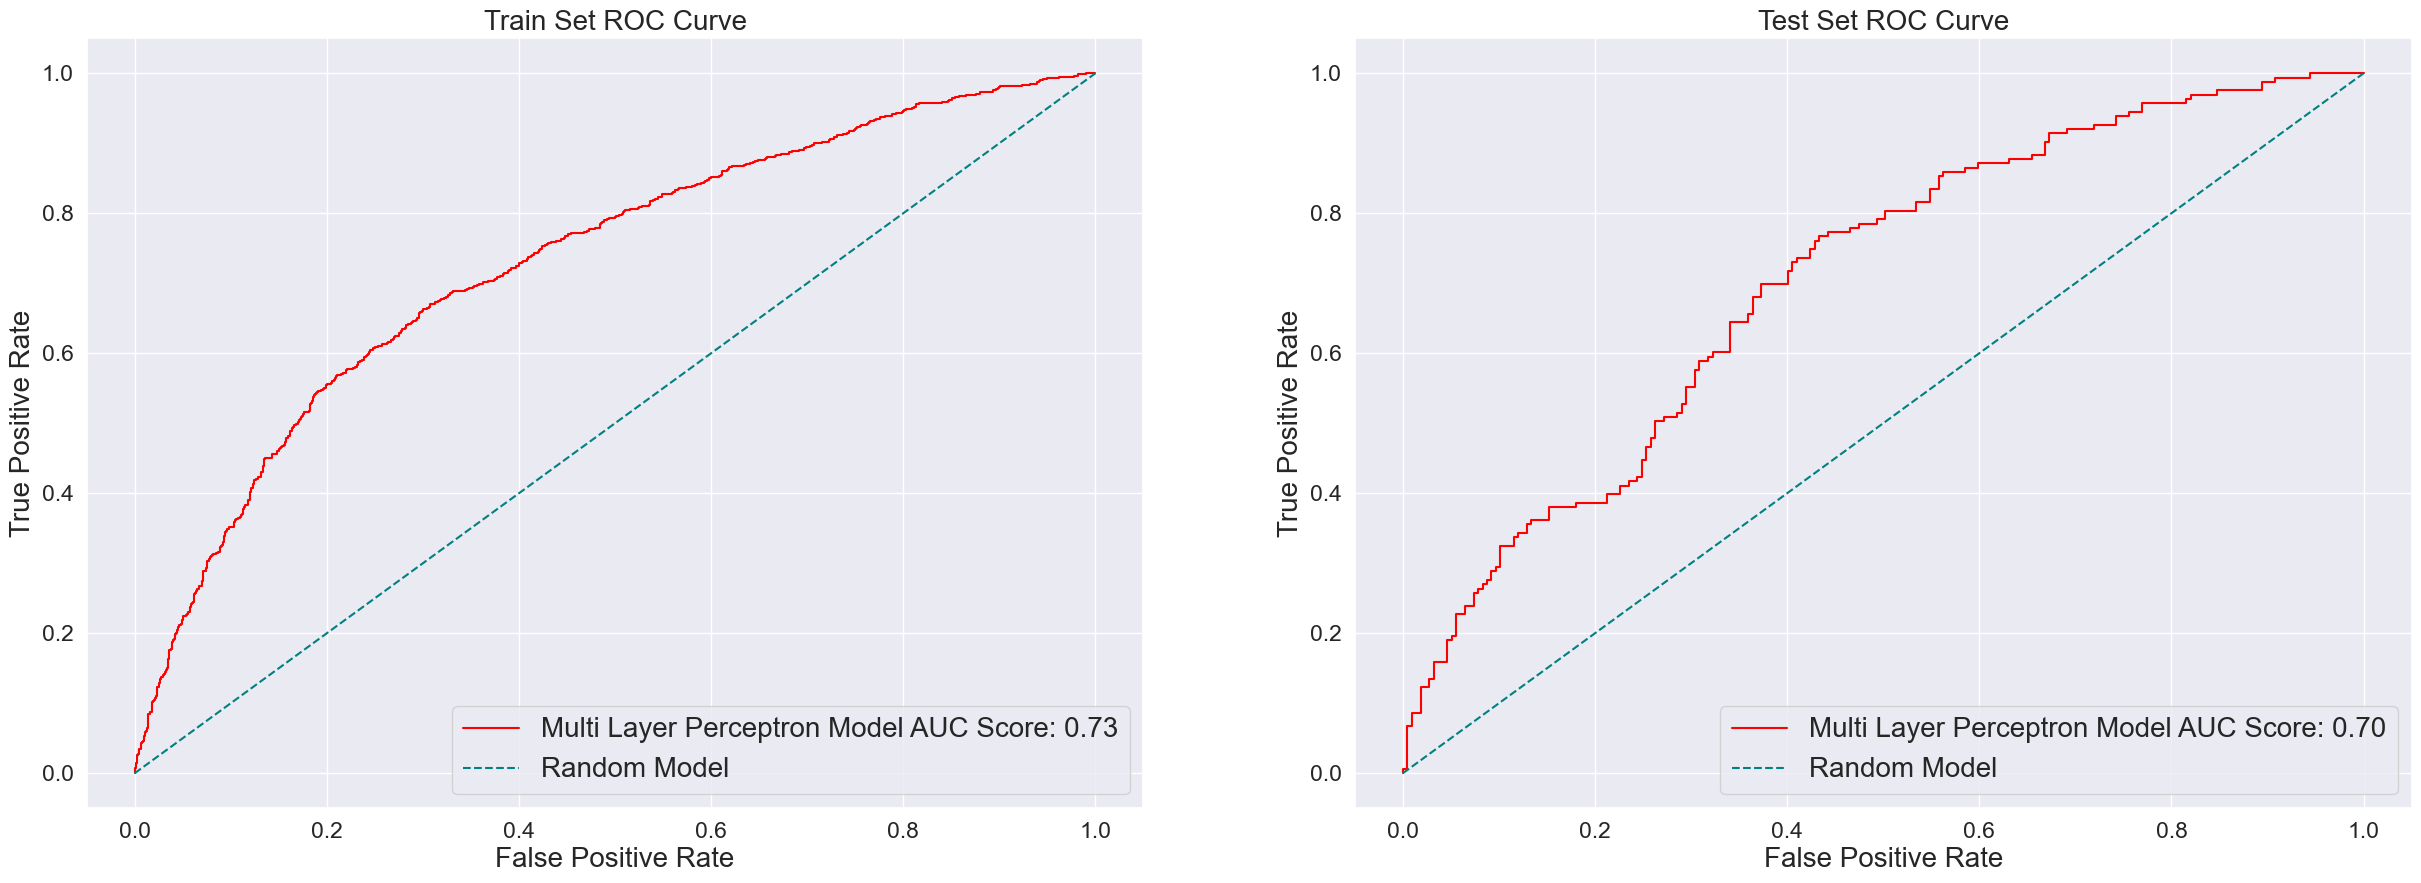

In [45]:
# Calling the function to plot ROC curve
plot_roc_curve(model = mlp_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = 'Multi Layer Perceptron')

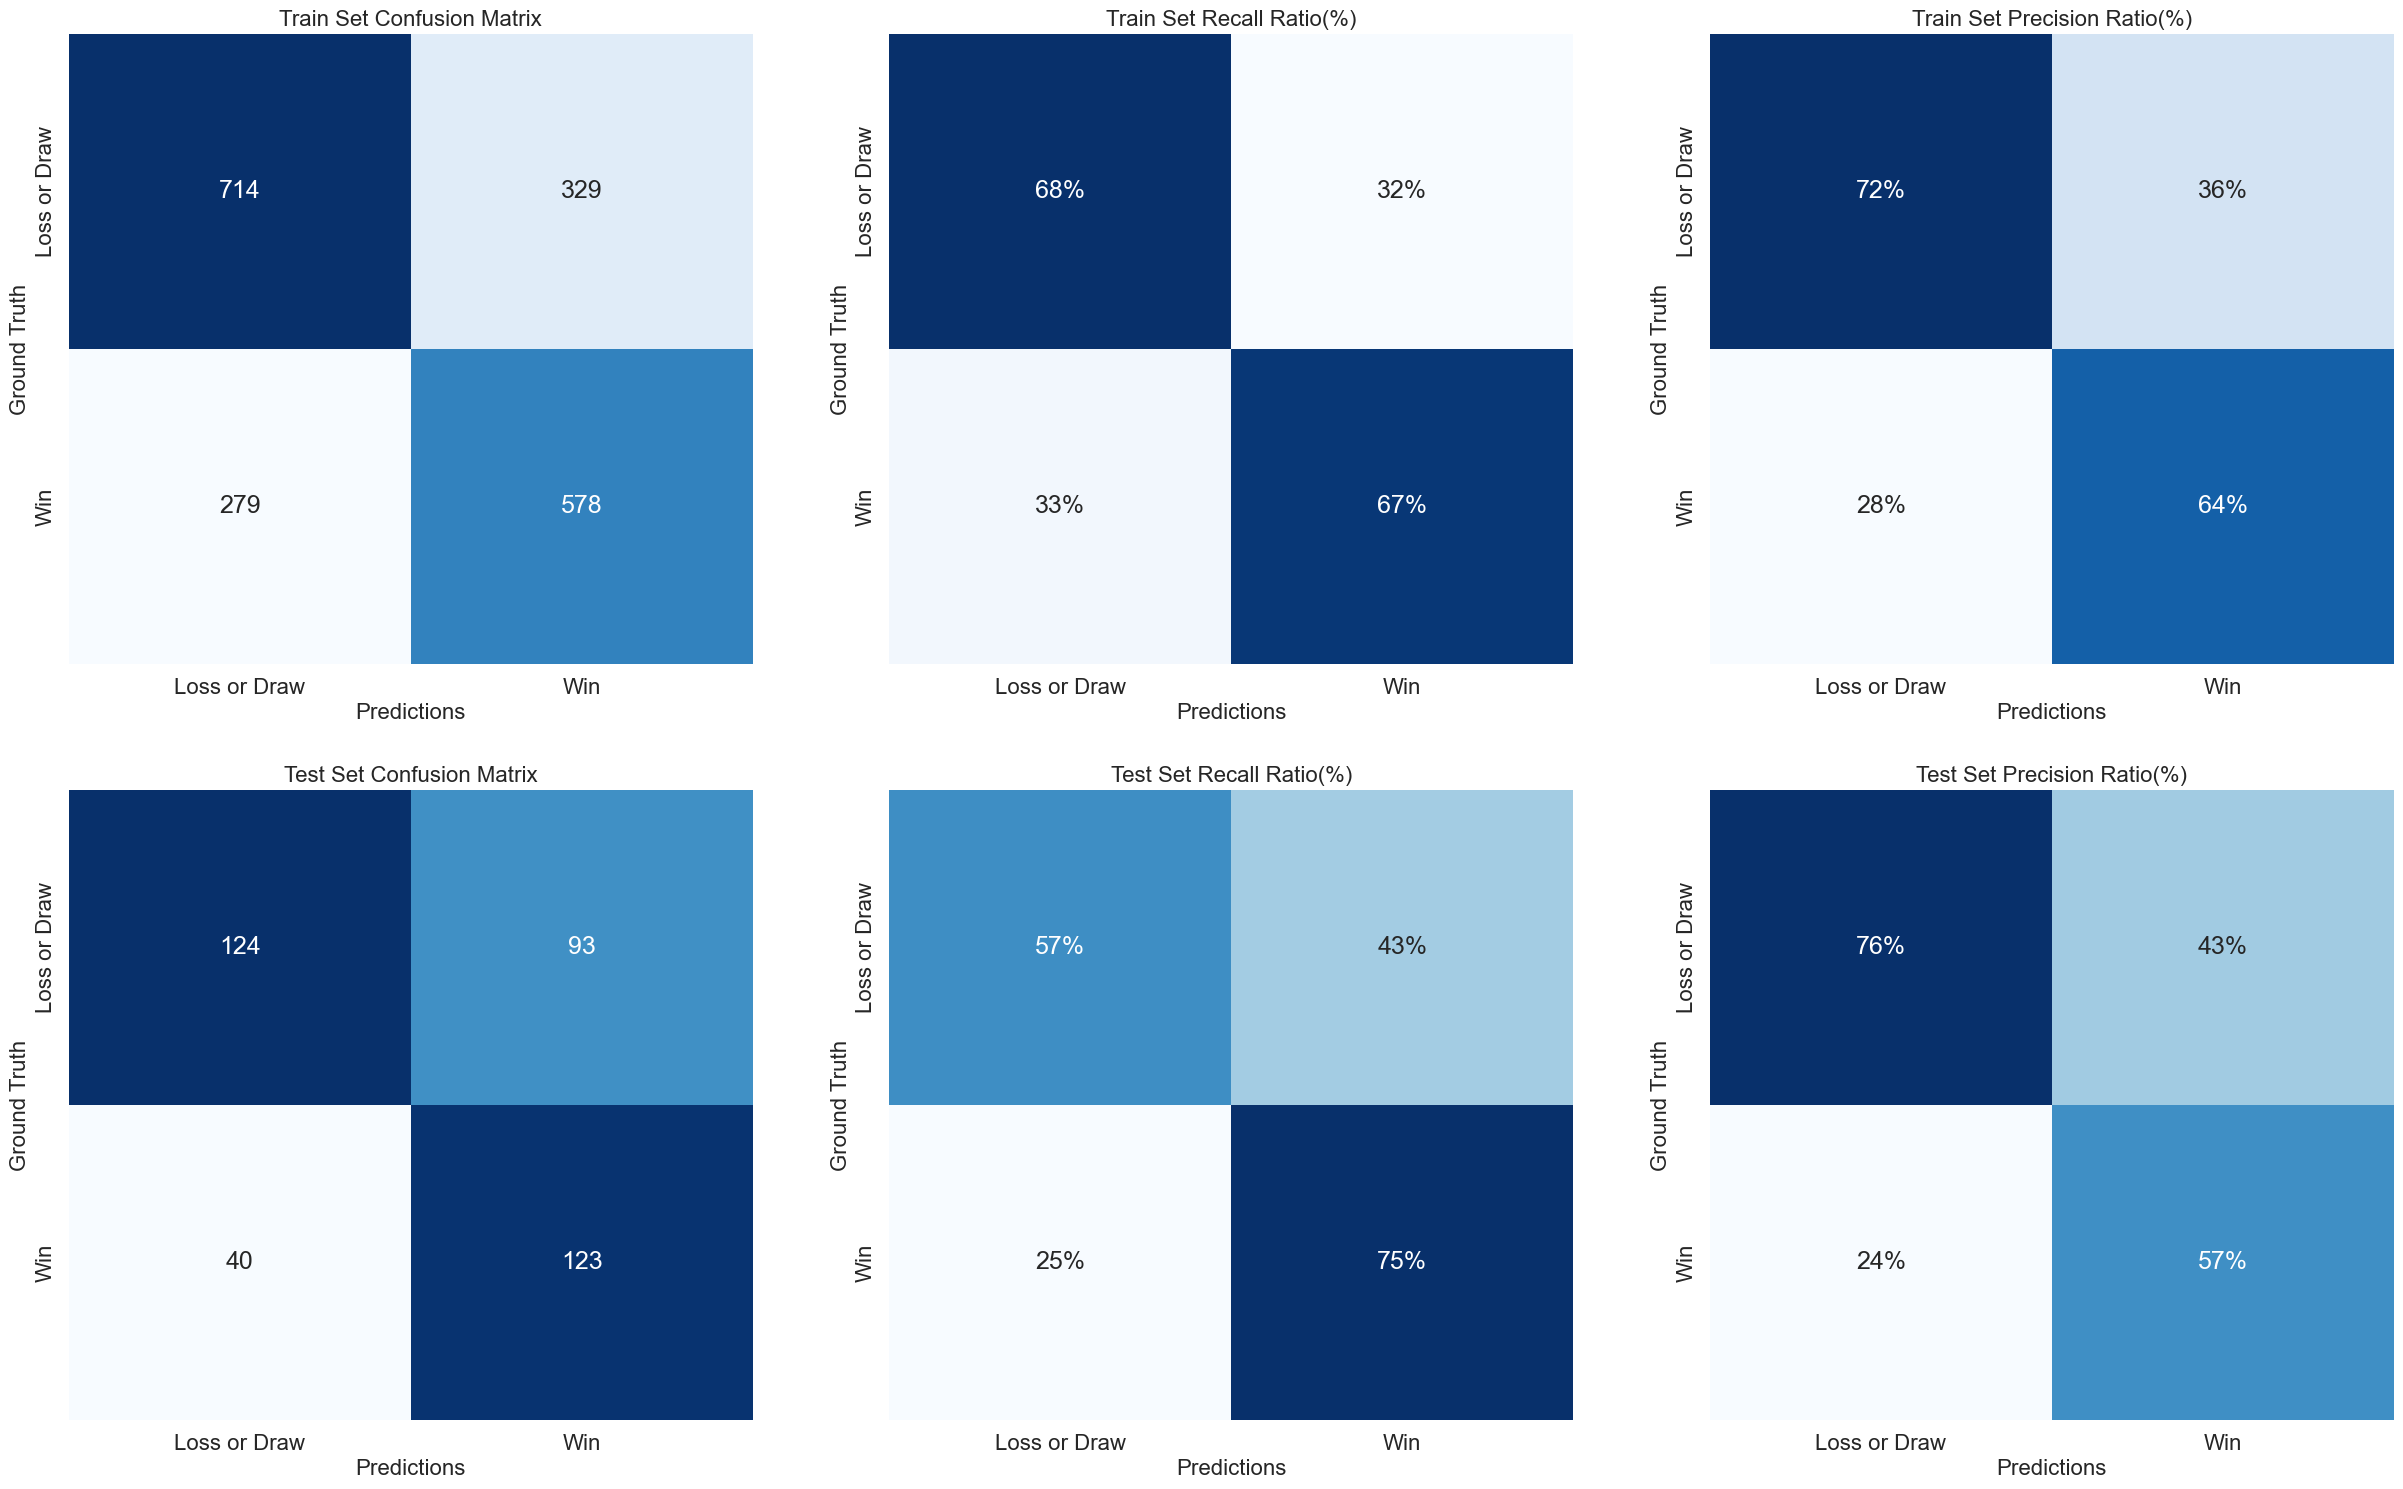

In [46]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = mlp_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test)

In [47]:
# Calling the function to evaluate the performance of the classifier
mlp_model_summary_df = evaluate_model_performance(model = mlp_model, 
                                                  train_features = X_train, 
                                                  train_labels = y_train, 
                                                  test_features = X_test, 
                                                  test_labels = y_test,
                                                  algorithm_name = 'Multi Layer Perceptron')
mlp_model_summary_df

Train Balanced Accuracy  Test Balanced Accuracy  \
Multi Layer Perceptron                     0.68                    0.66   

                        Accuracy  Precision  Recall  F0.5  AUC  \
Multi Layer Perceptron      0.65       0.57    0.75   0.6  0.7   

                        Brier Score Loss  Train Threshold  Test Threshold  
Multi Layer Perceptron              0.22             0.43            0.36

***
### Decision Tree

In [48]:
# Building a classifier
dt_model = build_pipeline(classifier = DecisionTreeClassifier(random_state = 42),  
                          data_frame = df, 
                          train_features = X_train, 
                          train_labels = y_train, 
                          apply_bayesian_optimization = False,
                          scale = False,
                          drop_high_vif_features = False,
                          feature_selection_method = 'hybrid')

# Logging information to the log file
logging.info(msg = 'Decision Tree model has been built')

# Displaying the architecture of the classifier
dt_model

Pipeline(steps=[('feature_reallocator', FeatureReallocator()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('binary_pipeline',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['is_boxing_day',
                                                   'finished_top_4_last_season_h',
                                                   'finished_top_4_last_season_a',
                                                   'won_carabao_cup_last_seaso...
                                                   'total_avg_shots_last_3_h',
                                                   'total_avg_shots_last_3_a',
                                                   'total_avg_shots_last_5_h',
                                                   'total_avg_shots_last_5_a', ...])])),
                ('feature_selector',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                       estimator=DecisionTreeClassifier(random_state=42),
                       n_jobs=-1, scoring='balanced_accuracy')),
                ('classifier', DecisionTreeClassifier(random_state=42))])

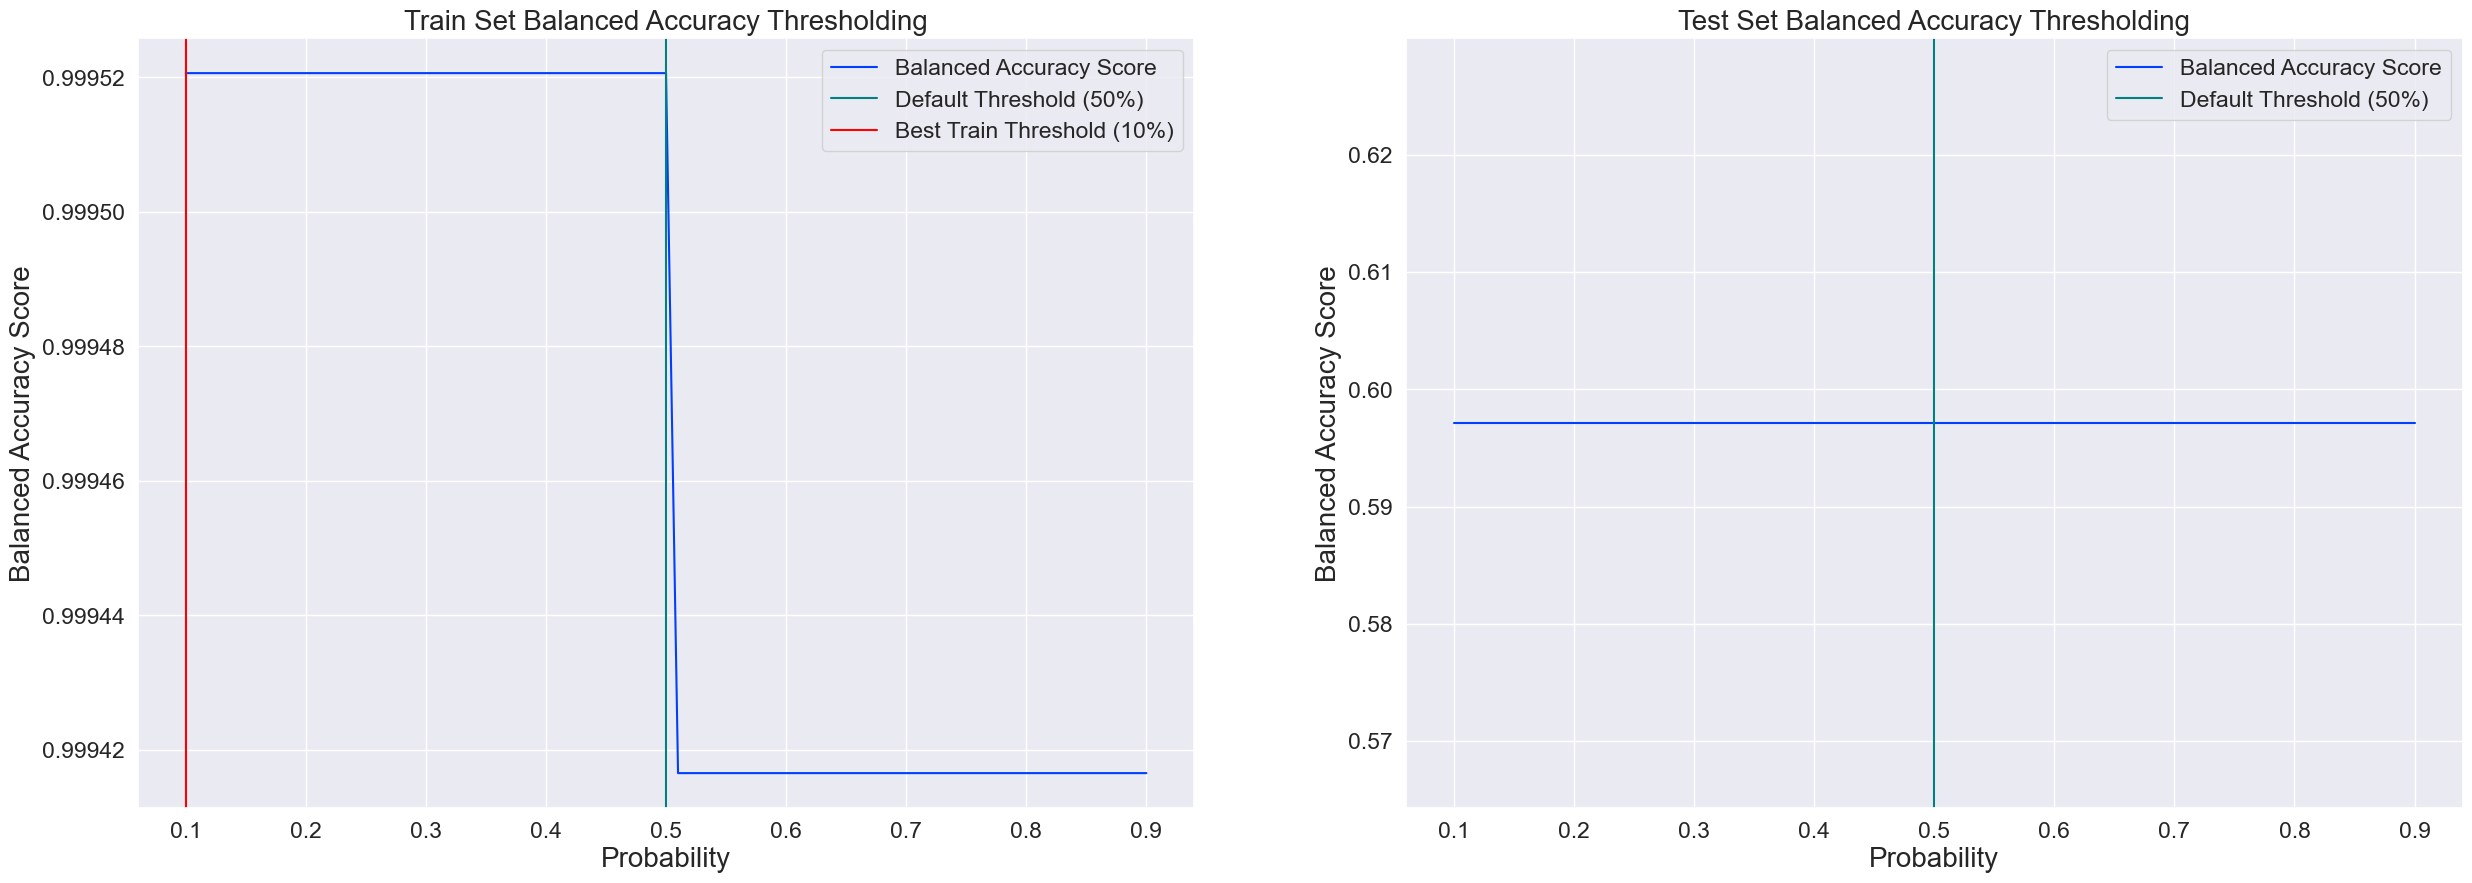

In [49]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = dt_model, 
                                                         metric = 'balanced_accuracy', 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [50]:
# Calling the function to print out the classification report
print_classification_report(model = dt_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            algorithm_name = 'Decision Tree')

Classification Report Summary for Decision Tree Model:

Train report:
              precision    recall  f1-score   support

Loss or Draw       1.00      1.00      1.00      1043
         Win       1.00      1.00      1.00       857

    accuracy                           1.00      1900
   macro avg       1.00      1.00      1.00      1900
weighted avg       1.00      1.00      1.00      1900



Test report:
              precision    recall  f1-score   support

Loss or Draw       0.66      0.64      0.65       217
         Win       0.54      0.56      0.55       163

    accuracy                           0.60       380
   macro avg       0.60      0.60      0.60       380
weighted avg       0.60      0.60      0.60       380



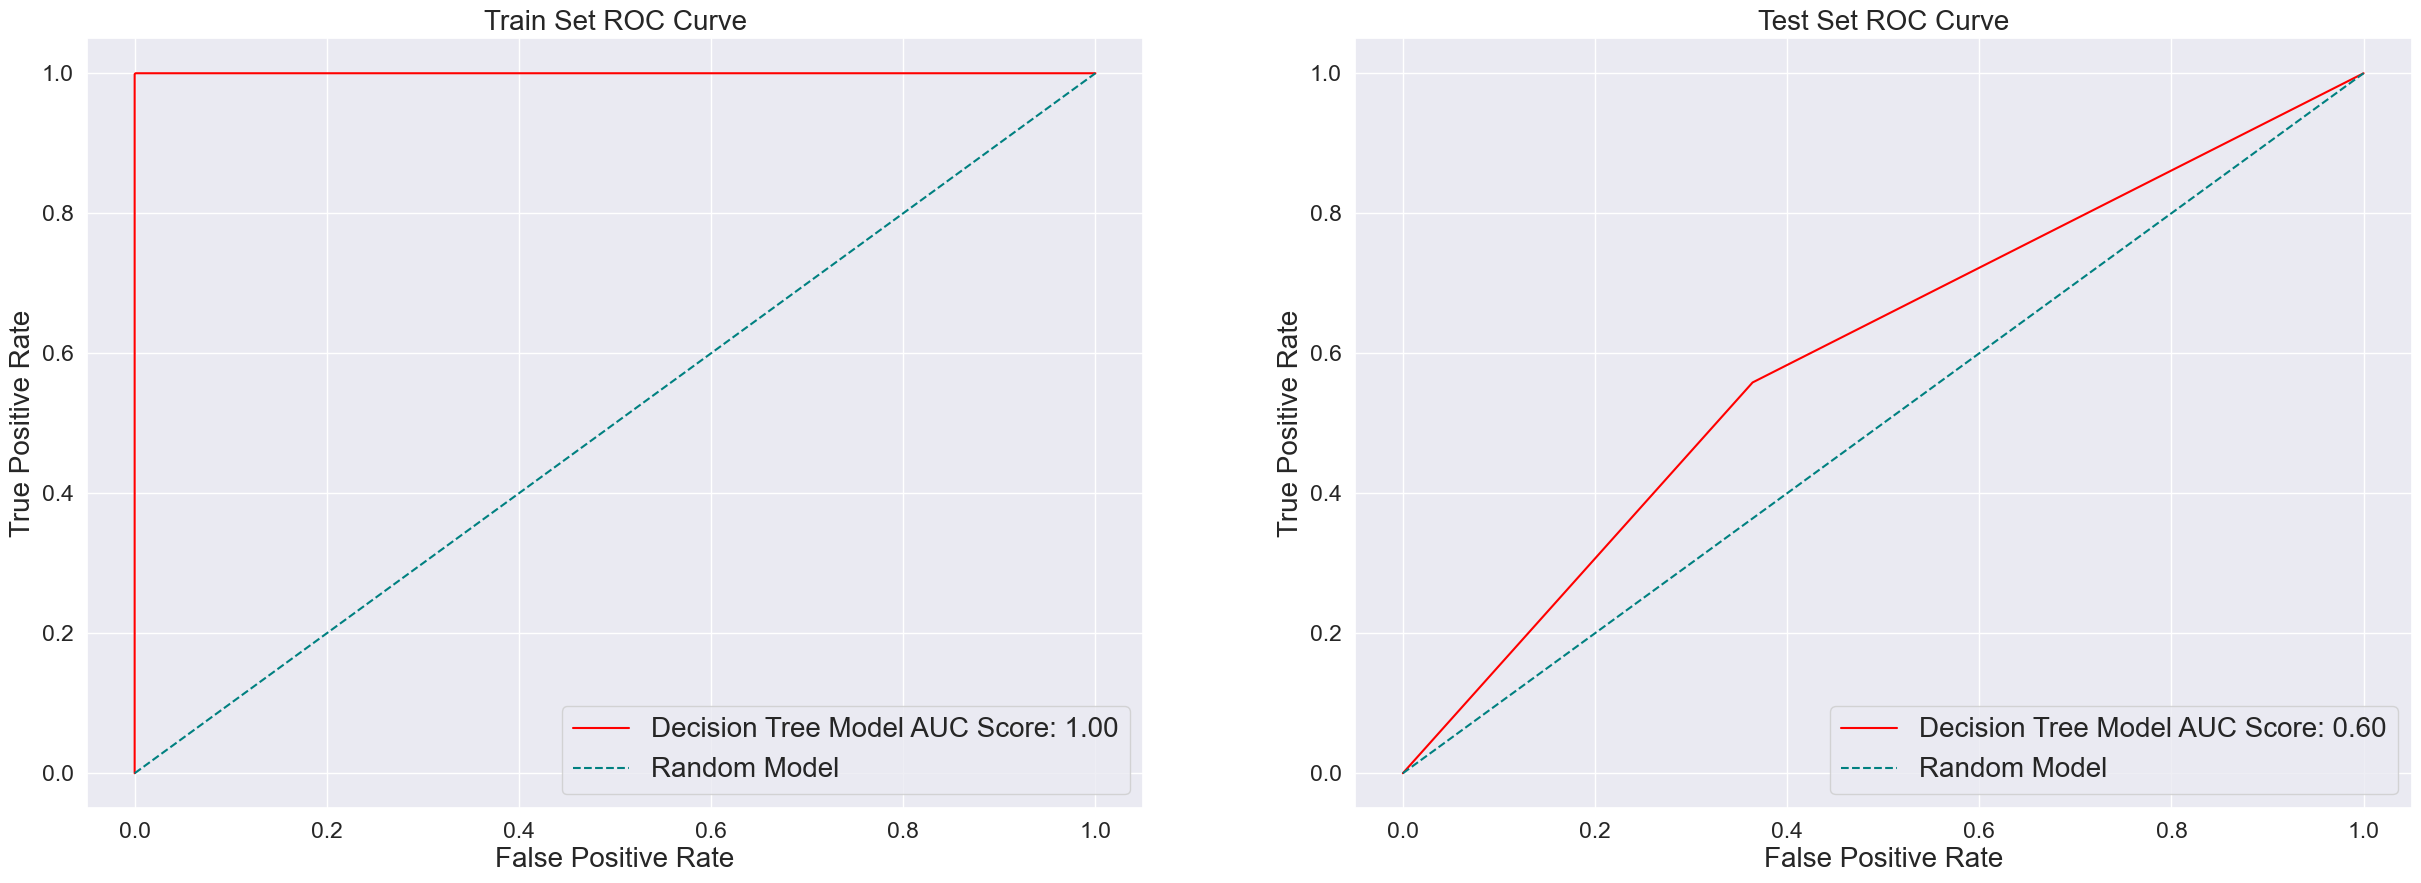

In [51]:
# Calling the function to plot ROC curve
plot_roc_curve(model = dt_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = 'Decision Tree')

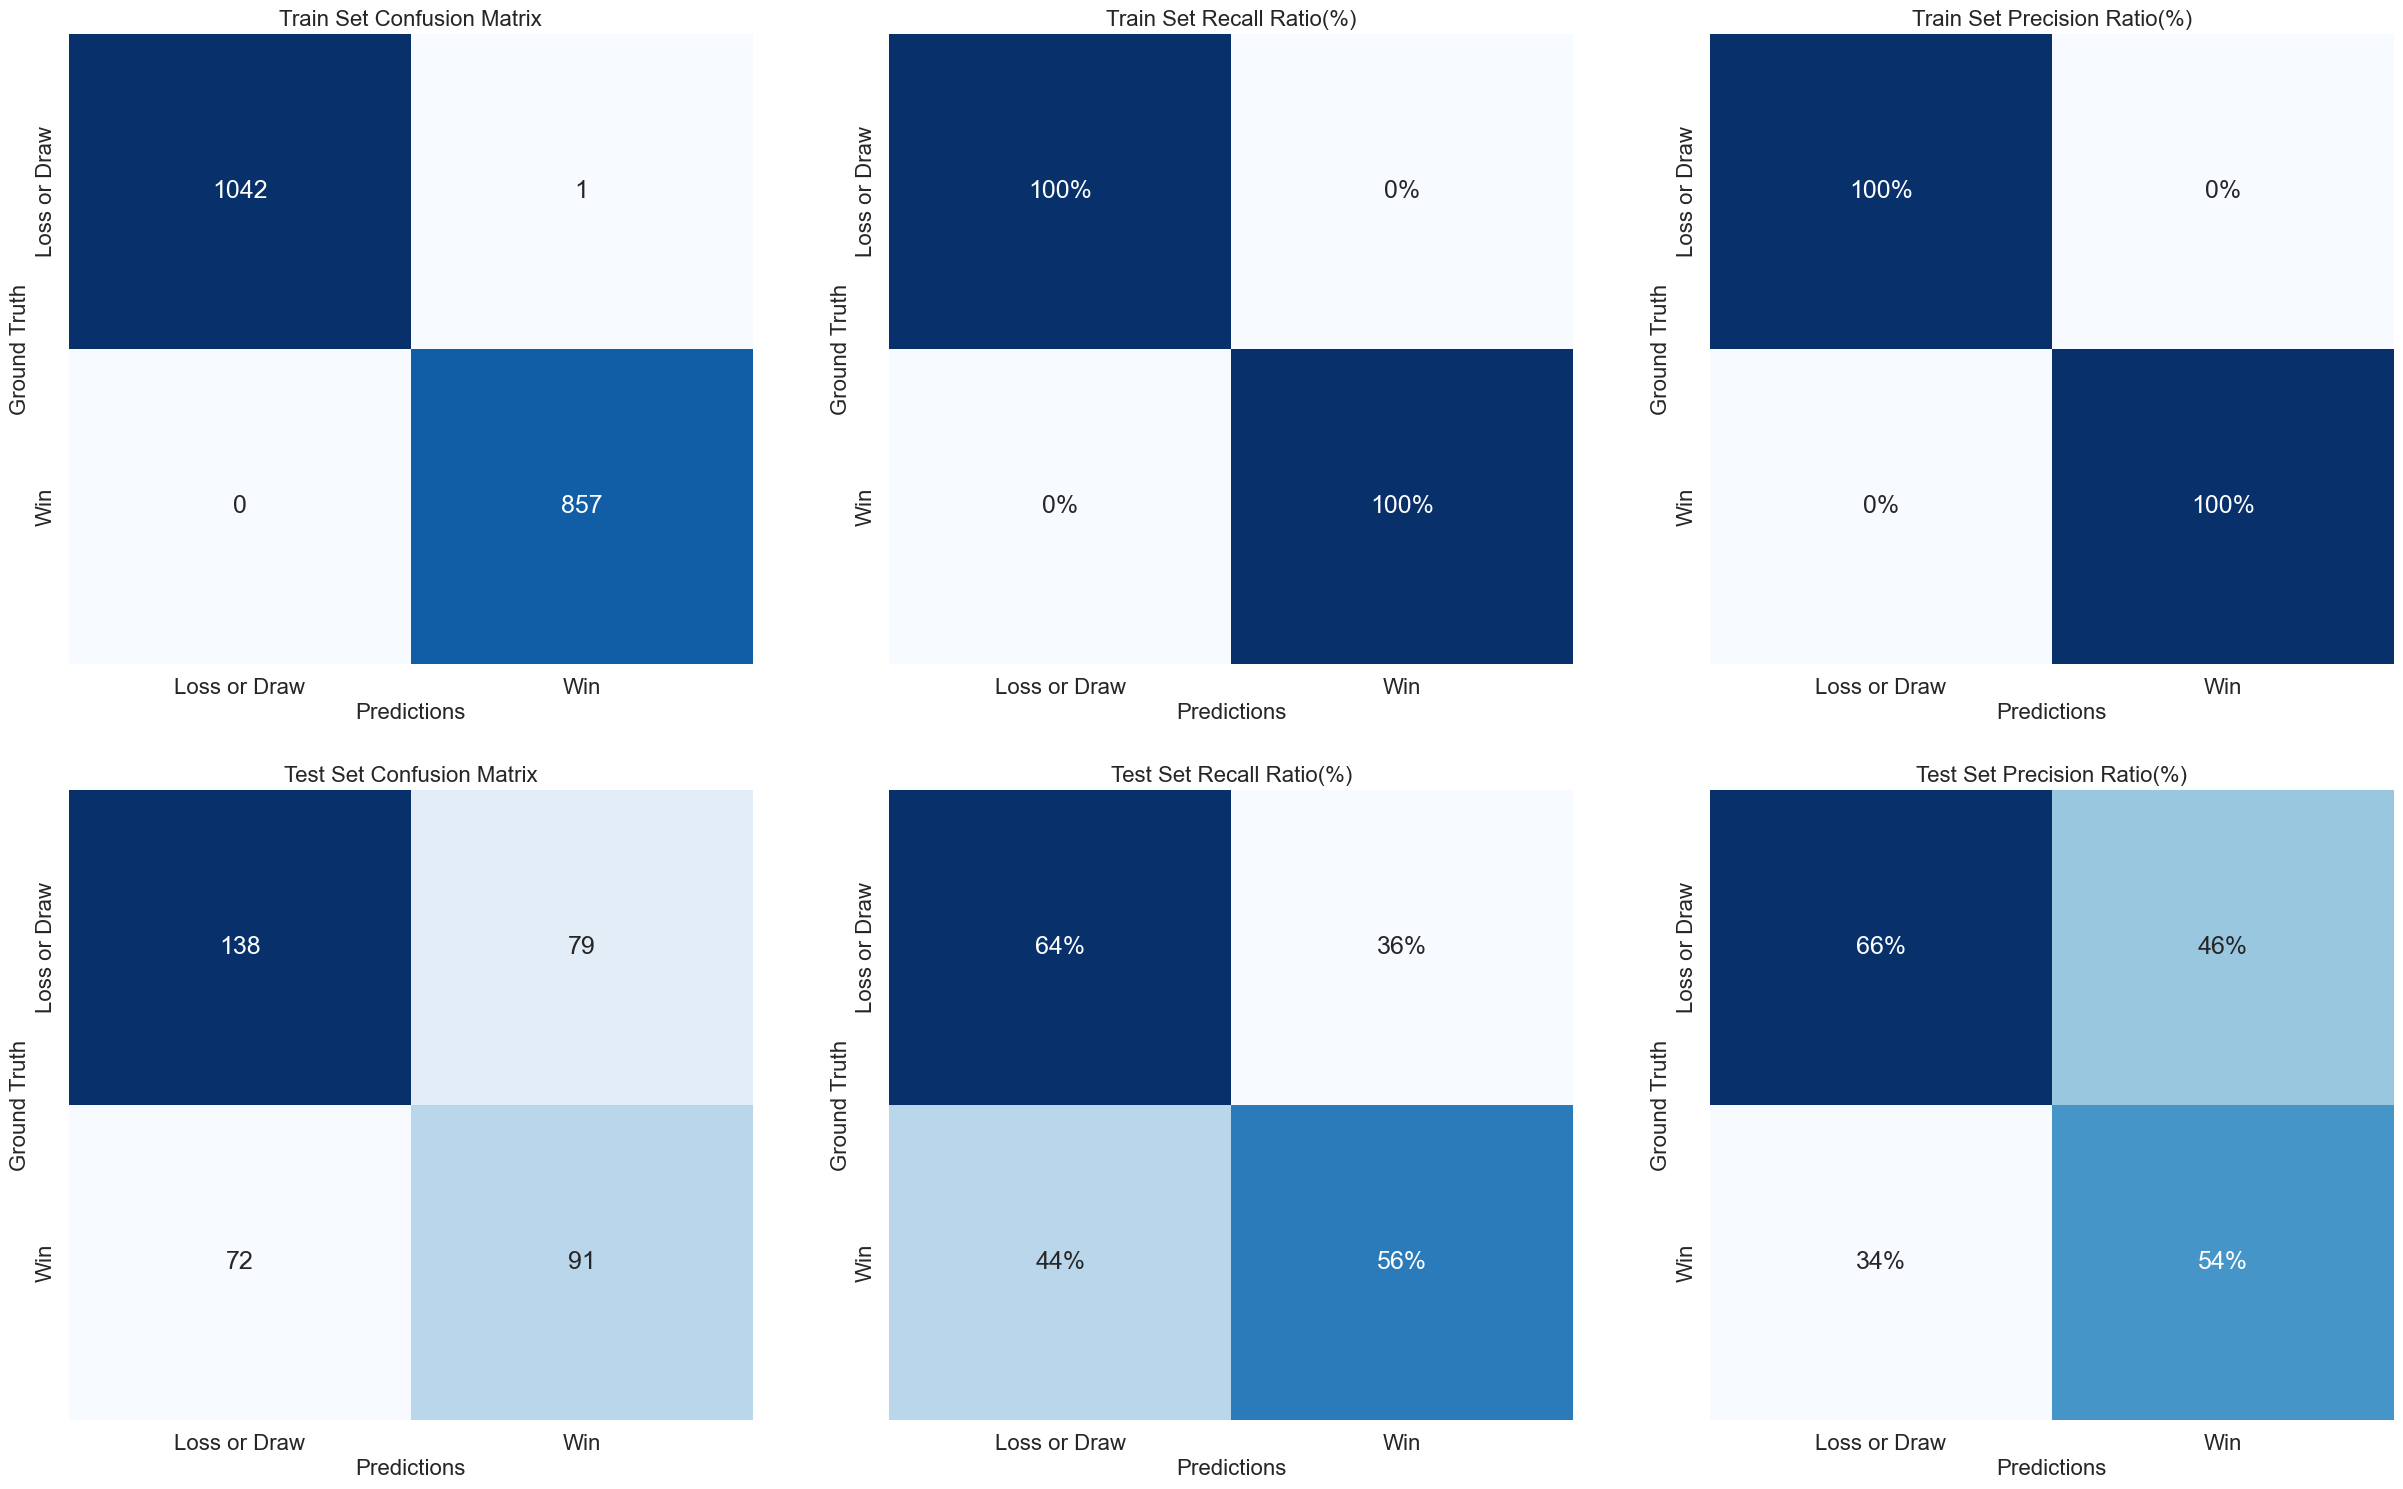

In [52]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = dt_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test)

In [53]:
# Calling the function to evaluate the performance of the classifier
dt_model_summary_df = evaluate_model_performance(model = dt_model, 
                                                 train_features = X_train, 
                                                 train_labels = y_train, 
                                                 test_features = X_test, 
                                                 test_labels = y_test,
                                                 algorithm_name = 'Decision Tree')
dt_model_summary_df

Train Balanced Accuracy  Test Balanced Accuracy  Accuracy  \
Decision Tree                      1.0                     0.6       0.6   

               Precision  Recall  F0.5  AUC  Brier Score Loss  \
Decision Tree       0.54    0.56  0.54  0.6               0.4   

               Train Threshold  Test Threshold  
Decision Tree              0.1             0.5

***
### Random Forest

In [54]:
# Building a classifier
rf_model = build_pipeline(classifier = RandomForestClassifier(random_state = 42), 
                          data_frame = df, 
                          train_features = X_train, 
                          train_labels = y_train, 
                          apply_bayesian_optimization = False,
                          scale = False,
                          drop_high_vif_features = False,
                          feature_selection_method = 'boruta')

# Logging information to the log file
logging.info(msg = 'Random Forest model has been built')

# Displaying the architecture of the classifier
rf_model

Pipeline(steps=[('feature_reallocator', FeatureReallocator()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('binary_pipeline',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['is_boxing_day',
                                                   'finished_top_4_last_season_h',
                                                   'finished_top_4_last_season_a',
                                                   'won_carabao_cup_last_seaso...
                                                   'total_avg_shots_last_5_h',
                                                   'total_avg_shots_last_5_a', ...])])),
                ('feature_selector',
                 BorutaPy(estimator=RandomForestClassifier(n_estimators=1000,
                                                           random_state=RandomState(MT19937) at 0x7FA61821B240),
                          random_state=RandomState(MT19937) at 0x7FA61821B240)),
                ('classifier',
                 RandomForestClassifier(n_estimators=1000,
                                        random_state=RandomState(MT19937) at 0x7FA61821B240))])

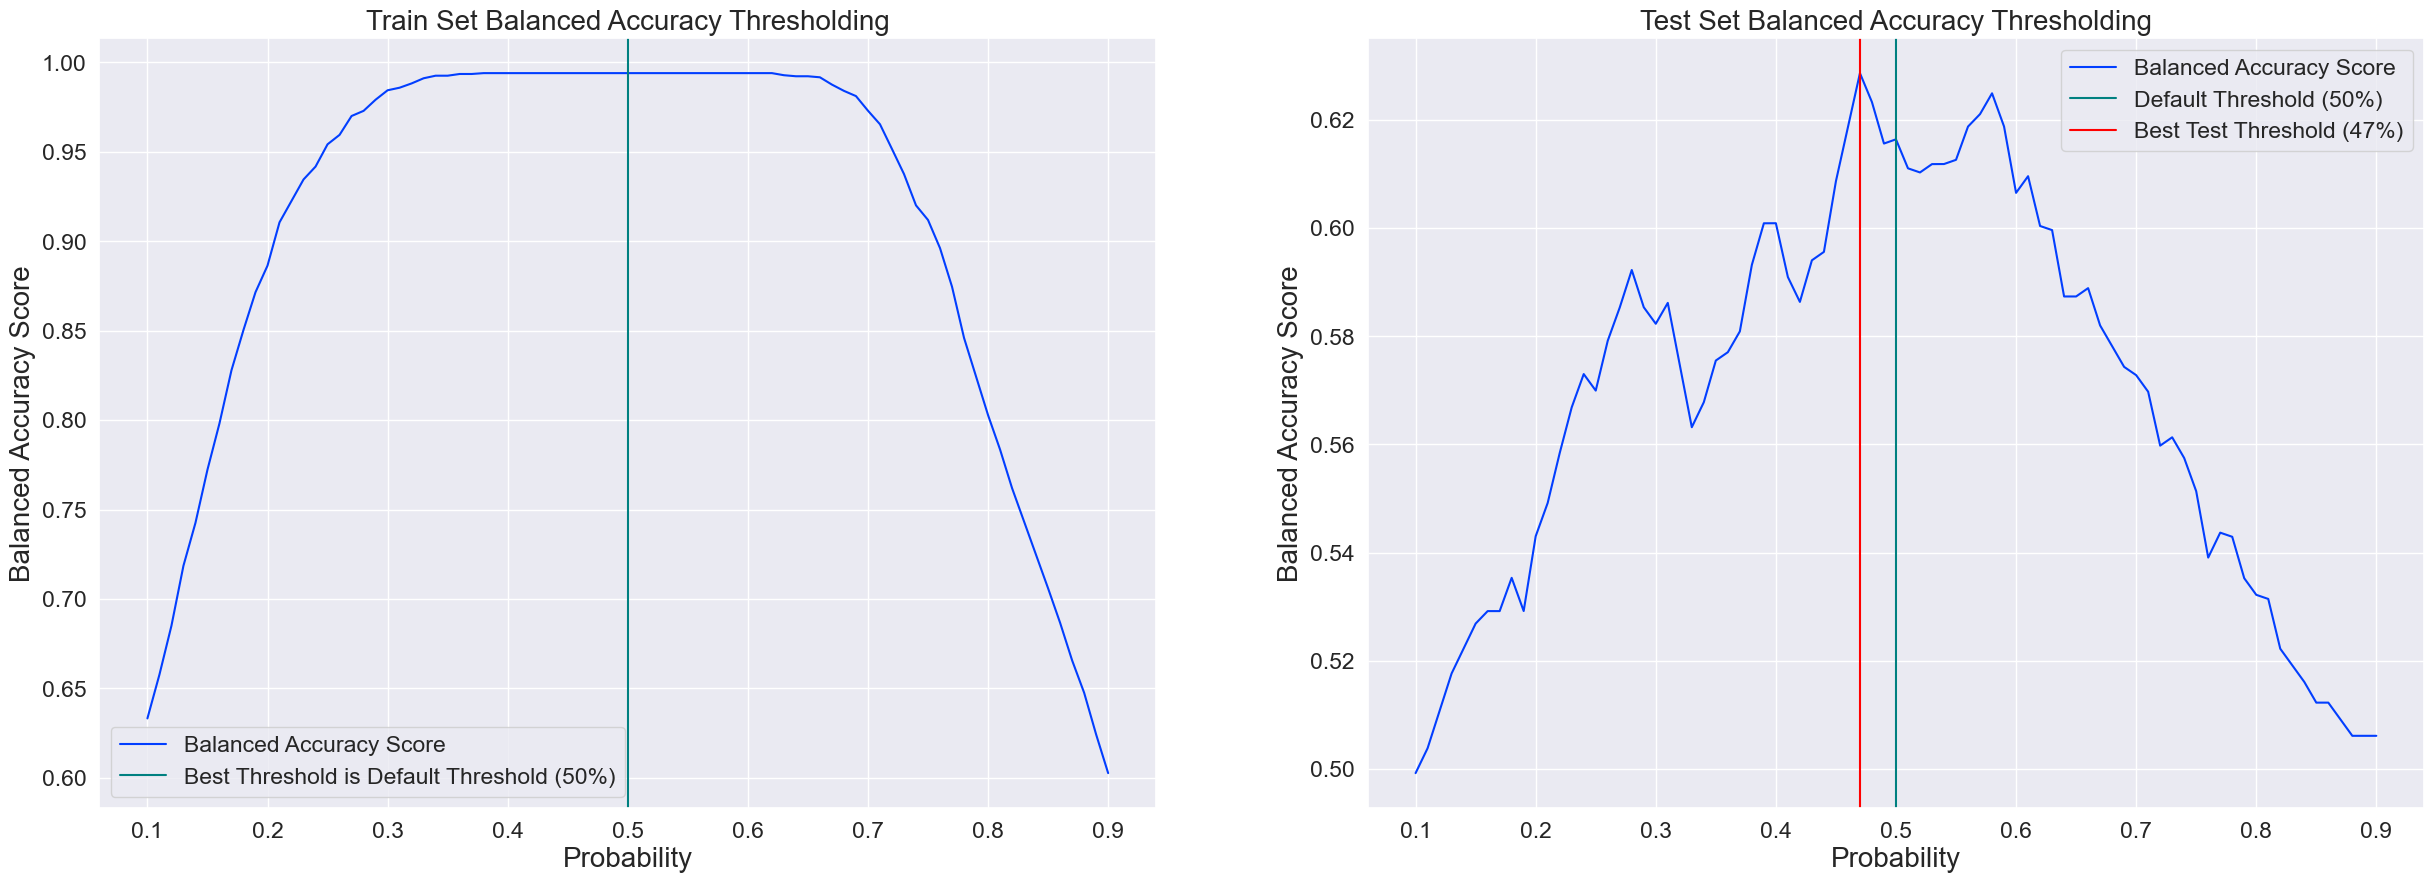

In [55]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = rf_model, 
                                                         metric = 'balanced_accuracy', 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [56]:
# Calling the function to print out the classification report
print_classification_report(model = rf_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            algorithm_name = 'Random Forest')

Classification Report Summary for Random Forest Model:

Train report:
              precision    recall  f1-score   support

Loss or Draw       0.99      1.00      0.99      1043
         Win       1.00      0.99      0.99       857

    accuracy                           0.99      1900
   macro avg       0.99      0.99      0.99      1900
weighted avg       0.99      0.99      0.99      1900



Test report:
              precision    recall  f1-score   support

Loss or Draw       0.67      0.76      0.71       217
         Win       0.61      0.50      0.55       163

    accuracy                           0.65       380
   macro avg       0.64      0.63      0.63       380
weighted avg       0.64      0.65      0.64       380



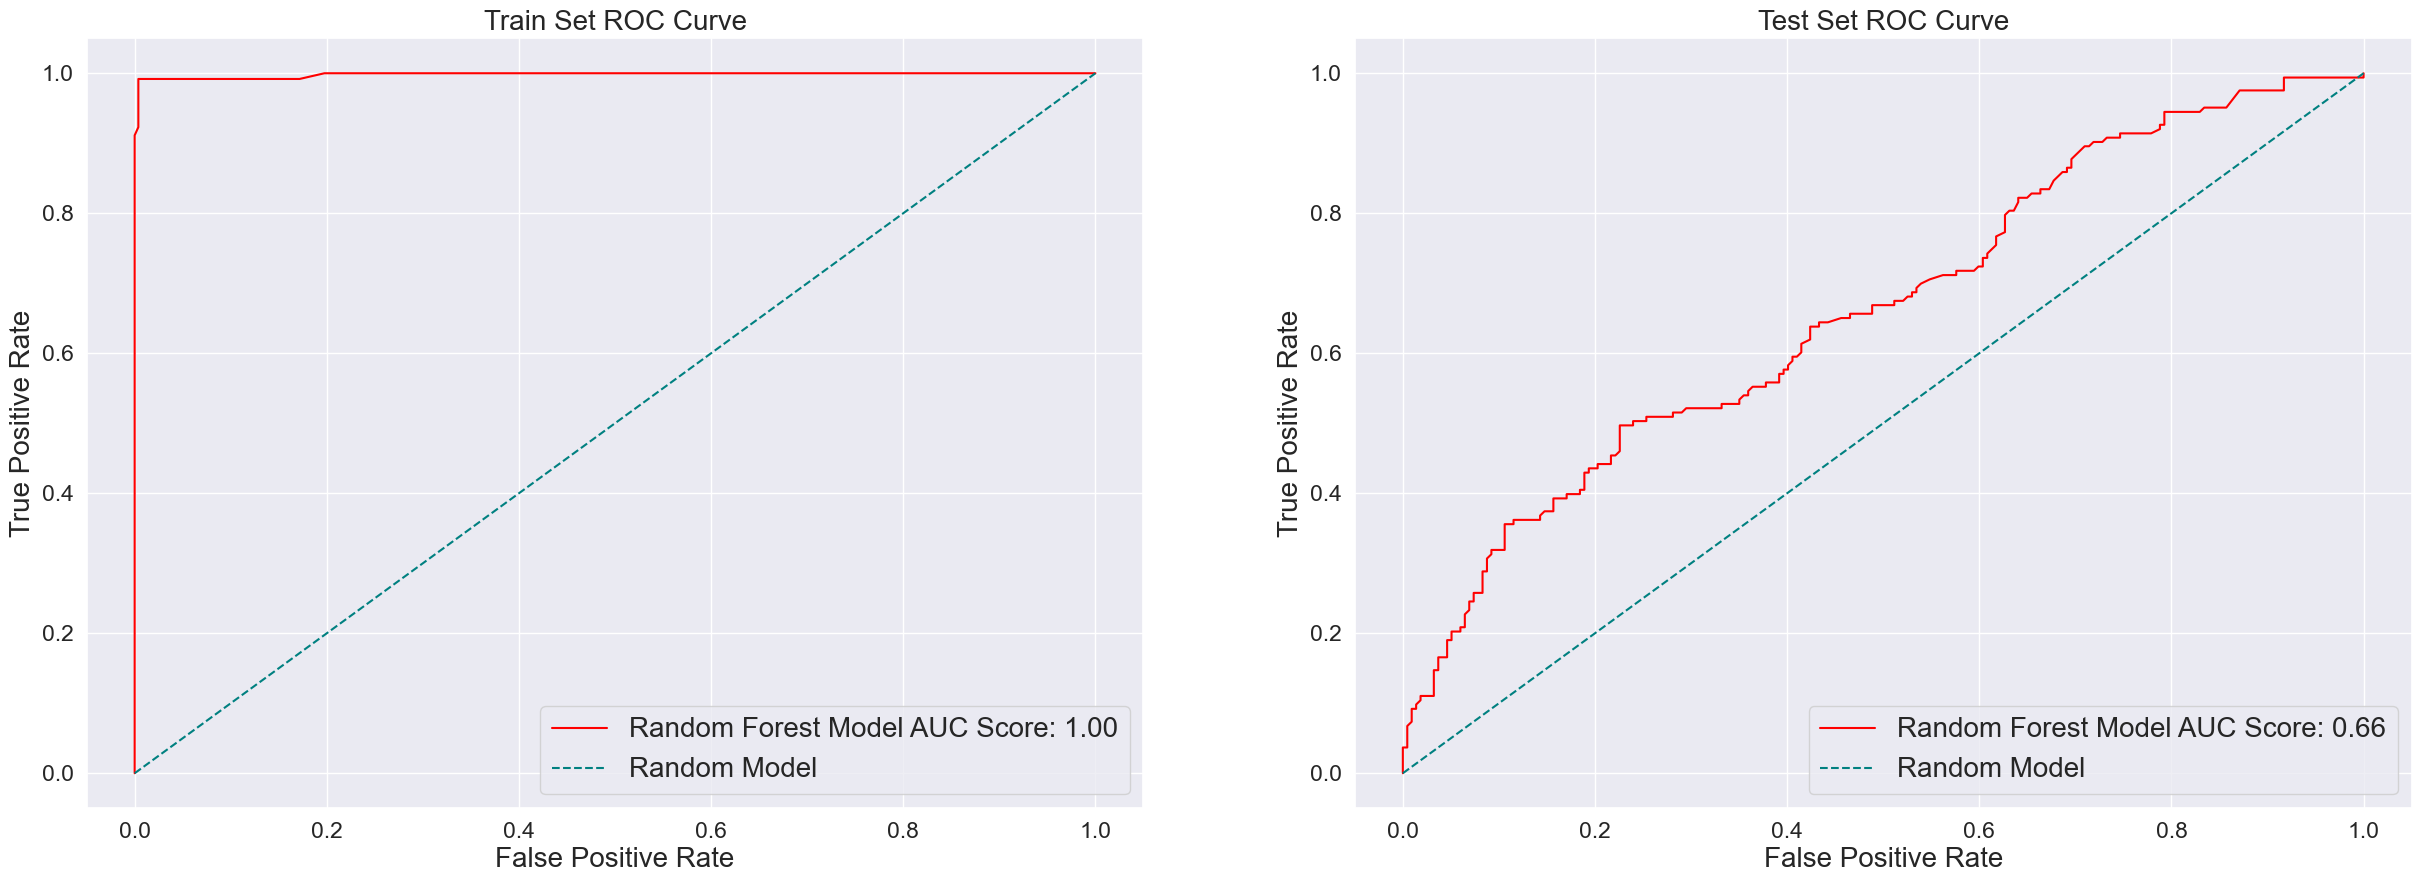

In [57]:
# Calling the function to plot ROC curve
plot_roc_curve(model = rf_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = 'Random Forest')

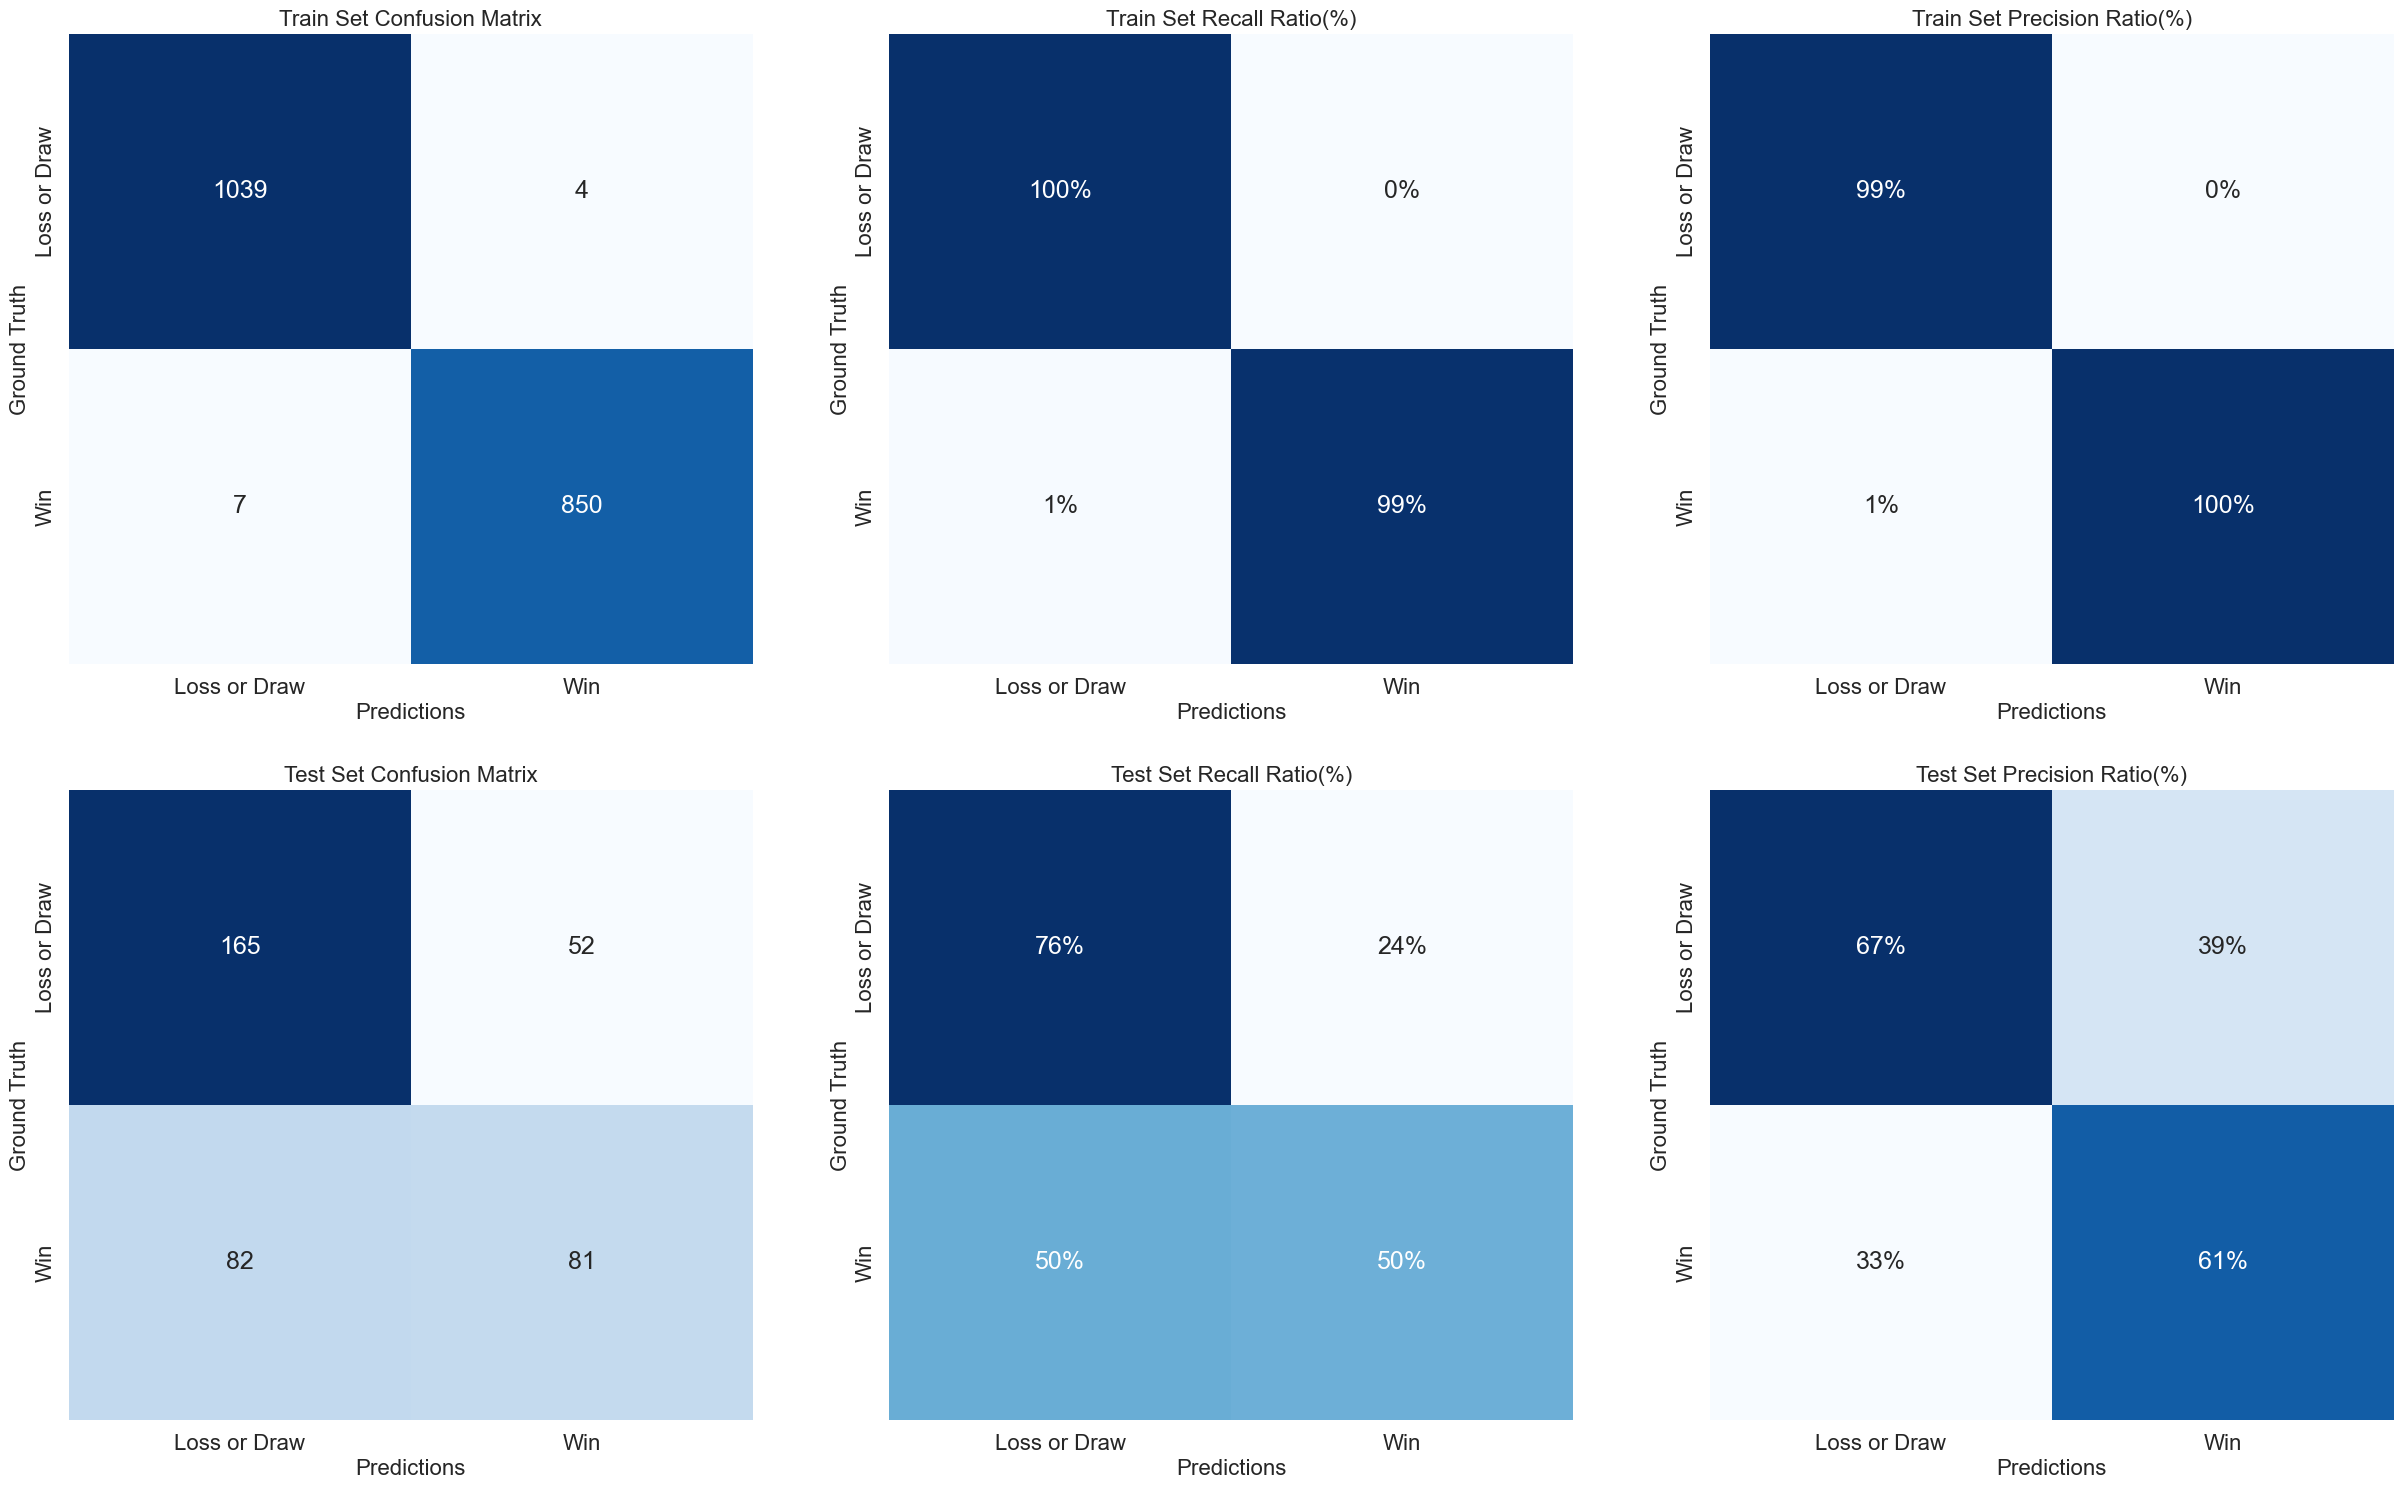

In [58]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = rf_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test)

In [59]:
# Calling the function to evaluate the performance of the classifier
rf_model_summary_df = evaluate_model_performance(model = rf_model, 
                                                 train_features = X_train, 
                                                 train_labels = y_train, 
                                                 test_features = X_test, 
                                                 test_labels = y_test,
                                                 algorithm_name = 'Random Forest')
rf_model_summary_df

Train Balanced Accuracy  Test Balanced Accuracy  Accuracy  \
Random Forest                     0.99                    0.63      0.65   

               Precision  Recall  F0.5   AUC  Brier Score Loss  \
Random Forest       0.61     0.5  0.58  0.66              0.22   

               Train Threshold  Test Threshold  
Random Forest              0.5            0.47

***
### Light Gradient Boosted Machine (LightGBM)

In [60]:
# Building a classifier
lgbm_model = build_pipeline(classifier = LGBMClassifier(objective = 'binary', random_state = 42),  
                            data_frame = df, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            apply_bayesian_optimization = False,
                            scale = False,
                            drop_high_vif_features = False,
                            feature_selection_method = 'meta')

# Logging information to the log file
logging.info(msg = 'Light Gradient Boosted Machine model has been built')
 
# Displaying the architecture of the classifier
lgbm_model

Pipeline(steps=[('feature_reallocator', FeatureReallocator()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('binary_pipeline',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['is_boxing_day',
                                                   'finished_top_4_last_season_h',
                                                   'finished_top_4_last_season_a',
                                                   'won_carabao_cup_last_seaso...
                                                   'total_avg_shots_on_target_last_5_a',
                                                   'total_avg_shots_h',
                                                   'total_avg_shots_a',
                                                   'total_avg_shots_last_3_h',
                                                   'total_avg_shots_last_3_a',
                                                   'total_avg_shots_last_5_h',
                                                   'total_avg_shots_last_5_a', ...])])),
                ('feature_selector',
                 SelectFromModel(estimator=LGBMClassifier(objective='binary',
                                                          random_state=42))),
                ('classifier',
                 LGBMClassifier(objective='binary', random_state=42))])

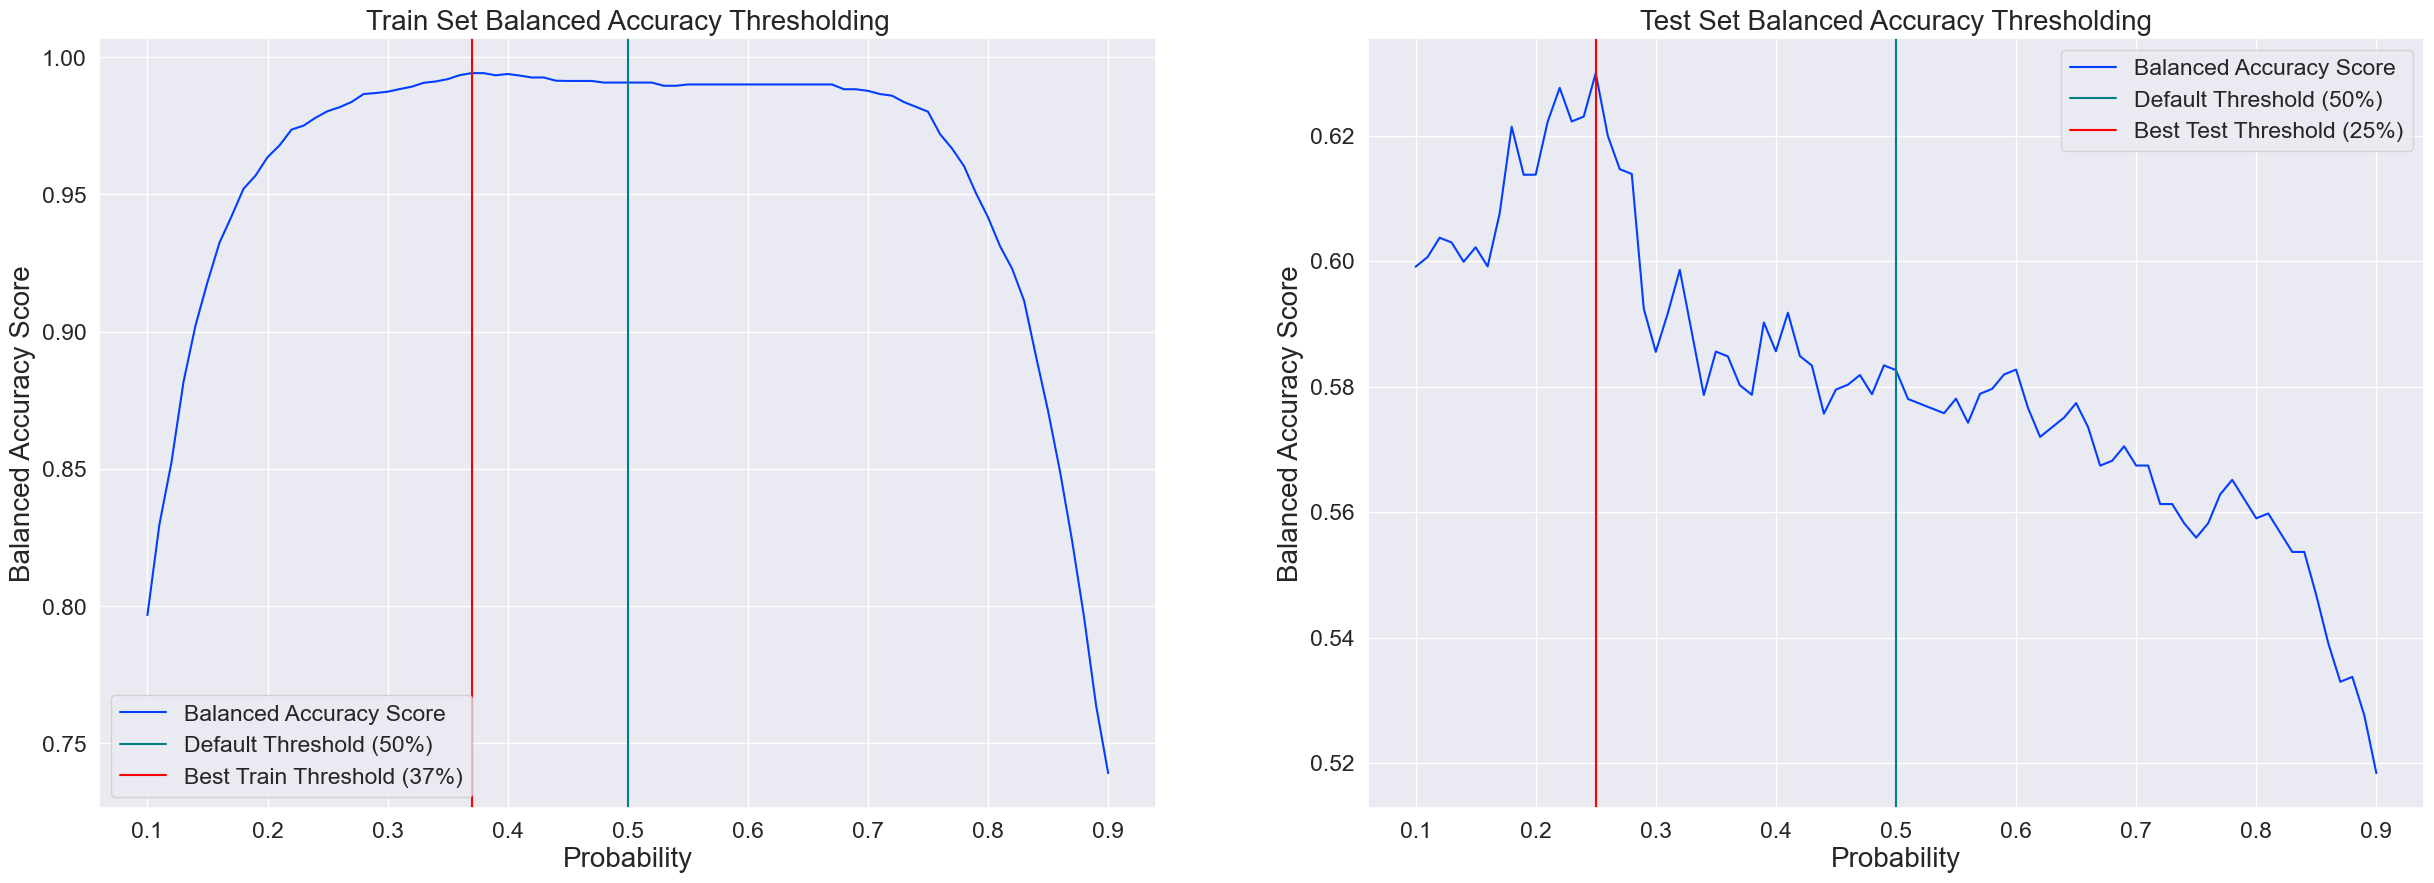

In [61]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = lgbm_model, 
                                                         metric = 'balanced_accuracy', 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [62]:
# Calling the function to print out the classification report
print_classification_report(model = lgbm_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            algorithm_name = 'Light Gradient Boosted Machine')

Classification Report Summary for Light Gradient Boosted Machine Model:

Train report:
              precision    recall  f1-score   support

Loss or Draw       1.00      0.99      0.99      1043
         Win       0.99      0.99      0.99       857

    accuracy                           0.99      1900
   macro avg       0.99      0.99      0.99      1900
weighted avg       0.99      0.99      0.99      1900



Test report:
              precision    recall  f1-score   support

Loss or Draw       0.75      0.47      0.58       217
         Win       0.53      0.79      0.63       163

    accuracy                           0.61       380
   macro avg       0.64      0.63      0.61       380
weighted avg       0.65      0.61      0.60       380



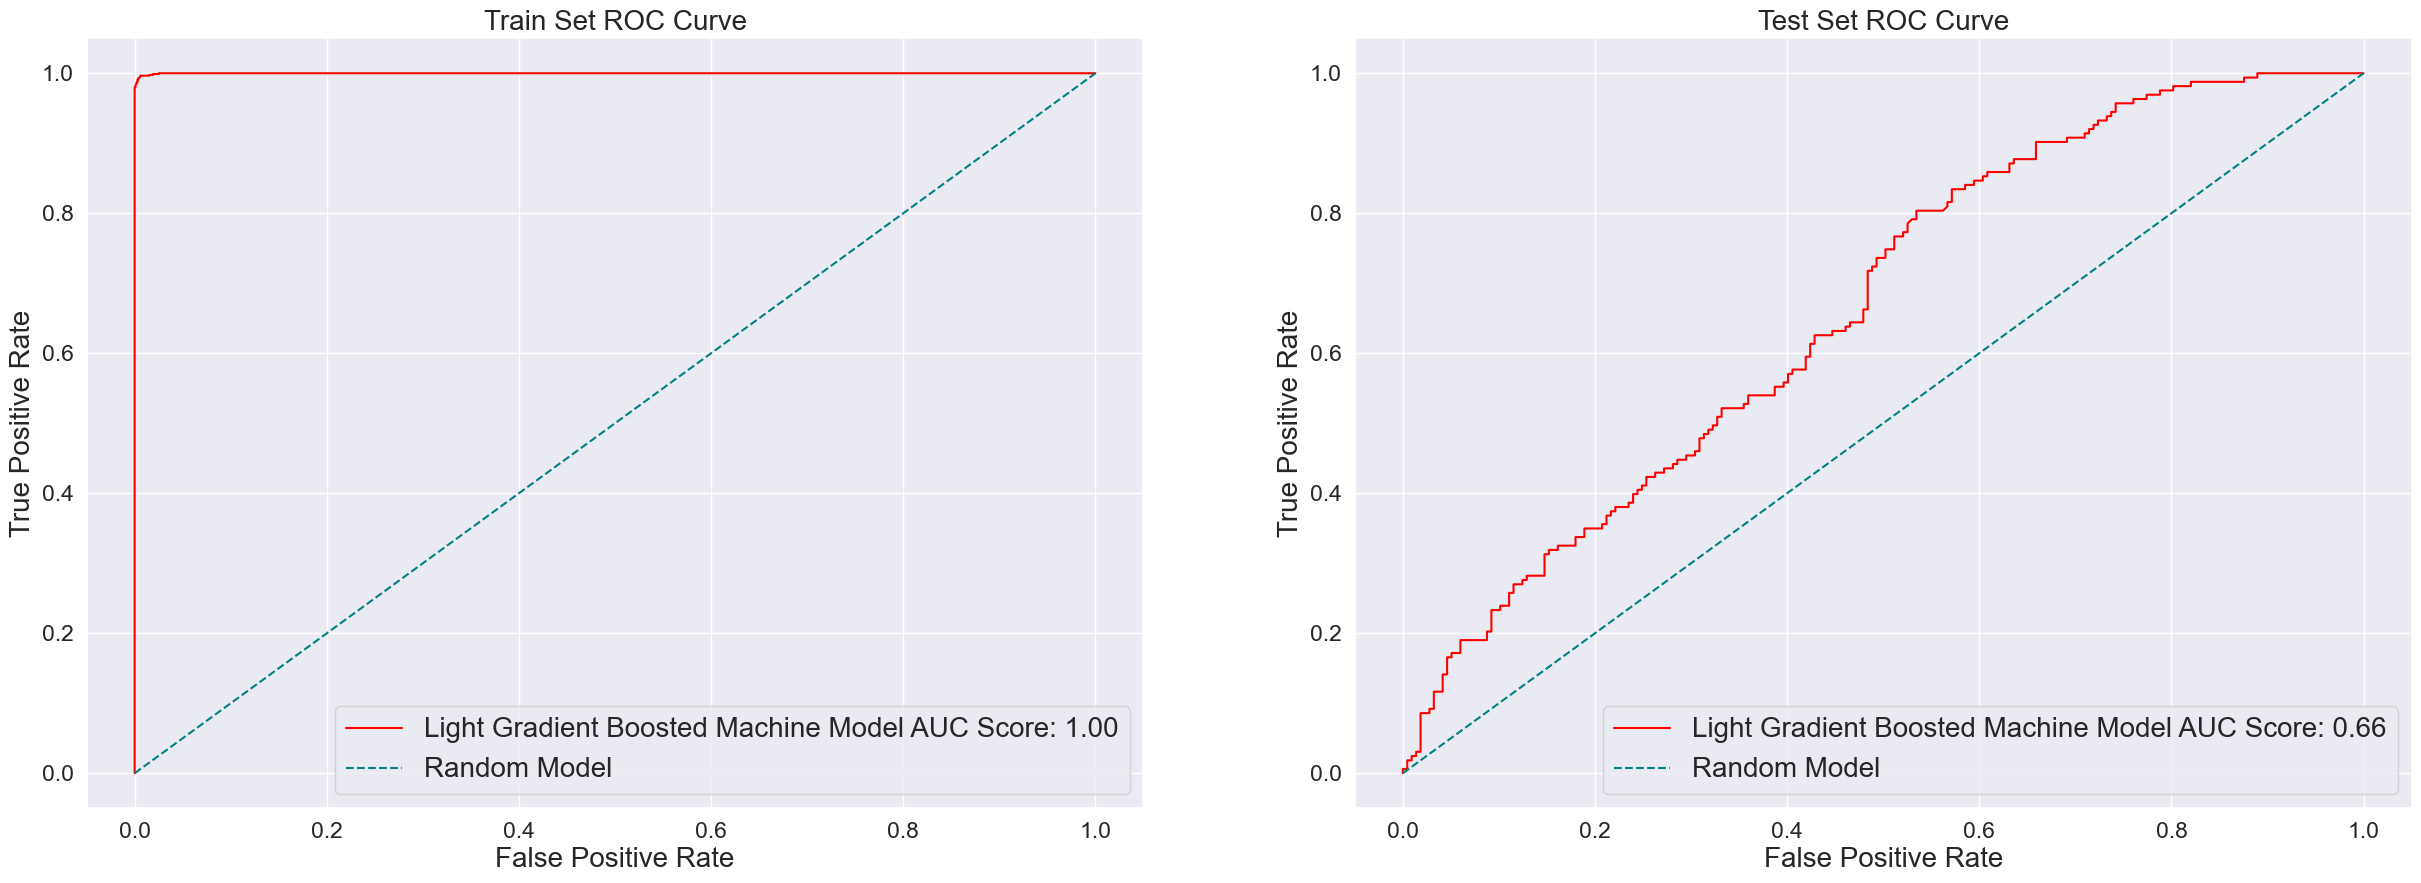

In [63]:
# Calling the function to plot ROC curve
plot_roc_curve(model = lgbm_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = 'Light Gradient Boosted Machine')

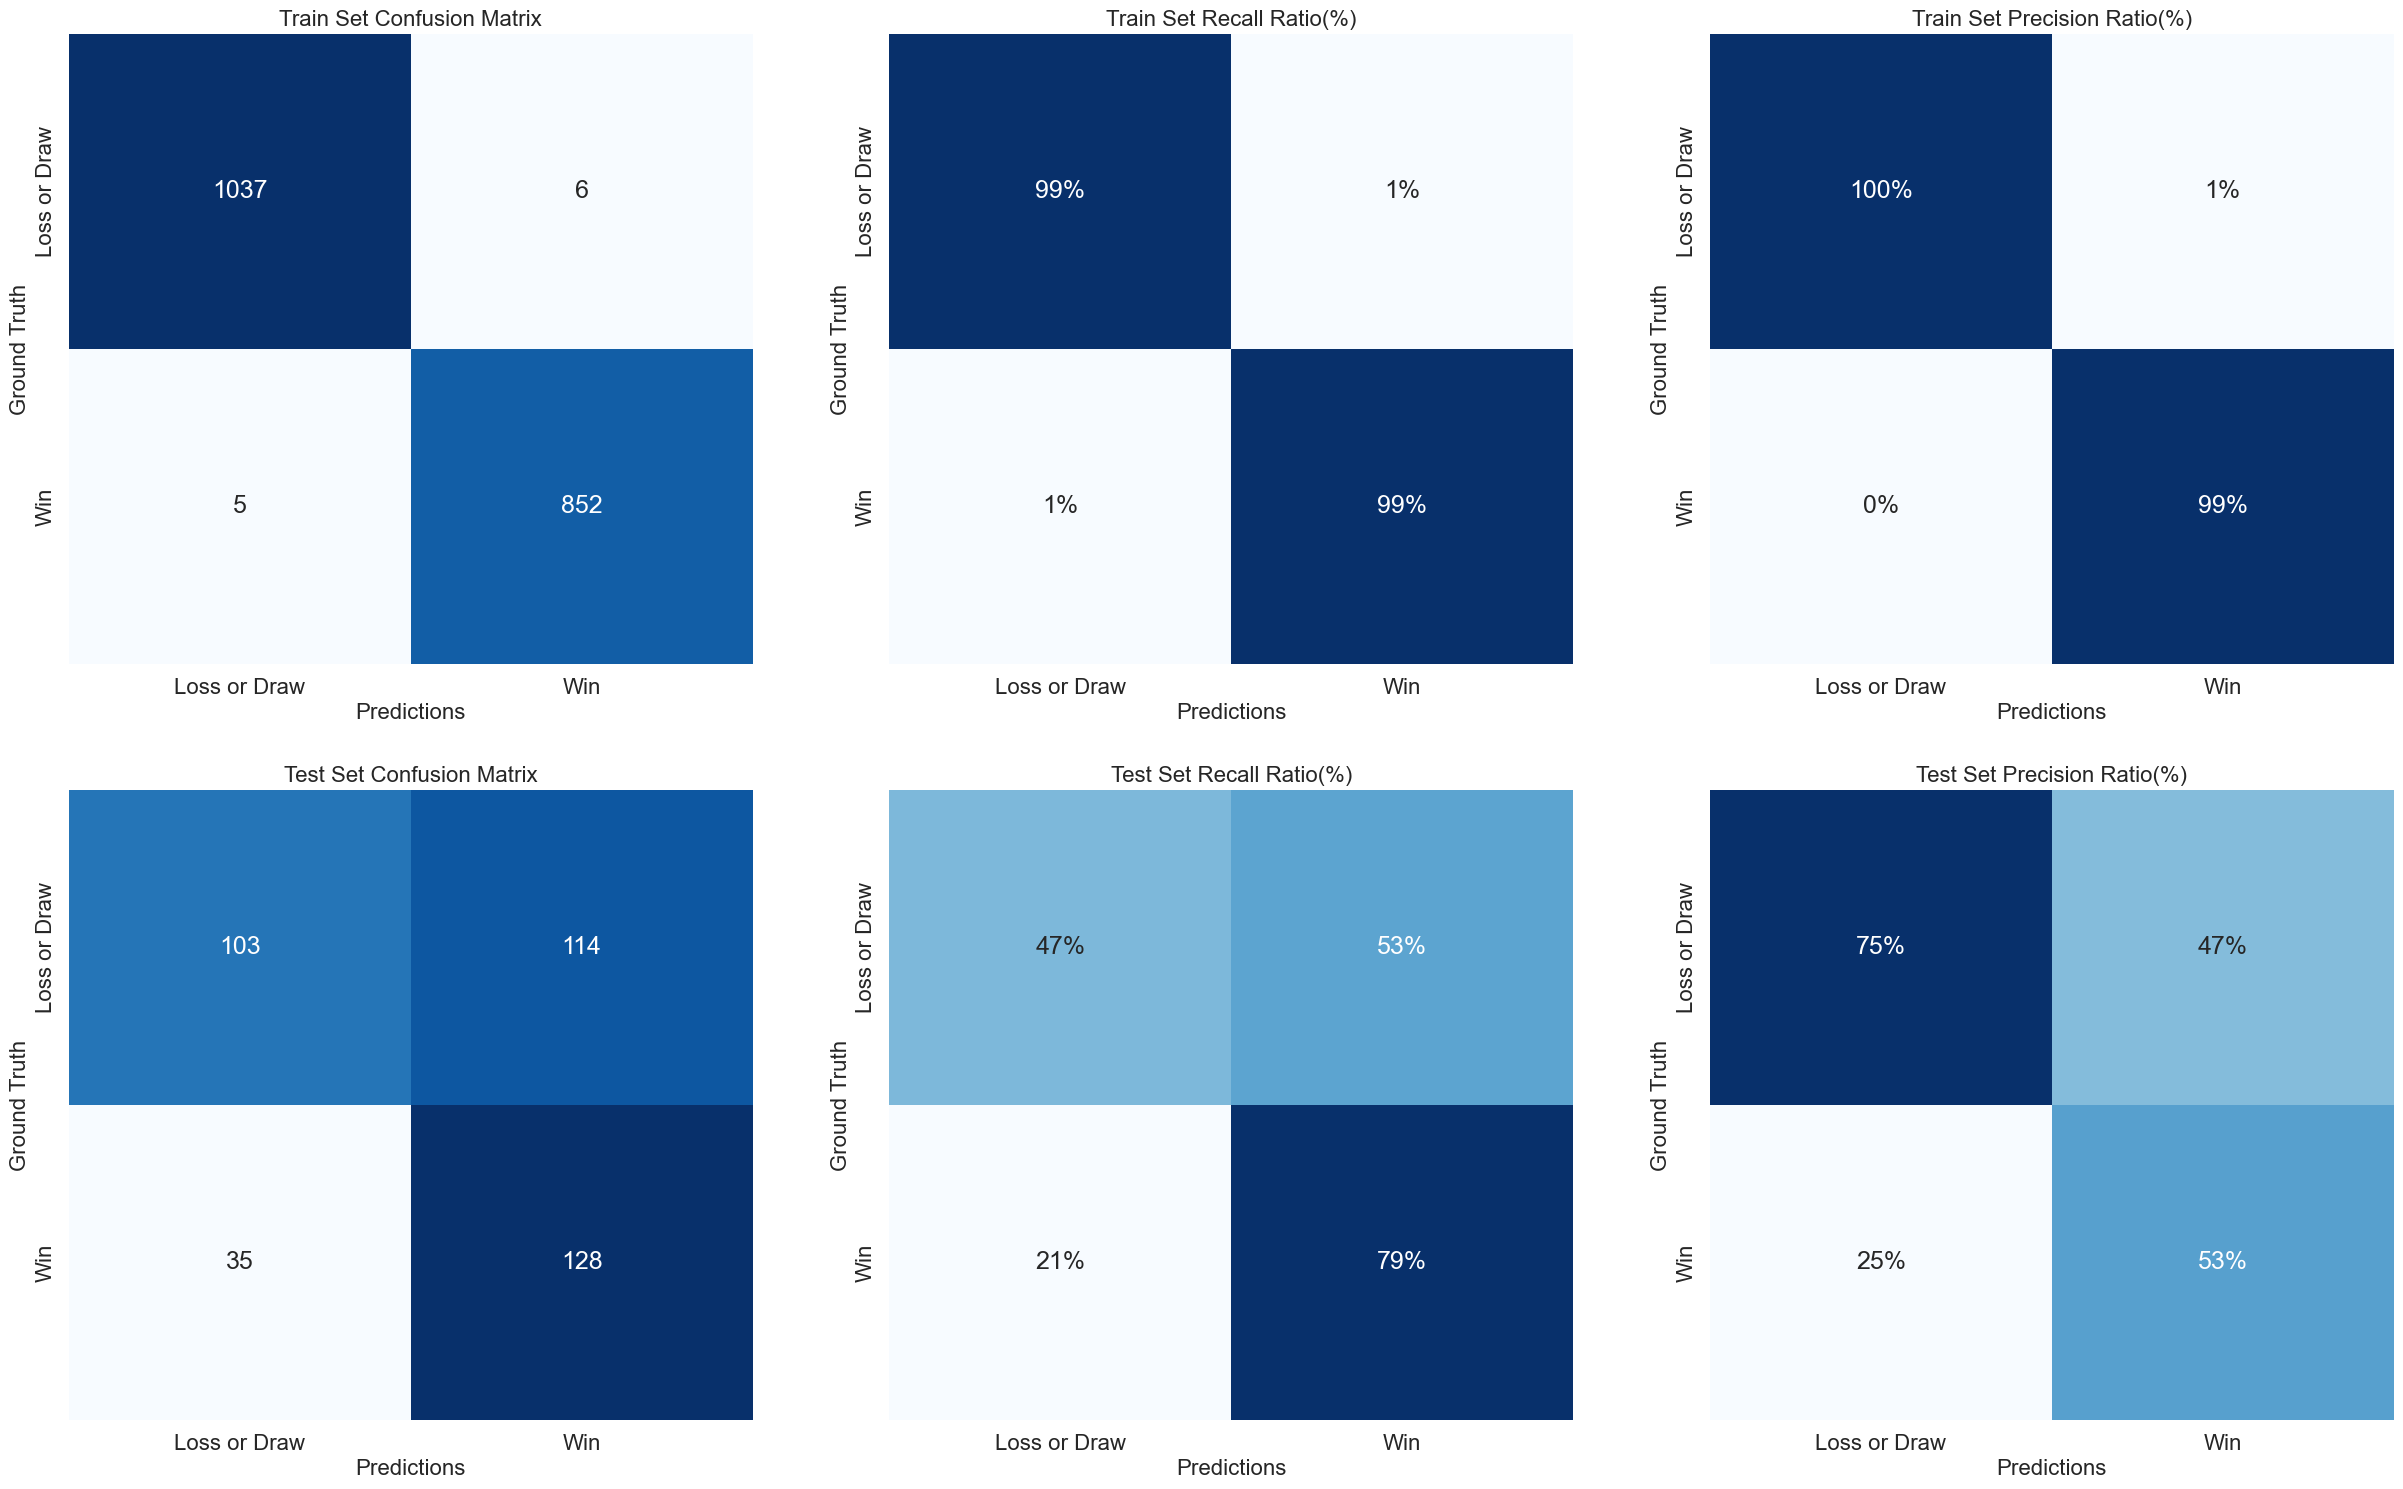

In [64]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = lgbm_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test)

In [65]:
# Calling the function to evaluate the performance of the classifier
lgbm_model_summary_df = evaluate_model_performance(model = lgbm_model, 
                                                   train_features = X_train, 
                                                   train_labels = y_train, 
                                                   test_features = X_test, 
                                                   test_labels = y_test,
                                                   algorithm_name = 'Light Gradient Boosted Machine')
lgbm_model_summary_df

Train Balanced Accuracy  \
Light Gradient Boosted Machine                     0.99   

                                Test Balanced Accuracy  Accuracy  Precision  \
Light Gradient Boosted Machine                    0.63      0.61       0.53   

                                Recall  F0.5   AUC  Brier Score Loss  \
Light Gradient Boosted Machine    0.79  0.57  0.66              0.24   

                                Train Threshold  Test Threshold  
Light Gradient Boosted Machine             0.37            0.25

***
### Adaptive Boosting (ADABoost)

In [66]:
# Building a classifier
ada_model = build_pipeline(classifier = AdaBoostClassifier(random_state = 42), 
                           data_frame = df, 
                           train_features = X_train, 
                           train_labels = y_train, 
                           apply_bayesian_optimization = False,
                           scale = False,
                           drop_high_vif_features = False,
                           feature_selection_method = 'meta')

# Logging information to the log file
logging.info(msg = 'Adaptive Boosting model has been built')
 
# Displaying the architecture of the classifier
ada_model

Pipeline(steps=[('feature_reallocator', FeatureReallocator()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('binary_pipeline',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['is_boxing_day',
                                                   'finished_top_4_last_season_h',
                                                   'finished_top_4_last_season_a',
                                                   'won_carabao_cup_last_seaso...
                                                   'total_avg_shots_on_target_last_5_h',
                                                   'total_avg_shots_on_target_last_5_a',
                                                   'total_avg_shots_h',
                                                   'total_avg_shots_a',
                                                   'total_avg_shots_last_3_h',
                                                   'total_avg_shots_last_3_a',
                                                   'total_avg_shots_last_5_h',
                                                   'total_avg_shots_last_5_a', ...])])),
                ('feature_selector',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=42))),
                ('classifier', AdaBoostClassifier(random_state=42))])

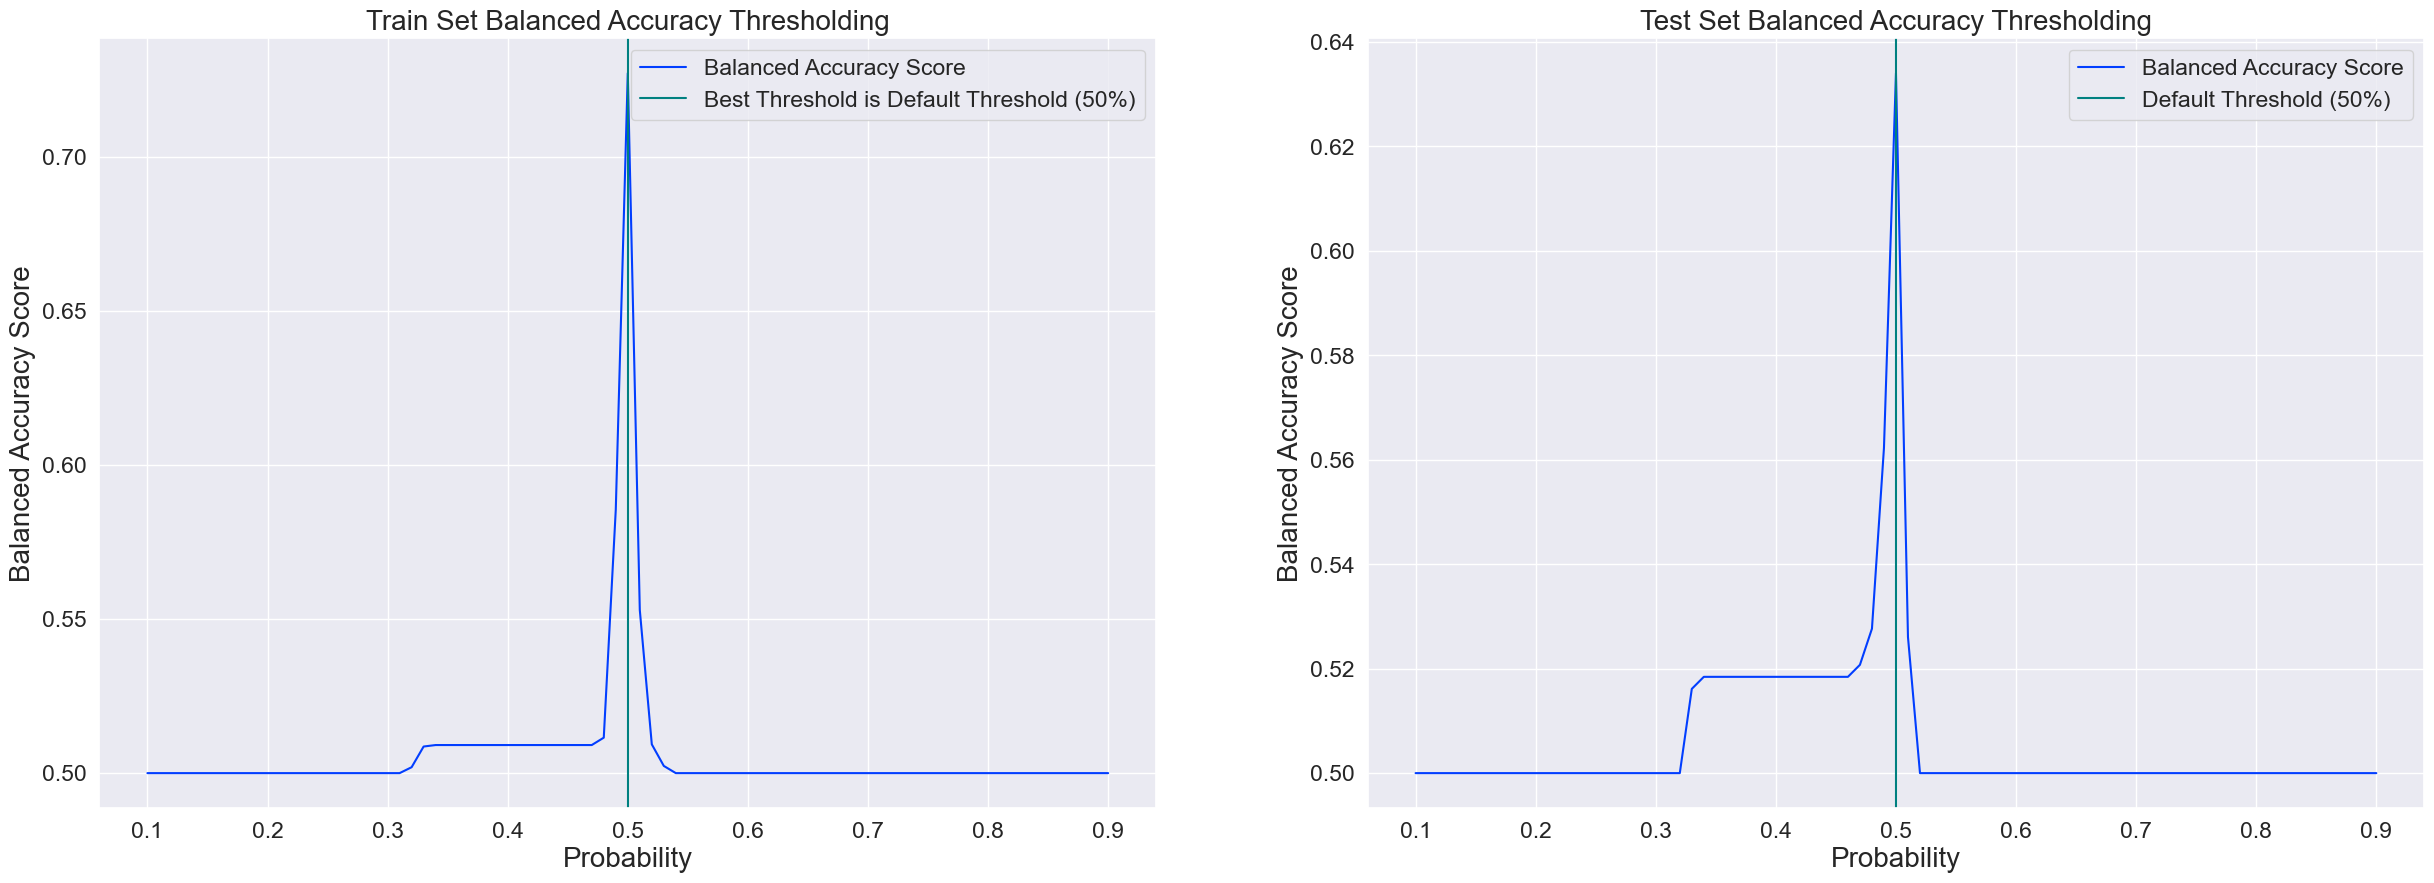

In [67]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = ada_model, 
                                                         metric = 'balanced_accuracy', 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [68]:
# Calling the function to print out the classification report
print_classification_report(model = ada_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            algorithm_name = 'Adaptive Boosting')

Classification Report Summary for Adaptive Boosting Model:

Train report:
              precision    recall  f1-score   support

Loss or Draw       0.74      0.79      0.77      1043
         Win       0.73      0.66      0.69       857

    accuracy                           0.73      1900
   macro avg       0.73      0.73      0.73      1900
weighted avg       0.73      0.73      0.73      1900



Test report:
              precision    recall  f1-score   support

Loss or Draw       0.68      0.75      0.71       217
         Win       0.61      0.52      0.56       163

    accuracy                           0.65       380
   macro avg       0.64      0.63      0.64       380
weighted avg       0.65      0.65      0.65       380



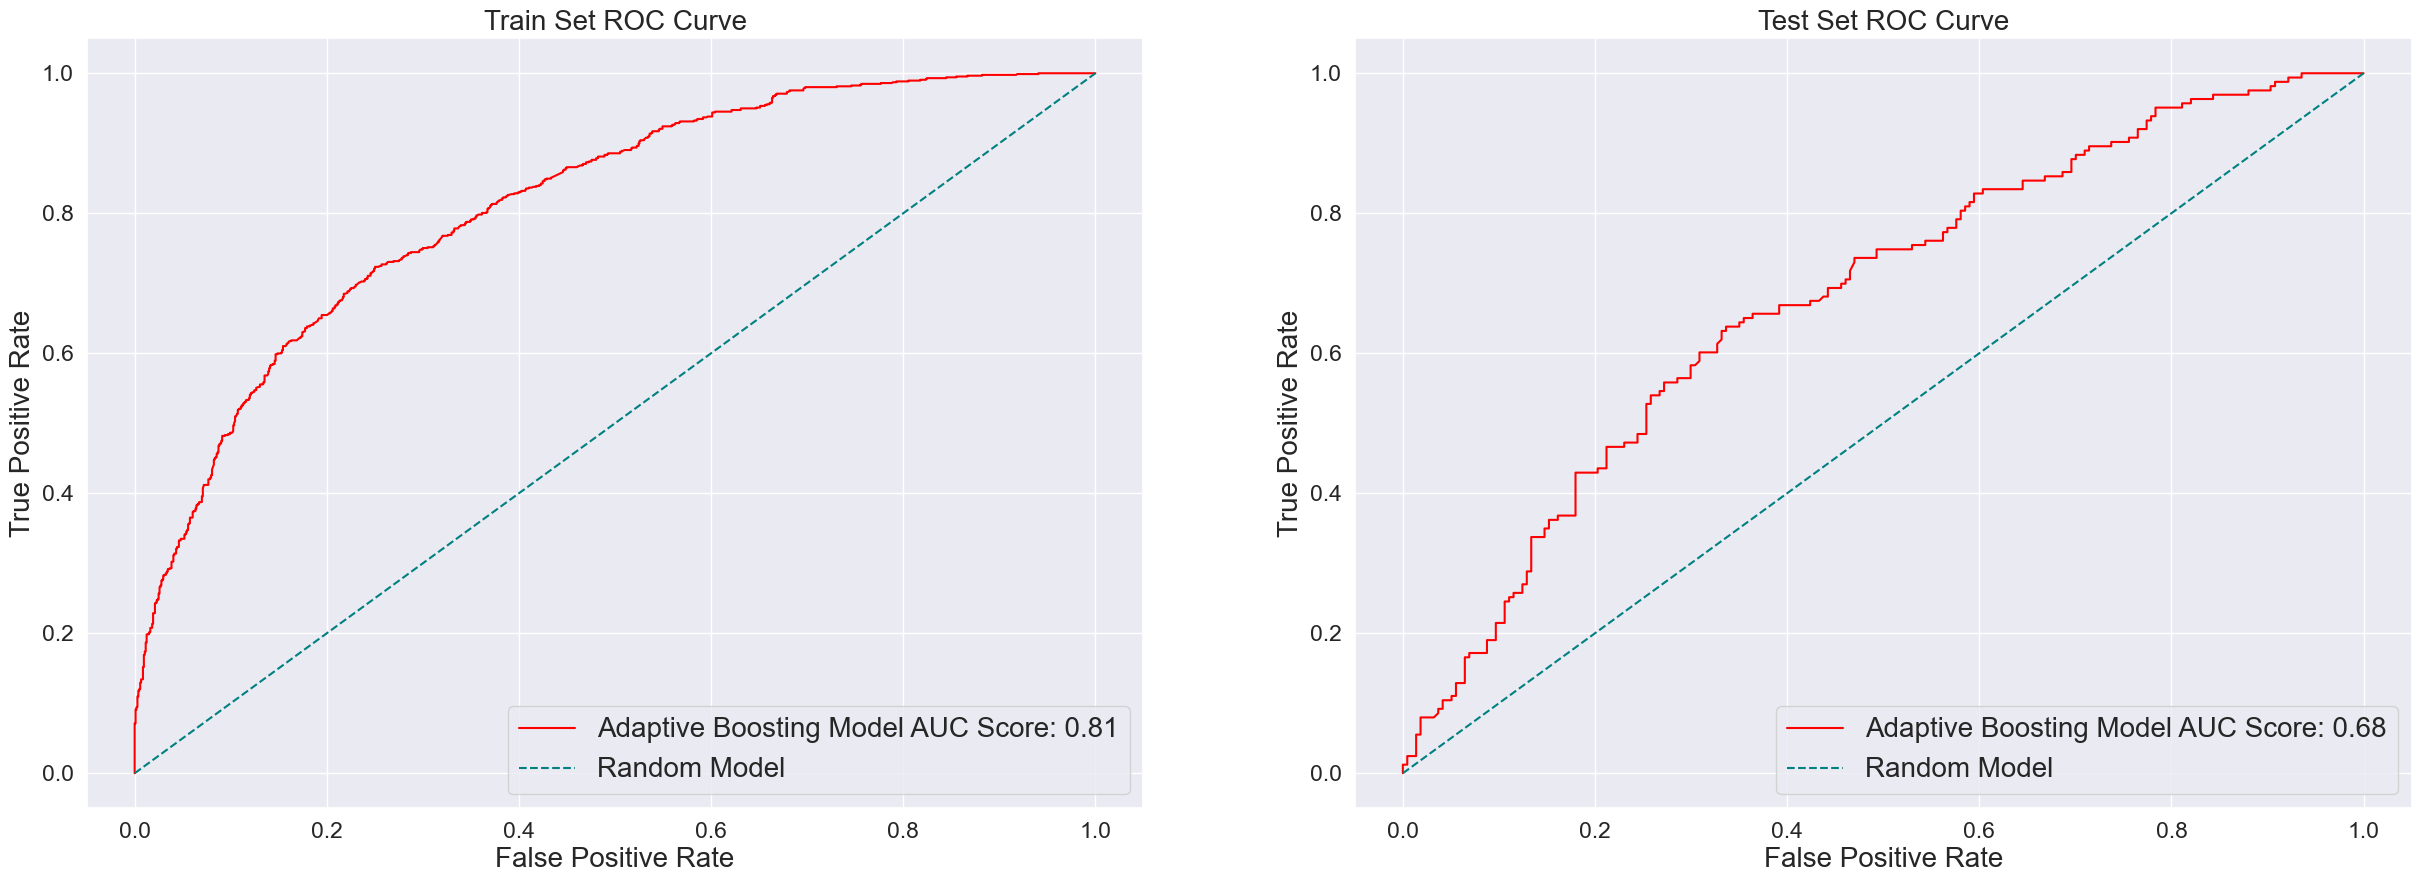

In [69]:
# Calling the function to plot ROC curve
plot_roc_curve(model = ada_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = 'Adaptive Boosting')

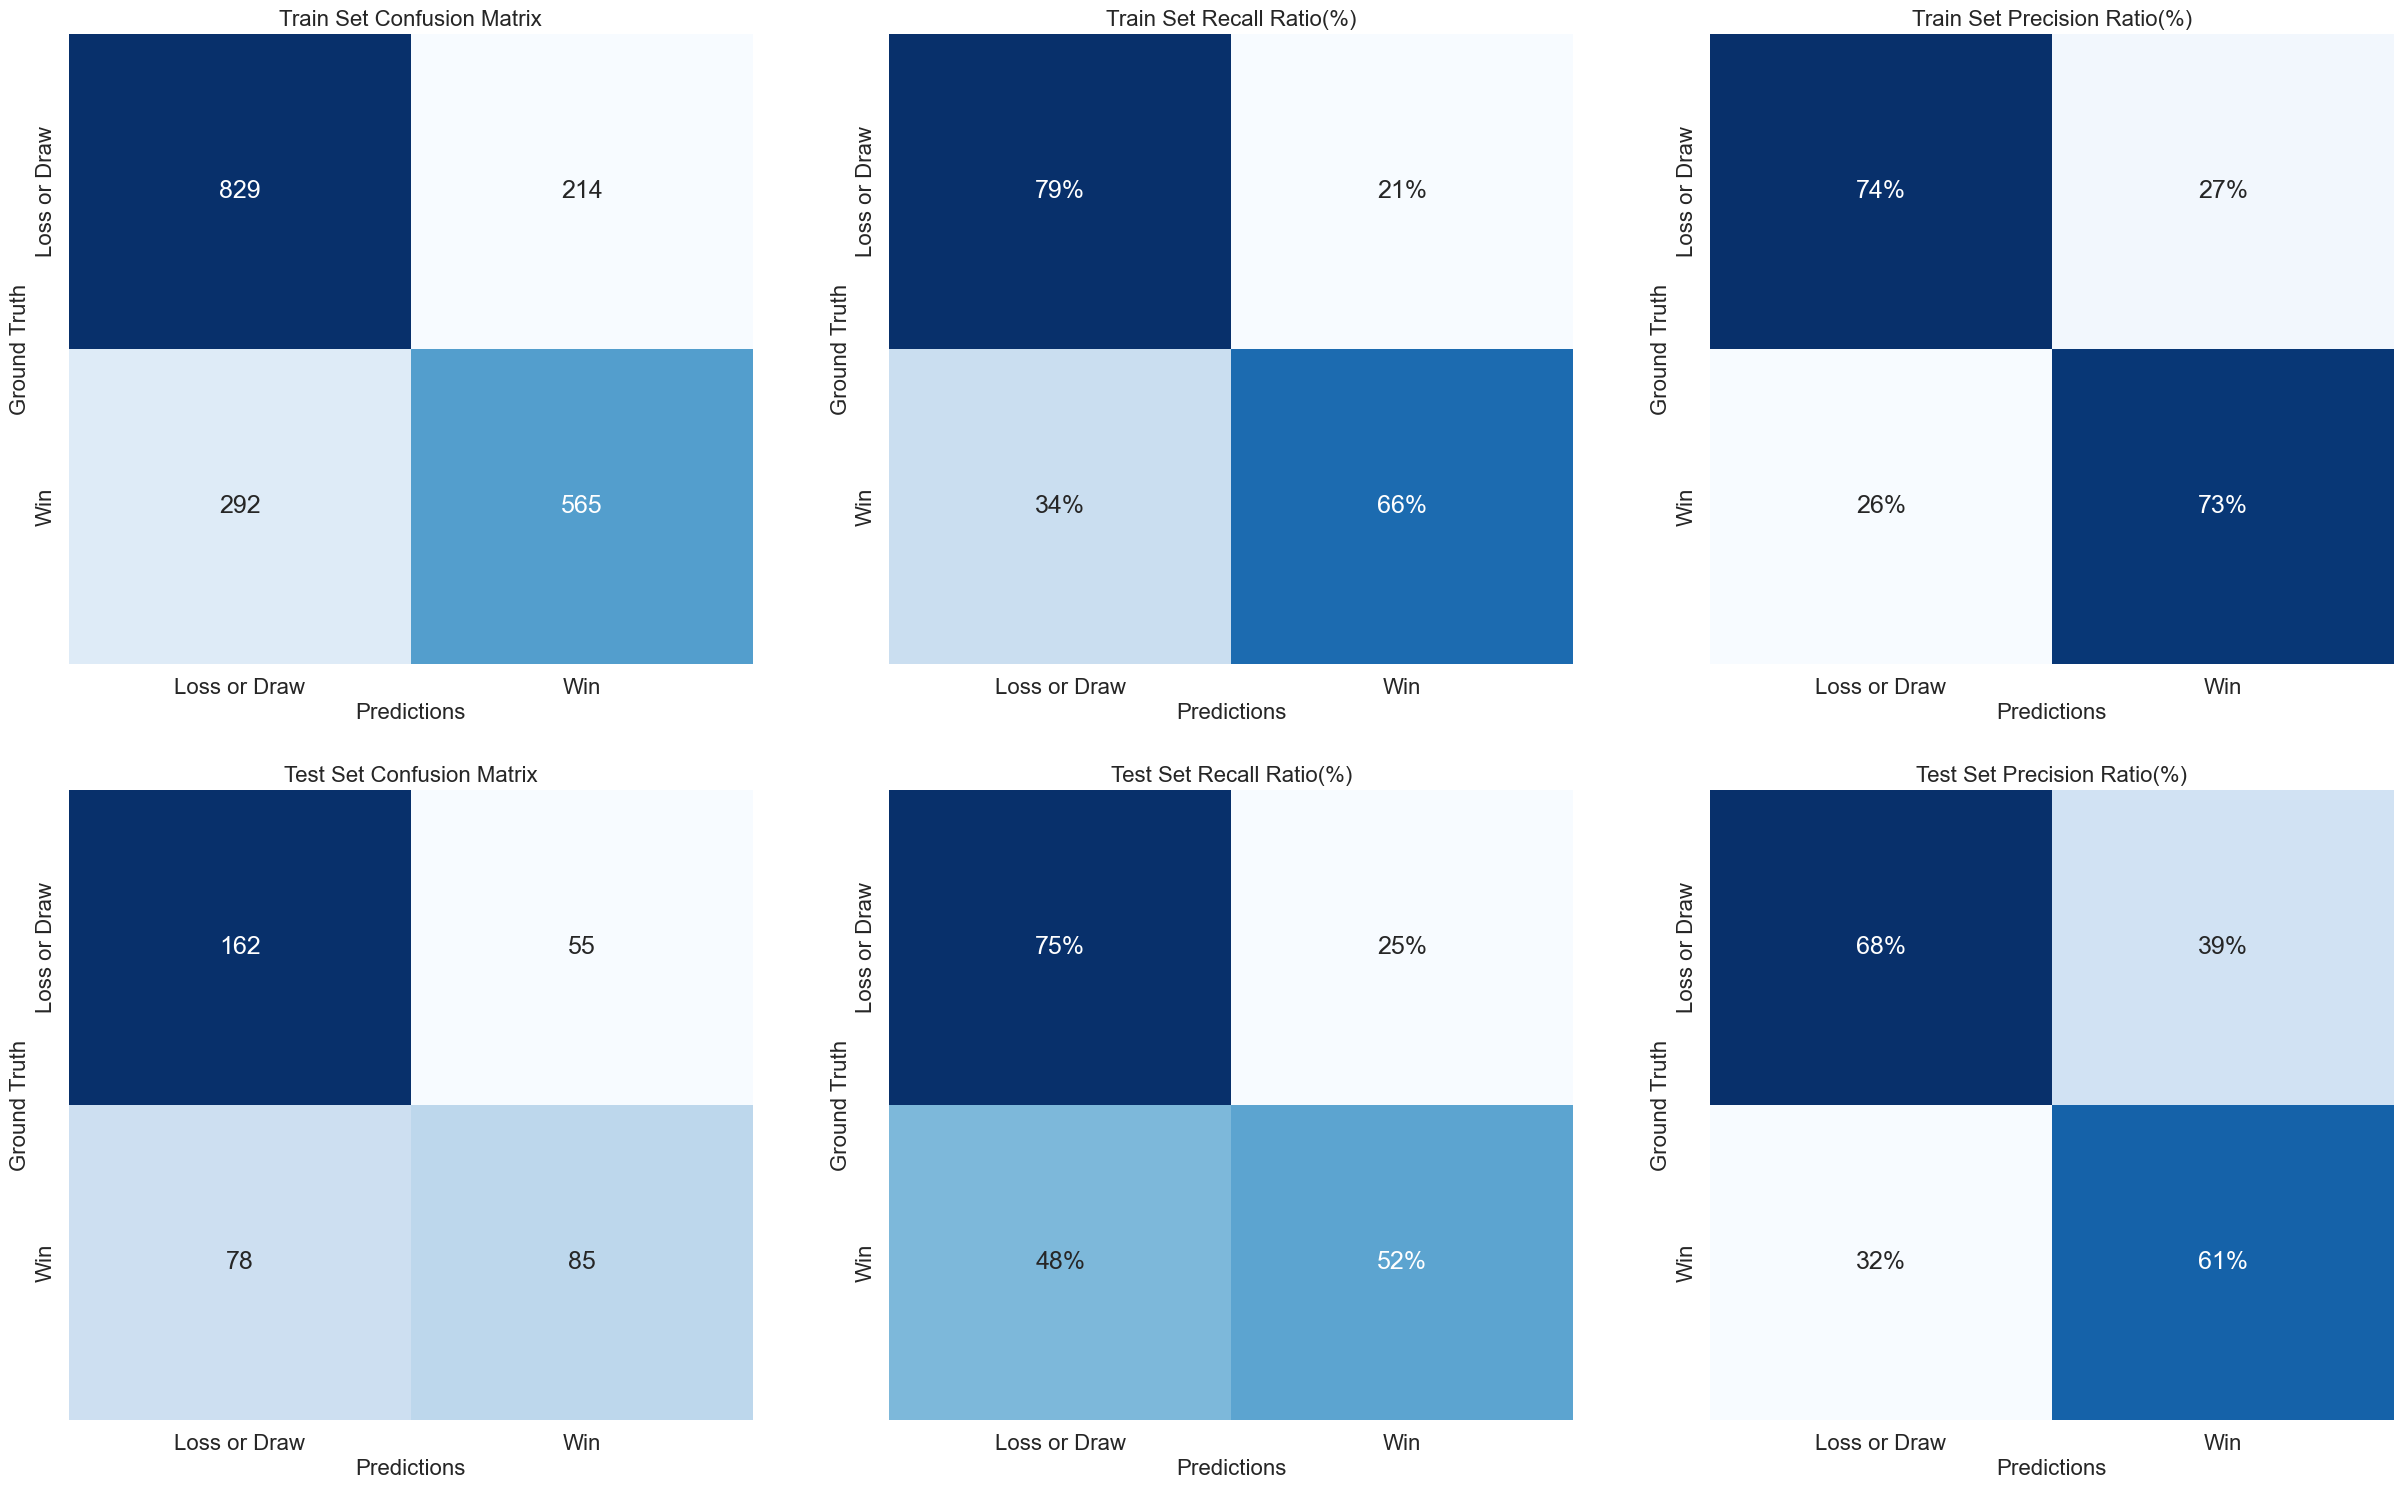

In [70]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = ada_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test)

In [71]:
# Calling the function to evaluate the performance of the classifier
ada_model_summary_df = evaluate_model_performance(model = ada_model, 
                                                  train_features = X_train, 
                                                  train_labels = y_train, 
                                                  test_features = X_test, 
                                                  test_labels = y_test,
                                                  algorithm_name = 'Adaptive Boosting')
ada_model_summary_df

Train Balanced Accuracy  Test Balanced Accuracy  Accuracy  \
Adaptive Boosting                     0.73                    0.63      0.65   

                   Precision  Recall  F0.5   AUC  Brier Score Loss  \
Adaptive Boosting       0.61    0.52  0.59  0.68              0.24   

                   Train Threshold  Test Threshold  
Adaptive Boosting              0.5             0.5

***
### Gradient Boosted Machine (GBM)

In [72]:
# Building a classifier
gbm_model = build_pipeline(classifier = GradientBoostingClassifier(random_state = 42), 
                           data_frame = df, 
                           train_features = X_train, 
                           train_labels = y_train, 
                           apply_bayesian_optimization = False,
                           scale = False,
                           drop_high_vif_features = False,
                           feature_selection_method = 'meta')

# Logging information to the log file
logging.info(msg = 'Gradient Boosted Machine model has been built')
 
# Displaying the architecture of the classifier
gbm_model

Pipeline(steps=[('feature_reallocator', FeatureReallocator()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('binary_pipeline',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['is_boxing_day',
                                                   'finished_top_4_last_season_h',
                                                   'finished_top_4_last_season_a',
                                                   'won_carabao_cup_last_seaso...
                                                   'total_avg_shots_on_target_last_5_h',
                                                   'total_avg_shots_on_target_last_5_a',
                                                   'total_avg_shots_h',
                                                   'total_avg_shots_a',
                                                   'total_avg_shots_last_3_h',
                                                   'total_avg_shots_last_3_a',
                                                   'total_avg_shots_last_5_h',
                                                   'total_avg_shots_last_5_a', ...])])),
                ('feature_selector',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=42))),
                ('classifier', GradientBoostingClassifier(random_state=42))])

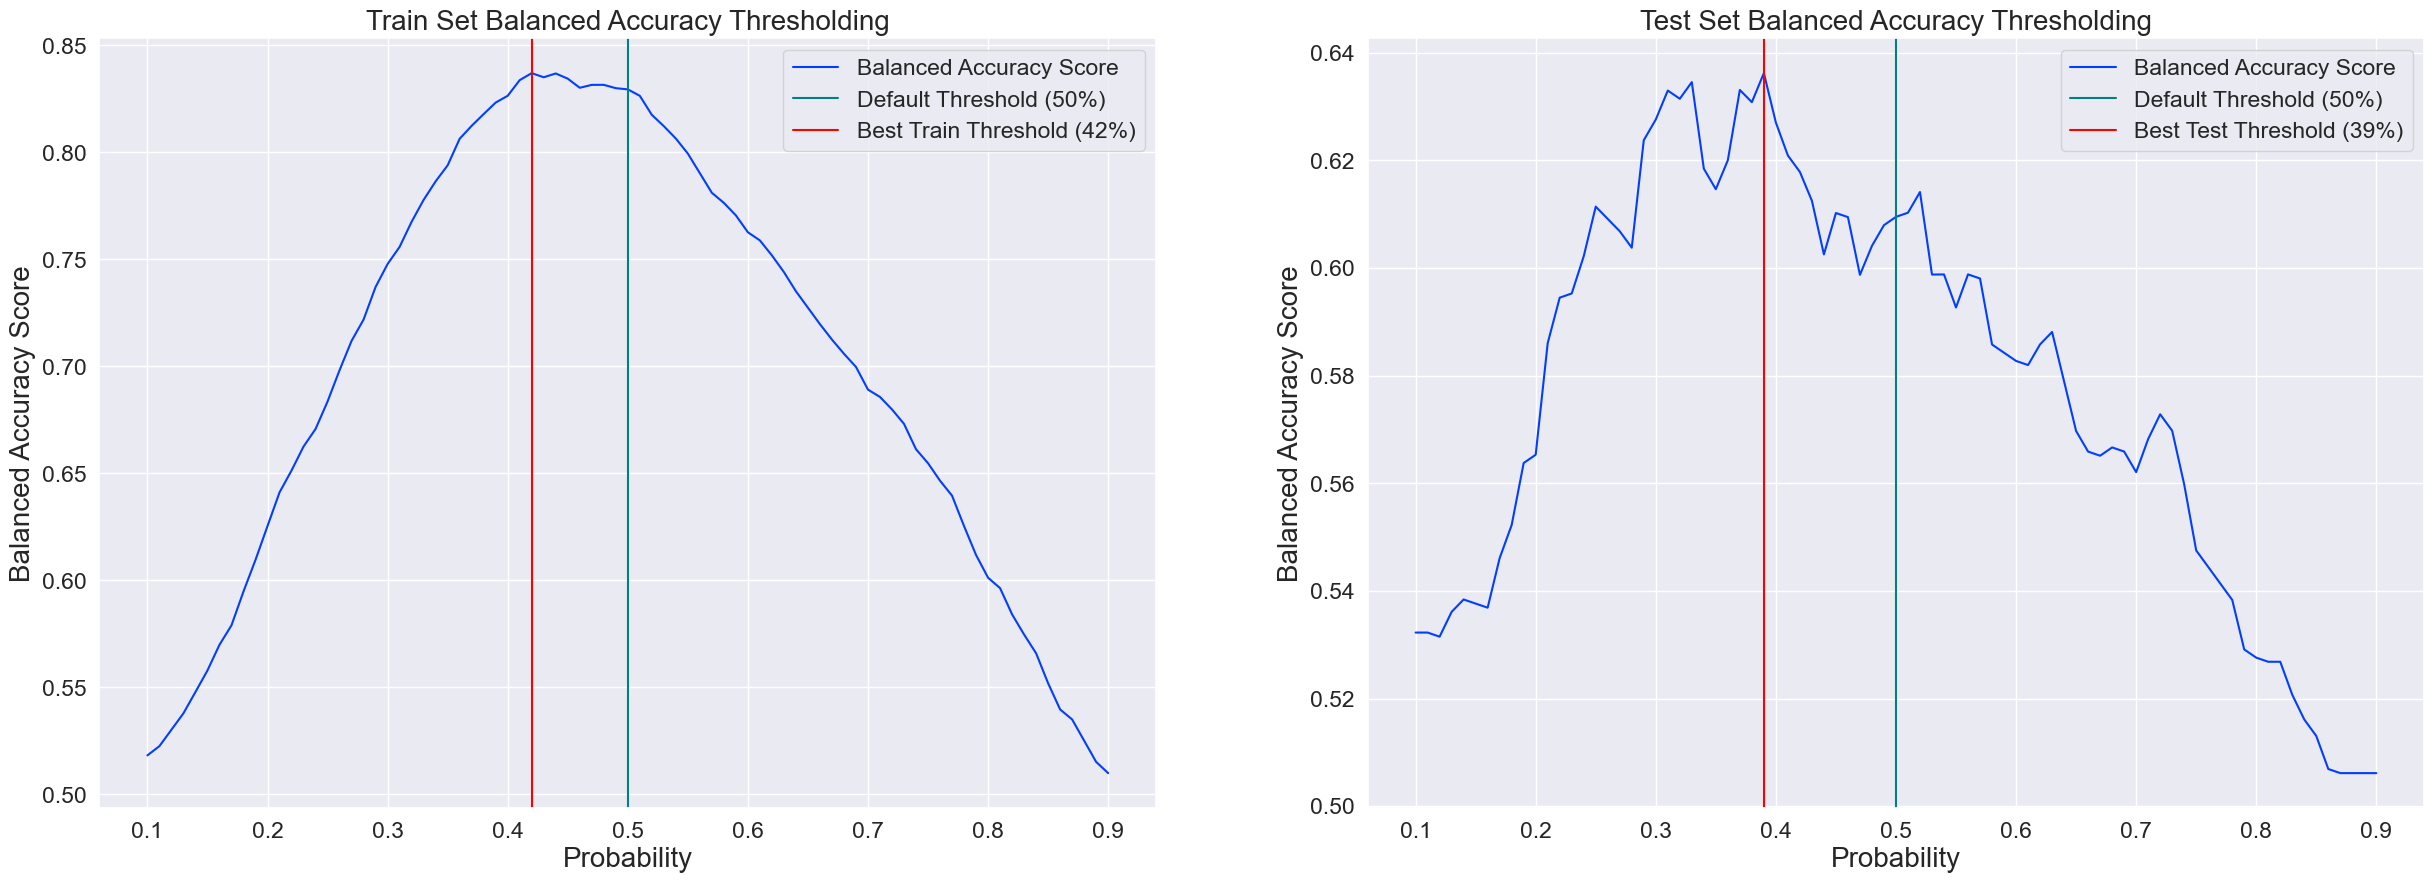

In [73]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = gbm_model, 
                                                         metric = 'balanced_accuracy', 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [74]:
# Calling the function to print out the classification report
print_classification_report(model = gbm_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            algorithm_name = 'Gradient Boosted Machine')

Classification Report Summary for Gradient Boosted Machine Model:

Train report:
              precision    recall  f1-score   support

Loss or Draw       0.87      0.82      0.85      1043
         Win       0.80      0.86      0.82       857

    accuracy                           0.84      1900
   macro avg       0.83      0.84      0.83      1900
weighted avg       0.84      0.84      0.84      1900



Test report:
              precision    recall  f1-score   support

Loss or Draw       0.70      0.64      0.67       217
         Win       0.57      0.63      0.60       163

    accuracy                           0.64       380
   macro avg       0.63      0.64      0.63       380
weighted avg       0.64      0.64      0.64       380



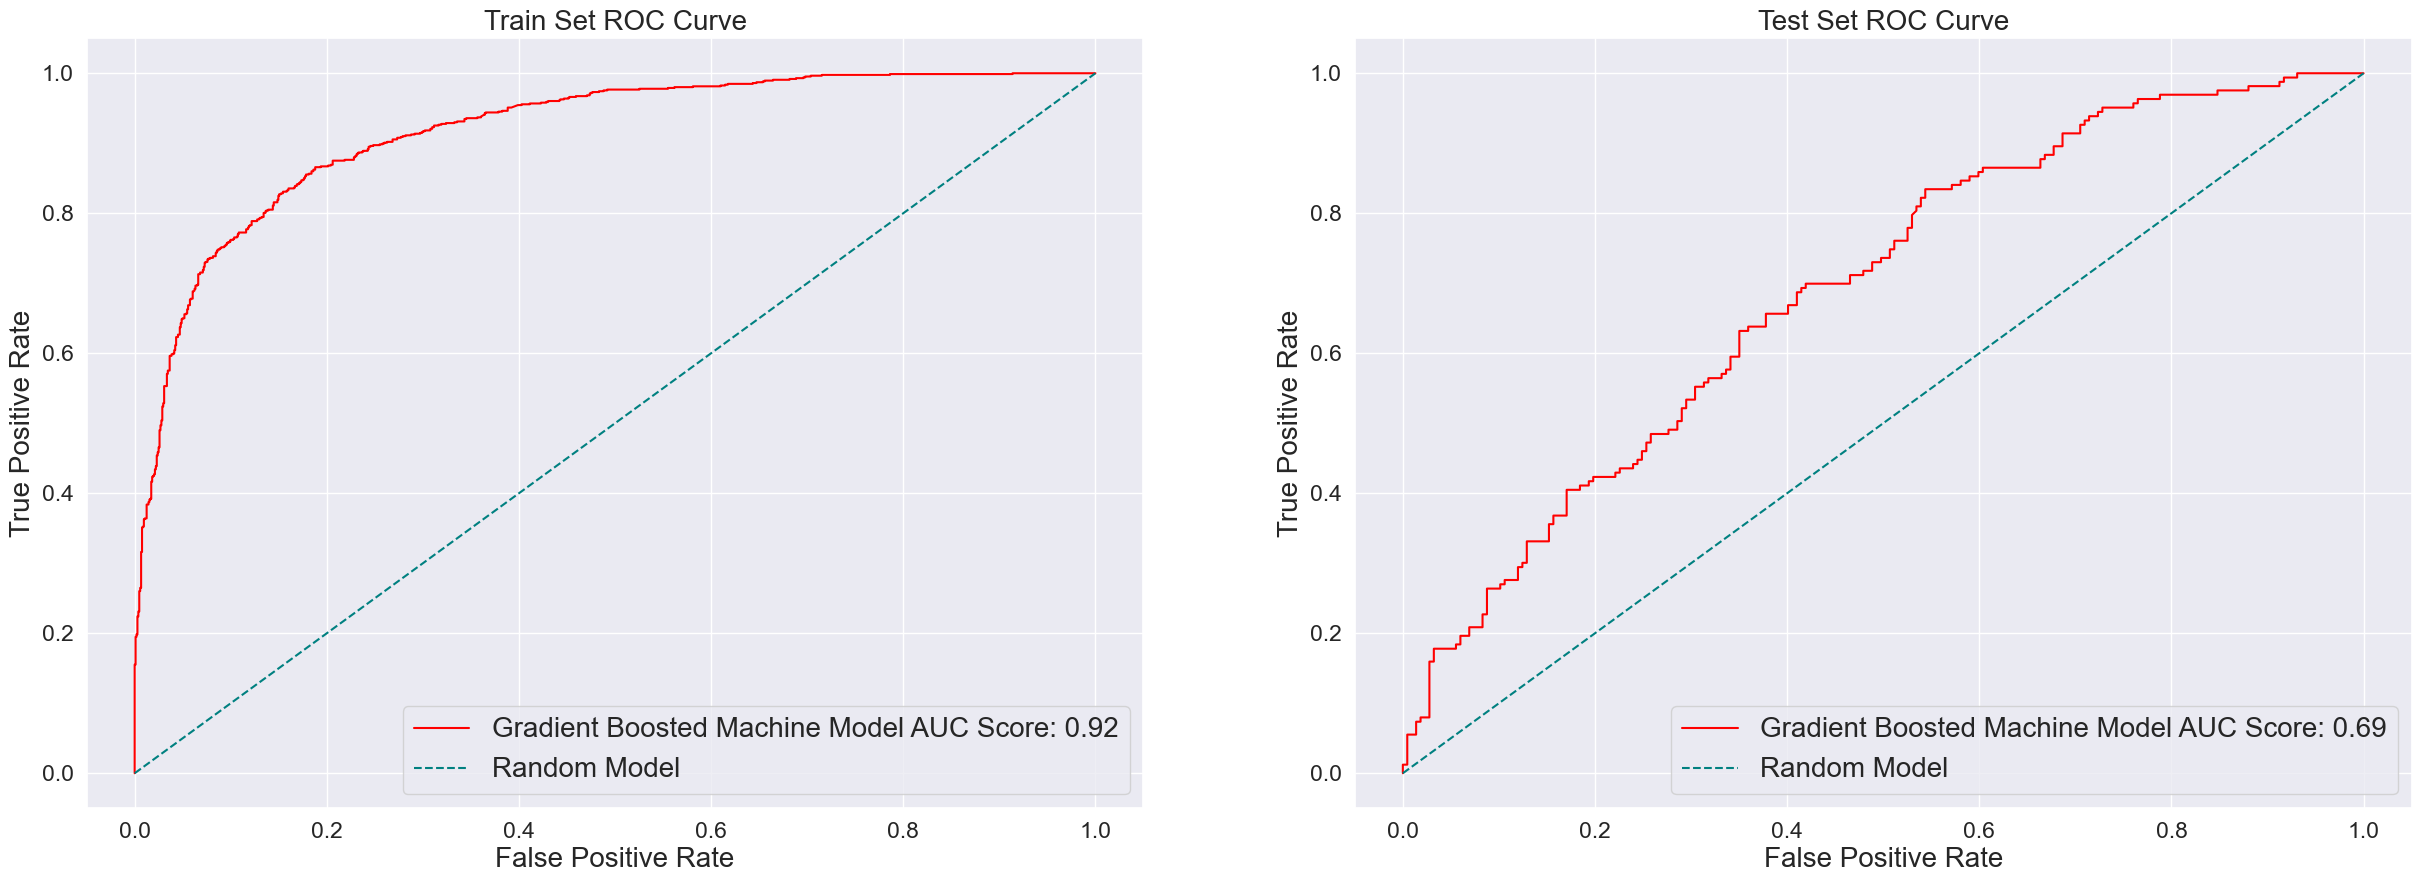

In [75]:
# Calling the function to plot ROC curve
plot_roc_curve(model = gbm_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = 'Gradient Boosted Machine')

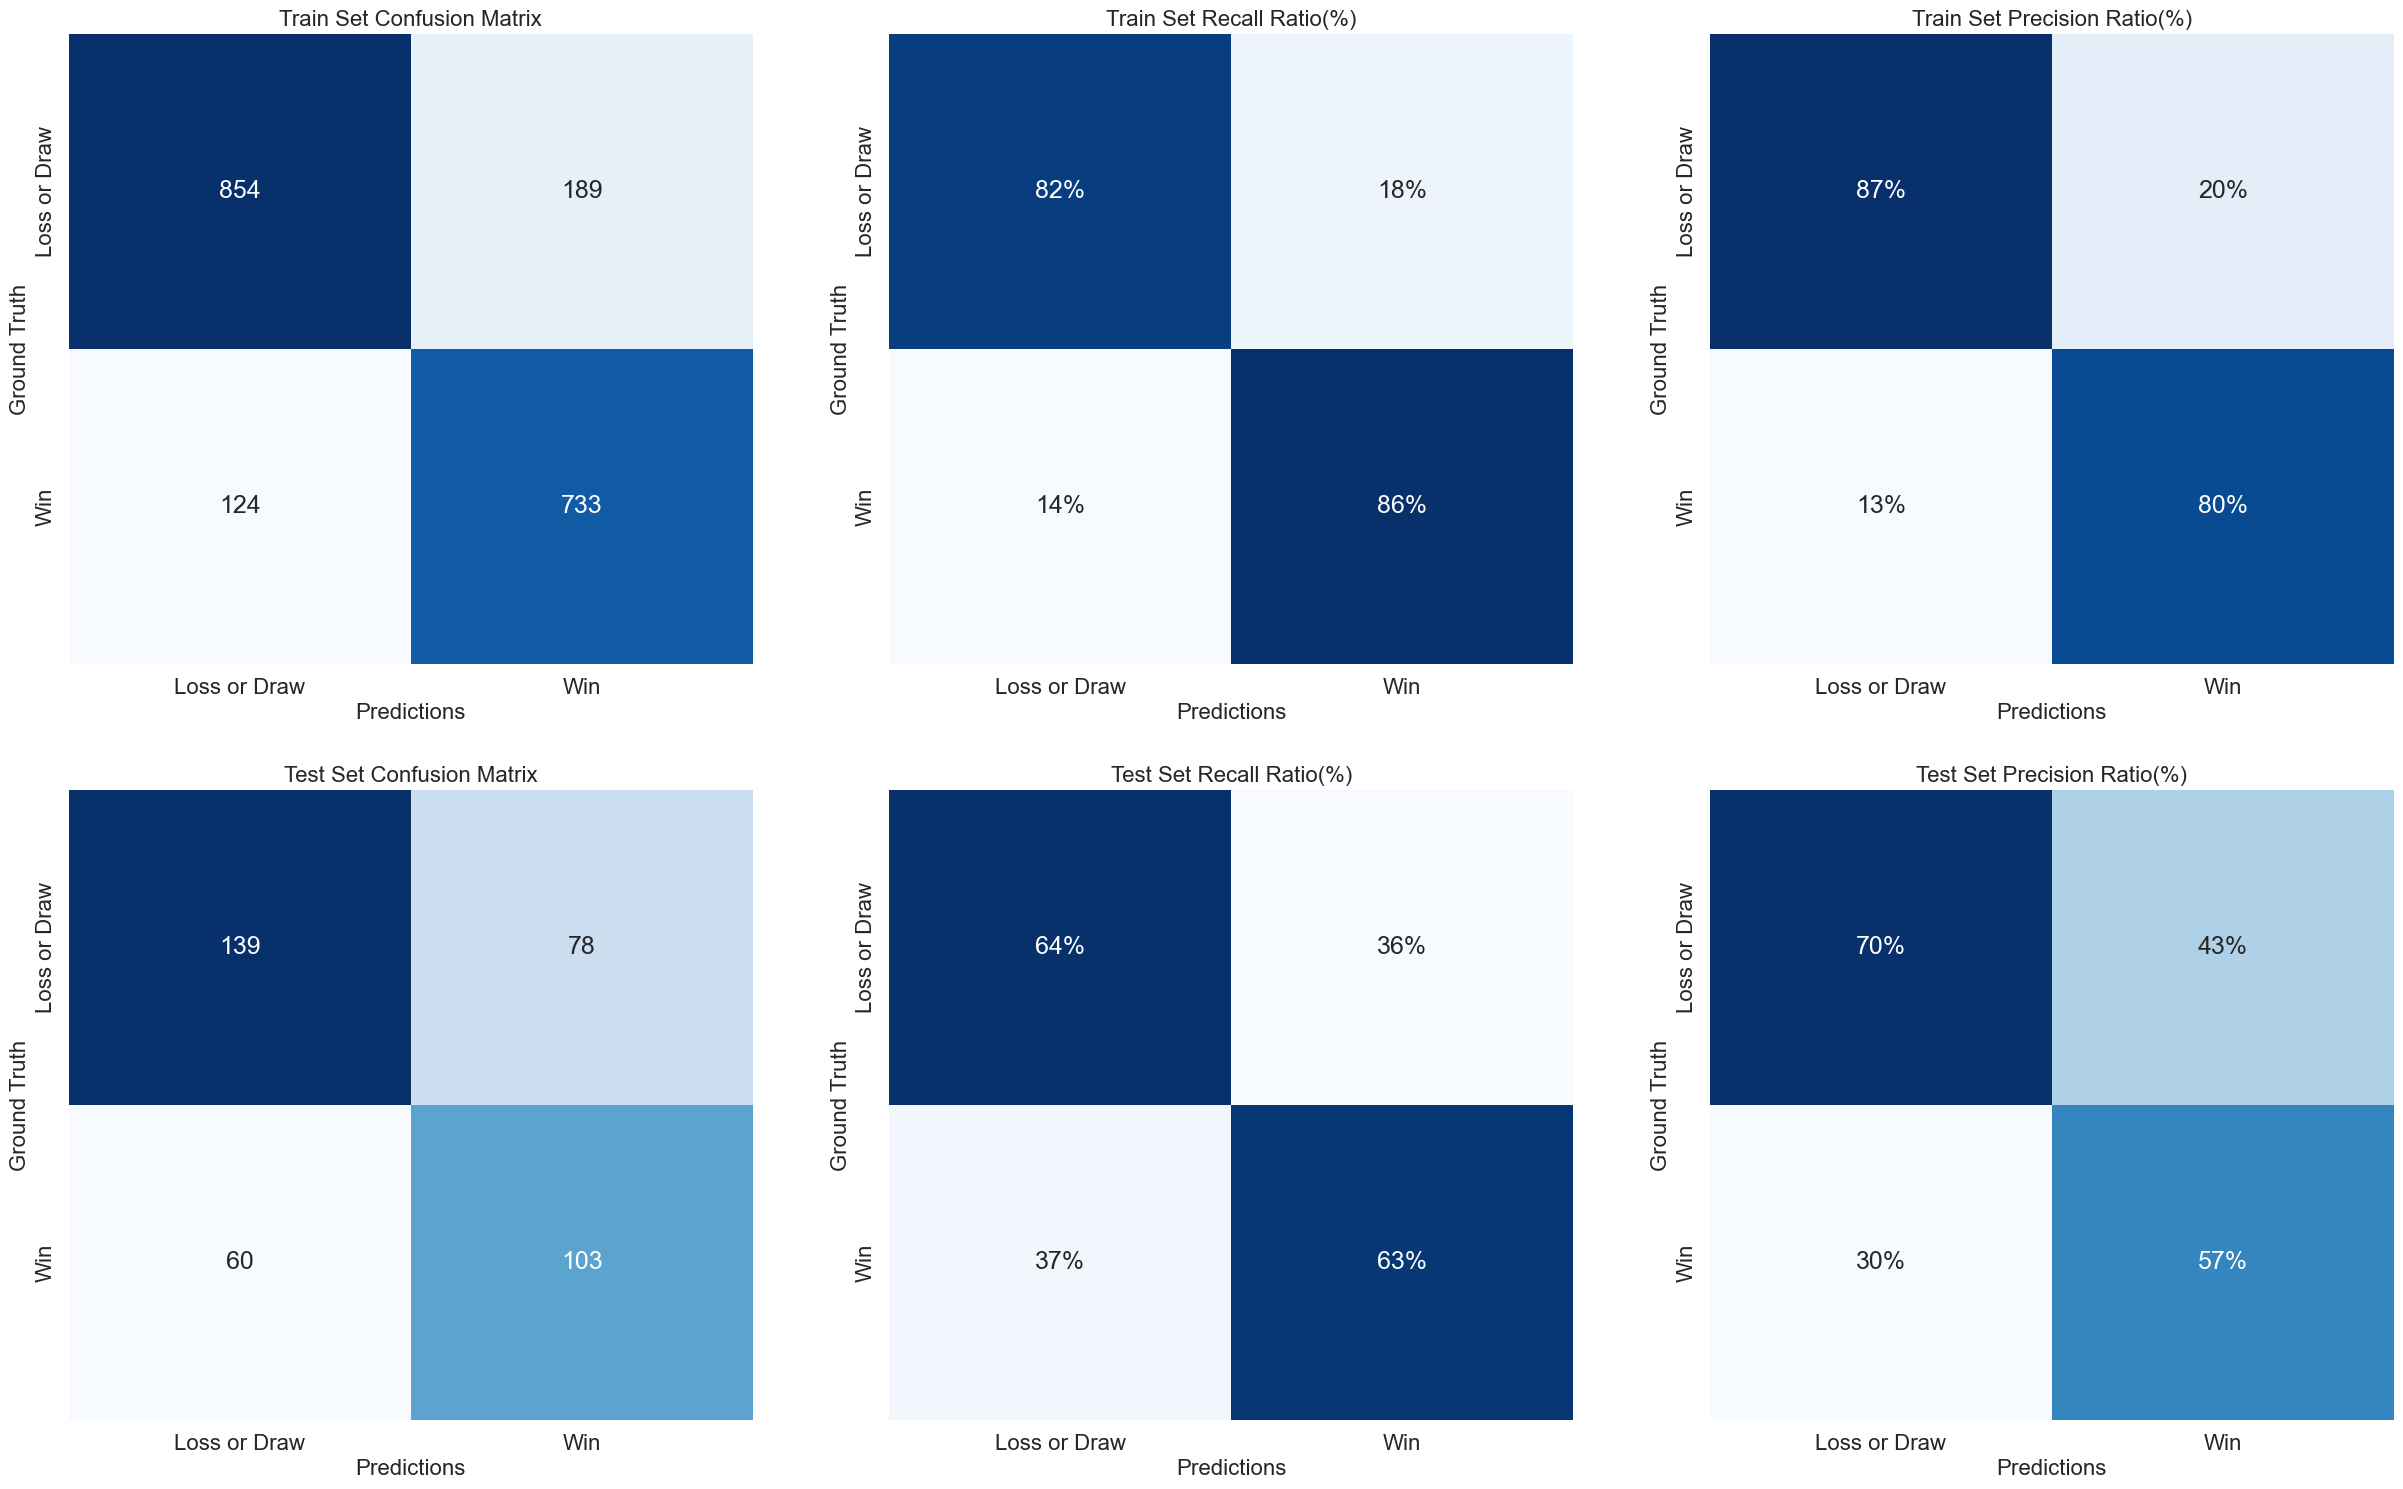

In [76]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = gbm_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test)

In [77]:
# Calling the function to evaluate the performance of the classifier
gbm_model_summary_df = evaluate_model_performance(model = gbm_model, 
                                                  train_features = X_train, 
                                                  train_labels = y_train, 
                                                  test_features = X_test, 
                                                  test_labels = y_test,
                                                  algorithm_name = 'Gradient Boosted Machine')
gbm_model_summary_df

Train Balanced Accuracy  Test Balanced Accuracy  \
Gradient Boosted Machine                     0.84                    0.64   

                          Accuracy  Precision  Recall  F0.5   AUC  \
Gradient Boosted Machine      0.64       0.57    0.63  0.58  0.69   

                          Brier Score Loss  Train Threshold  Test Threshold  
Gradient Boosted Machine              0.22             0.42            0.39

***
### Extreme Gradient Boosted Machine (XGBoost)

In [78]:
# Building a classifier
xgbm_model = build_pipeline(classifier = XGBClassifier(objective = 'binary:logistic', use_label_encoder = False, eval_metric = 'error', random_state = 42), 
                            data_frame = df, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            apply_bayesian_optimization = False,
                            scale = False,
                            drop_high_vif_features = False,
                            feature_selection_method = 'meta')

# Logging information to the log file
logging.info(msg = 'Extreme Gradient Boosted Machine model has been built')
 
# Displaying the architecture of the classifier
xgbm_model

Pipeline(steps=[('feature_reallocator', FeatureReallocator()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('binary_pipeline',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['is_boxing_day',
                                                   'finished_top_4_last_season_h',
                                                   'finished_top_4_last_season_a',
                                                   'won_carabao_cup_last_seaso...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=10, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))])

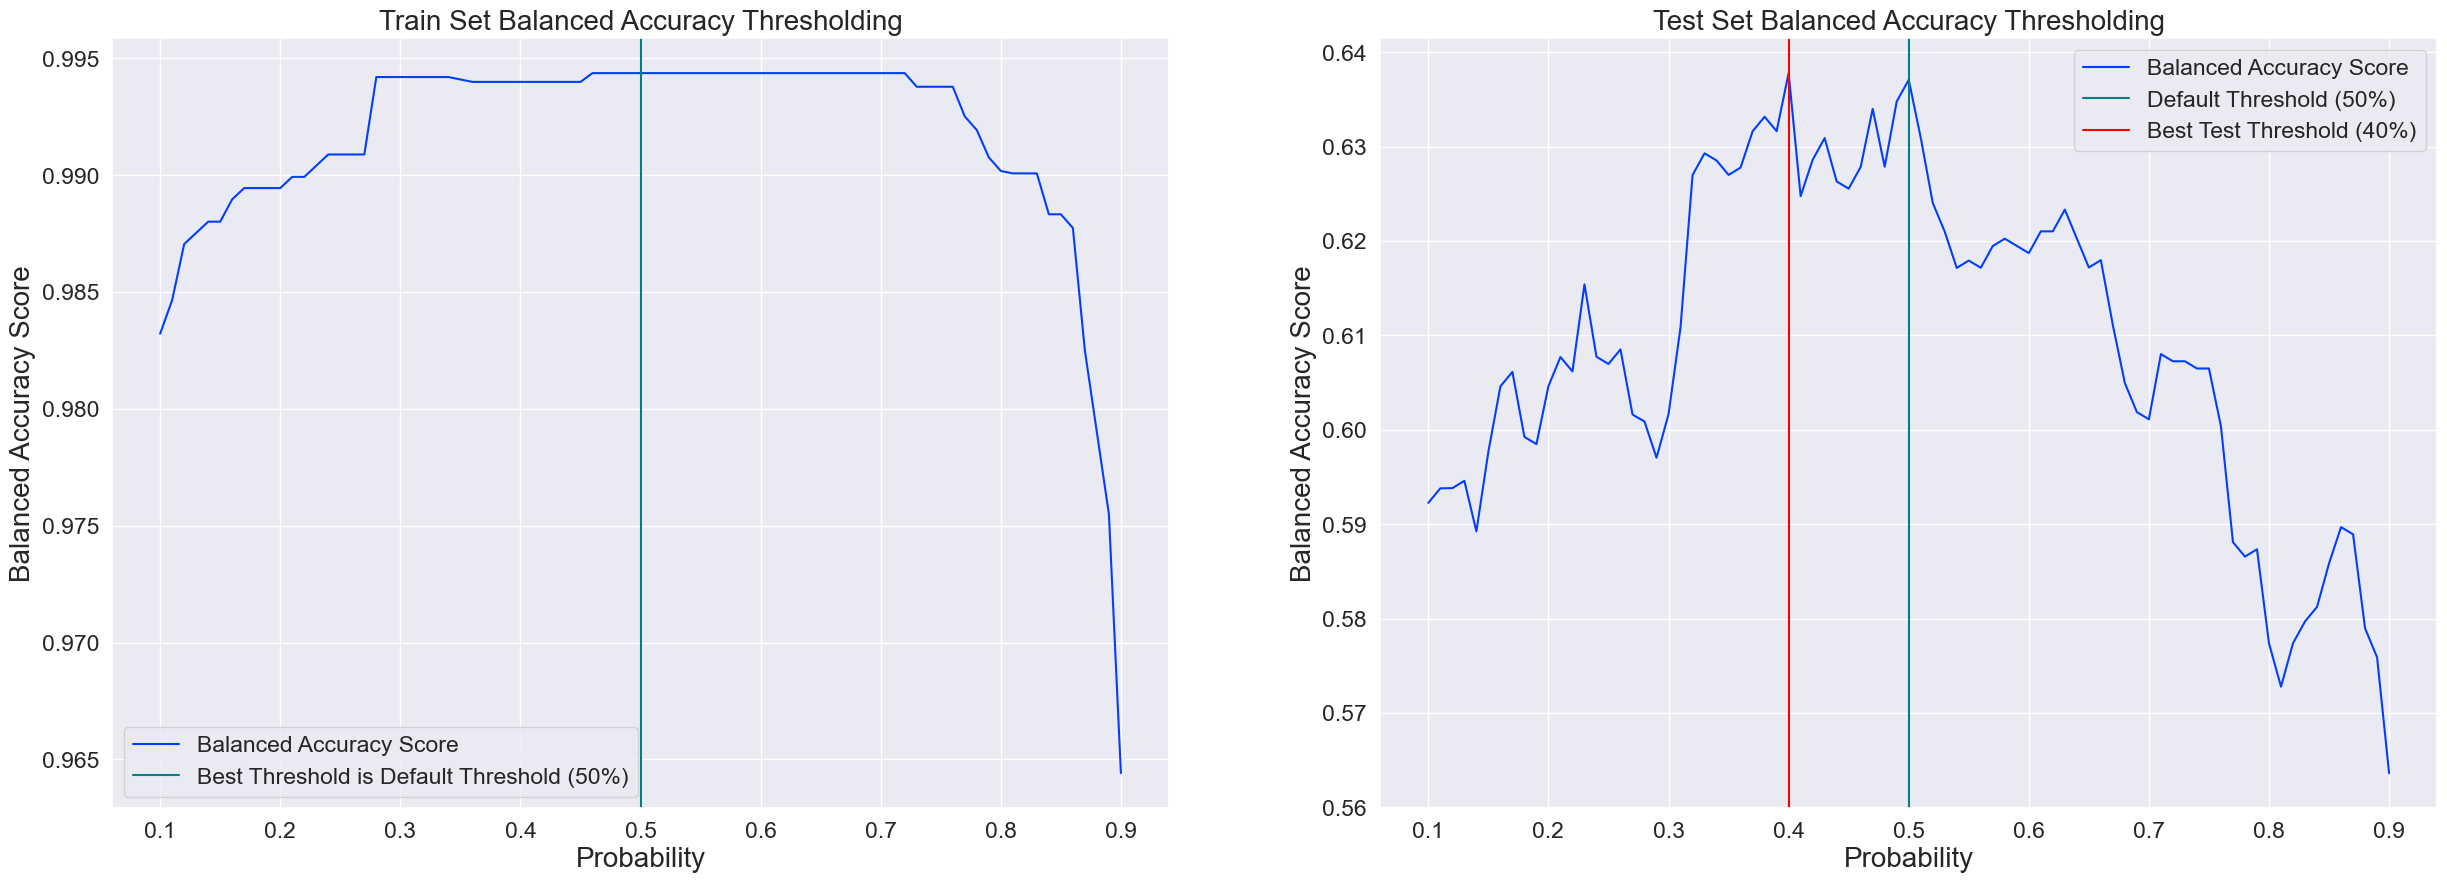

In [79]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = xgbm_model, 
                                                         metric = 'balanced_accuracy', 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [80]:
# Calling the function to print out the classification report
print_classification_report(model = xgbm_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            algorithm_name = 'Extreme Gradient Boosted Machine')

Classification Report Summary for Extreme Gradient Boosted Machine Model:

Train report:
              precision    recall  f1-score   support

Loss or Draw       0.99      1.00      1.00      1043
         Win       1.00      0.99      0.99       857

    accuracy                           0.99      1900
   macro avg       1.00      0.99      0.99      1900
weighted avg       0.99      0.99      0.99      1900



Test report:
              precision    recall  f1-score   support

Loss or Draw       0.69      0.69      0.69       217
         Win       0.59      0.59      0.59       163

    accuracy                           0.64       380
   macro avg       0.64      0.64      0.64       380
weighted avg       0.65      0.64      0.64       380



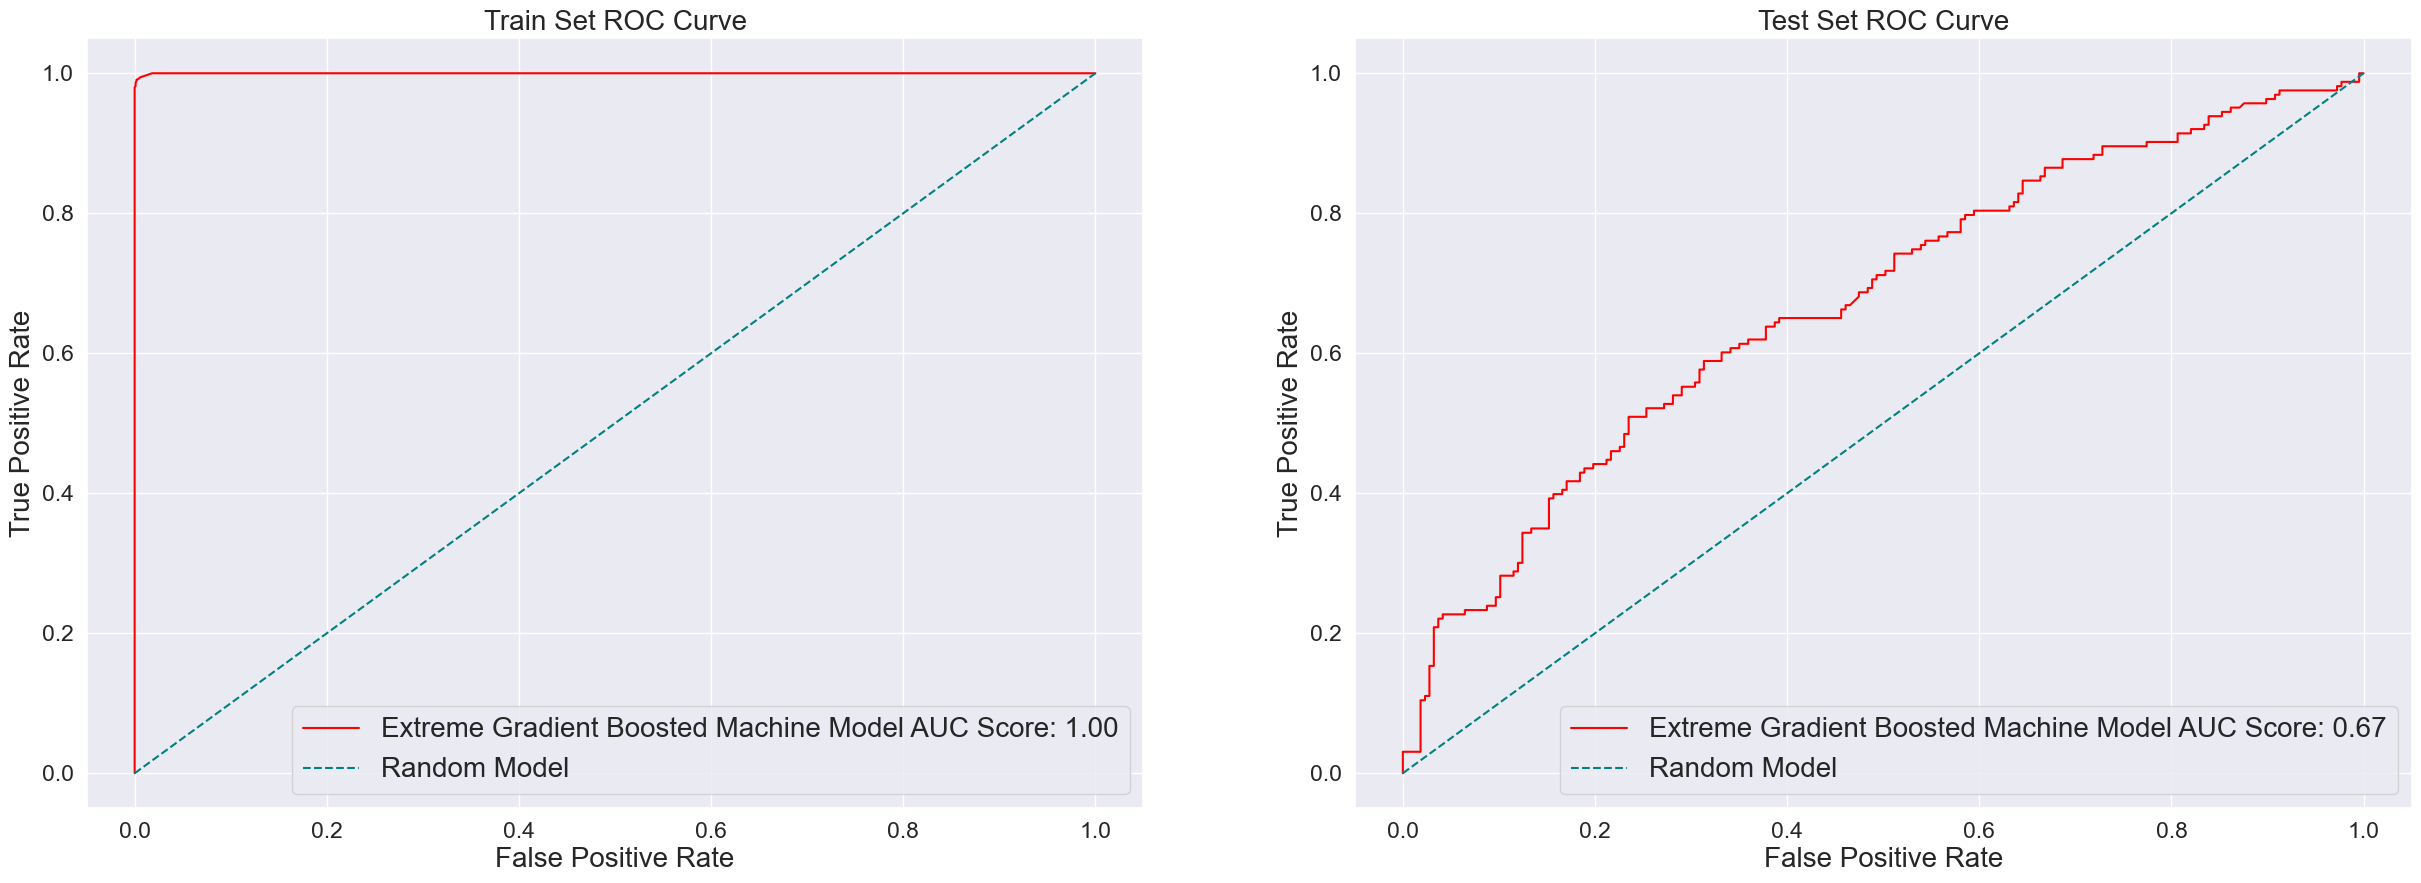

In [81]:
# Calling the function to plot ROC curve
plot_roc_curve(model = xgbm_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = 'Extreme Gradient Boosted Machine')

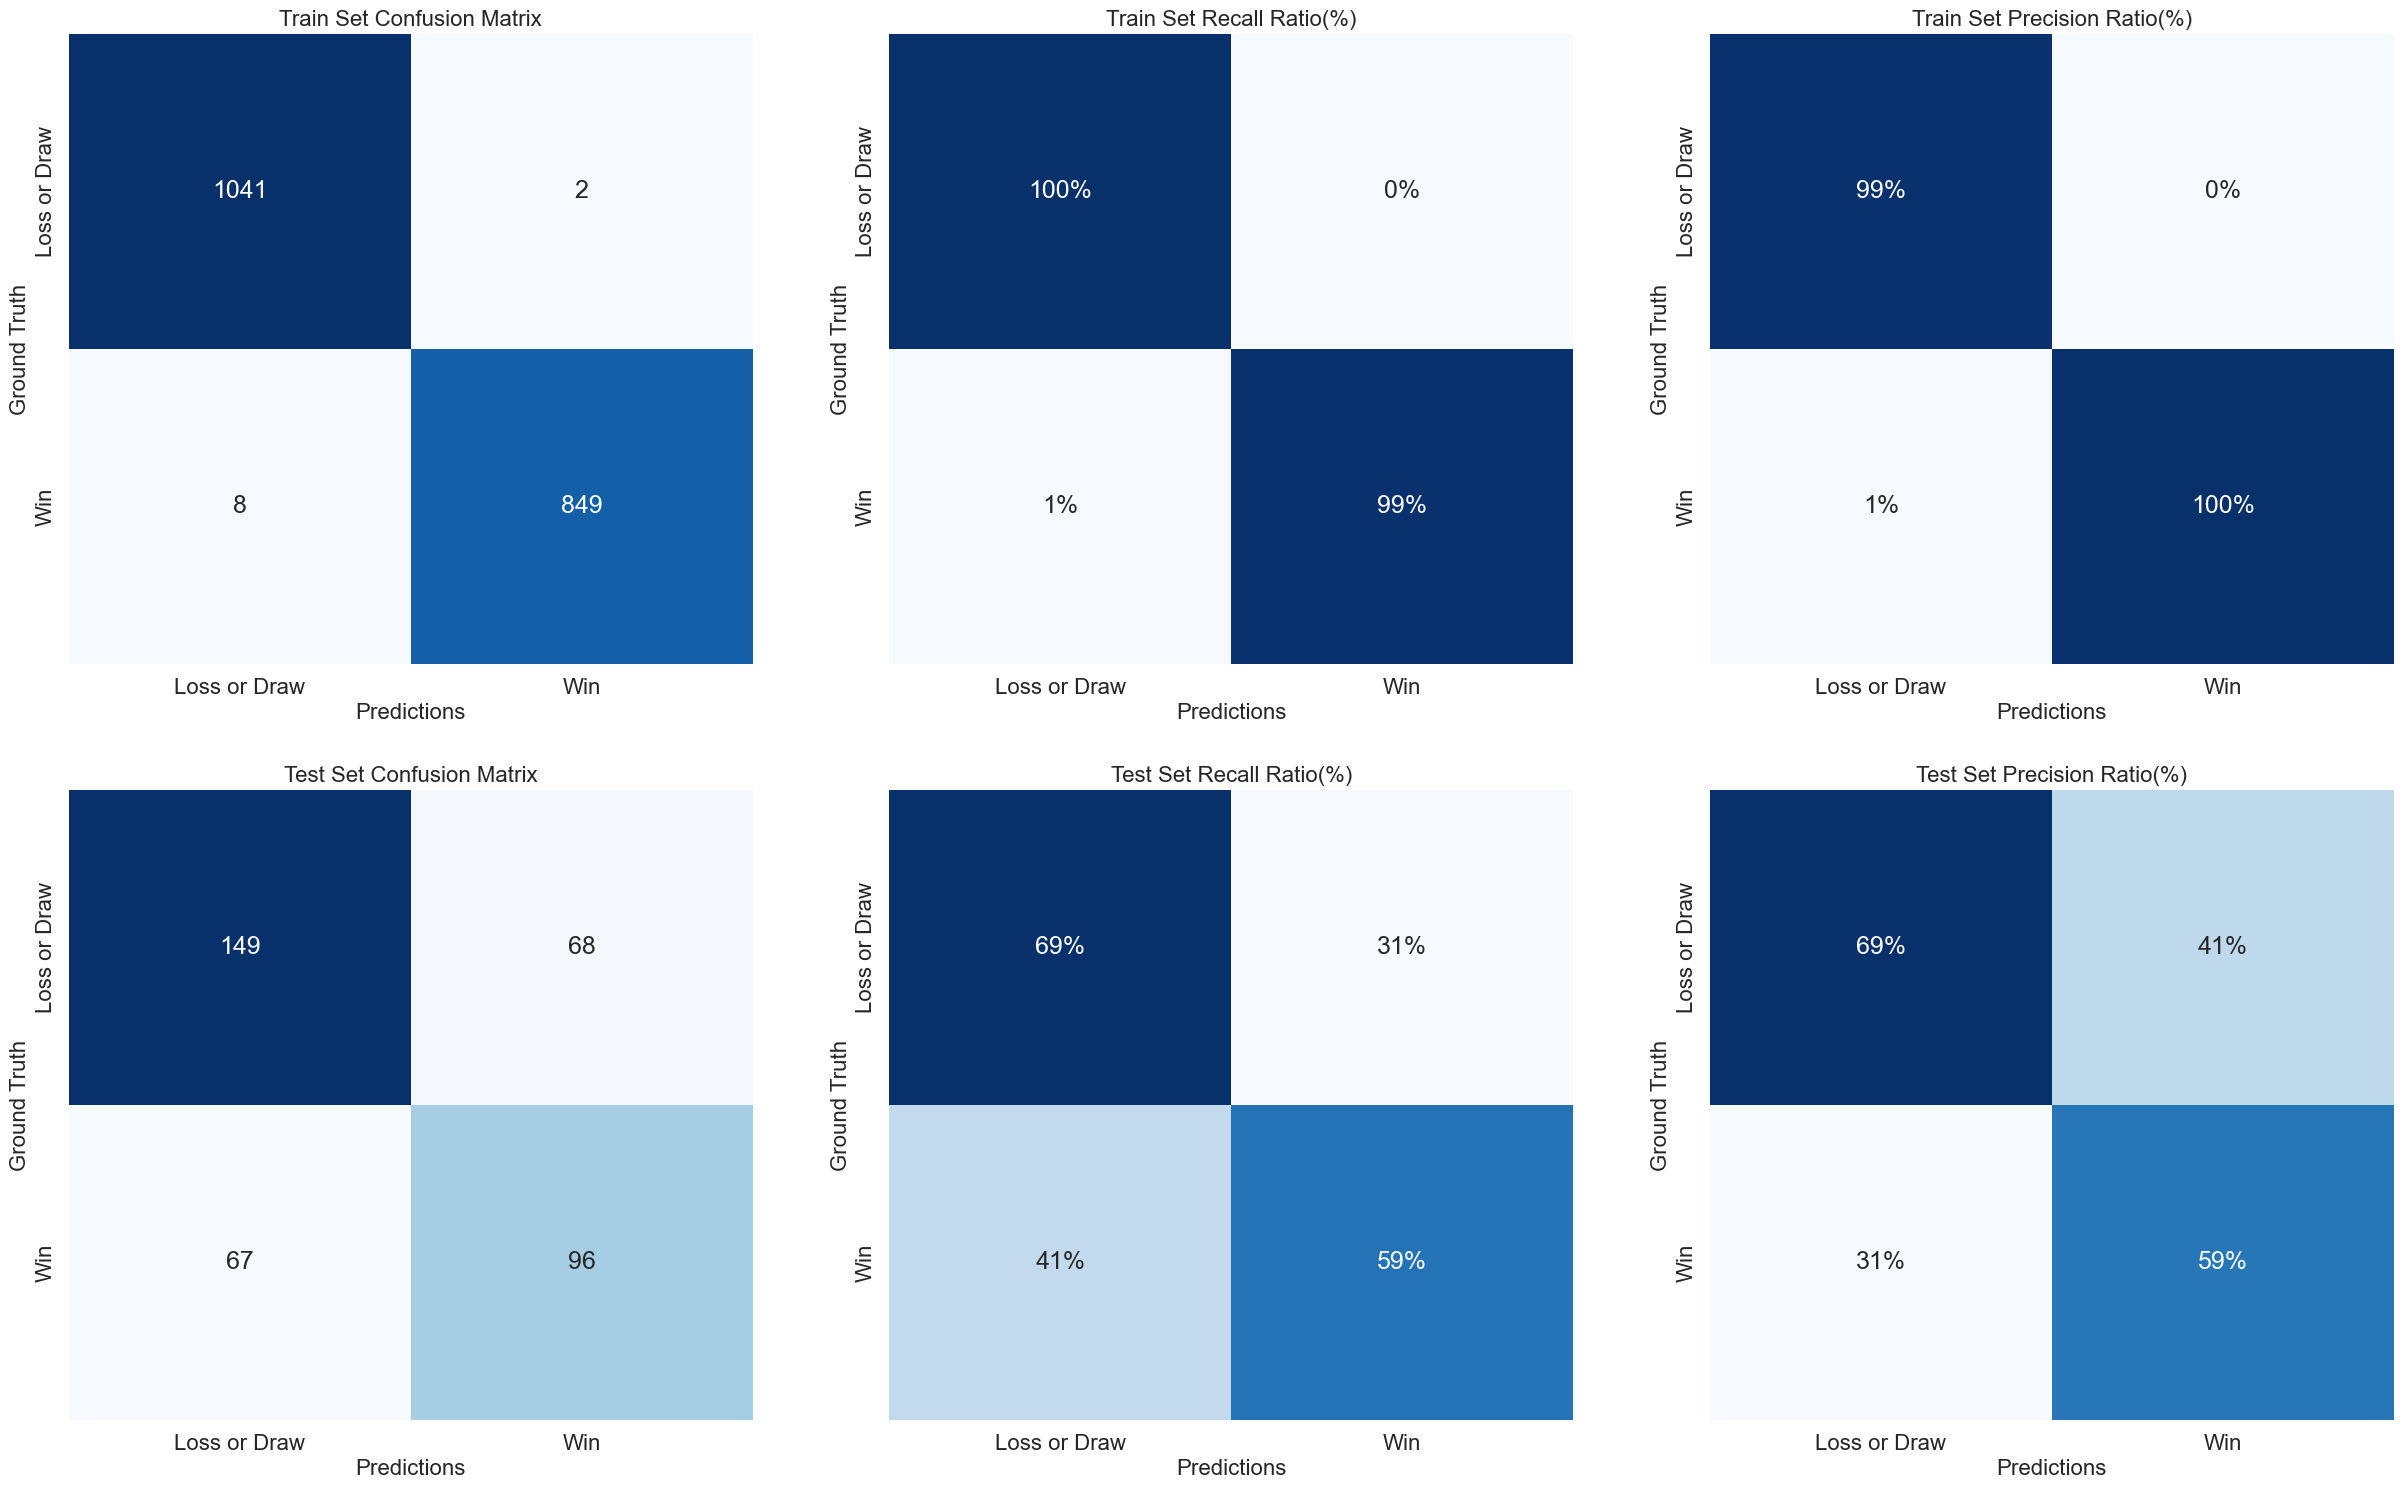

In [82]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = xgbm_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test)

In [83]:
# Calling the function to evaluate the performance of the classifier
xgbm_model_summary_df = evaluate_model_performance(model = xgbm_model, 
                                                   train_features = X_train, 
                                                   train_labels = y_train, 
                                                   test_features = X_test, 
                                                   test_labels = y_test,
                                                   algorithm_name = 'Extreme Gradient Boosted Machine')
xgbm_model_summary_df

Train Balanced Accuracy  \
Extreme Gradient Boosted Machine                     0.99   

                                  Test Balanced Accuracy  Accuracy  Precision  \
Extreme Gradient Boosted Machine                    0.64      0.64       0.59   

                                  Recall  F0.5   AUC  Brier Score Loss  \
Extreme Gradient Boosted Machine    0.59  0.59  0.67              0.25   

                                  Train Threshold  Test Threshold  
Extreme Gradient Boosted Machine              0.5             0.4

***
### Category Boosting (CatBoost)

In [84]:
# Building a classifier
catb_model = build_pipeline(classifier = CatBoostClassifier(eval_metric = 'BalancedAccuracy', task_type = 'CPU', verbose = False, random_state = 42), 
                            data_frame = df, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            apply_bayesian_optimization = False,
                            scale = False,
                            drop_high_vif_features = False,
                            feature_selection_method = 'meta')

# Logging information to the log file
logging.info(msg = 'Category Boosting model has been built')

# Removing the log folder
shutil.rmtree(path = 'catboost_info')
 
# Displaying the architecture of the classifier
catb_model

Pipeline(steps=[('feature_reallocator', FeatureReallocator()),
                ('feature_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('binary_pipeline',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['is_boxing_day',
                                                   'finished_top_4_last_season_h',
                                                   'finished_top_4_last_season_a',
                                                   'won_carabao_cup_last_seaso...
                                                   'total_avg_shots_on_target_last_5_a',
                                                   'total_avg_shots_h',
                                                   'total_avg_shots_a',
                                                   'total_avg_shots_last_3_h',
                                                   'total_avg_shots_last_3_a',
                                                   'total_avg_shots_last_5_h',
                                                   'total_avg_shots_last_5_a', ...])])),
                ('feature_selector',
                 SelectFromModel(estimator=<catboost.core.CatBoostClassifier object at 0x7fa5f80c3c10>)),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7fa5f80c3c10>)])

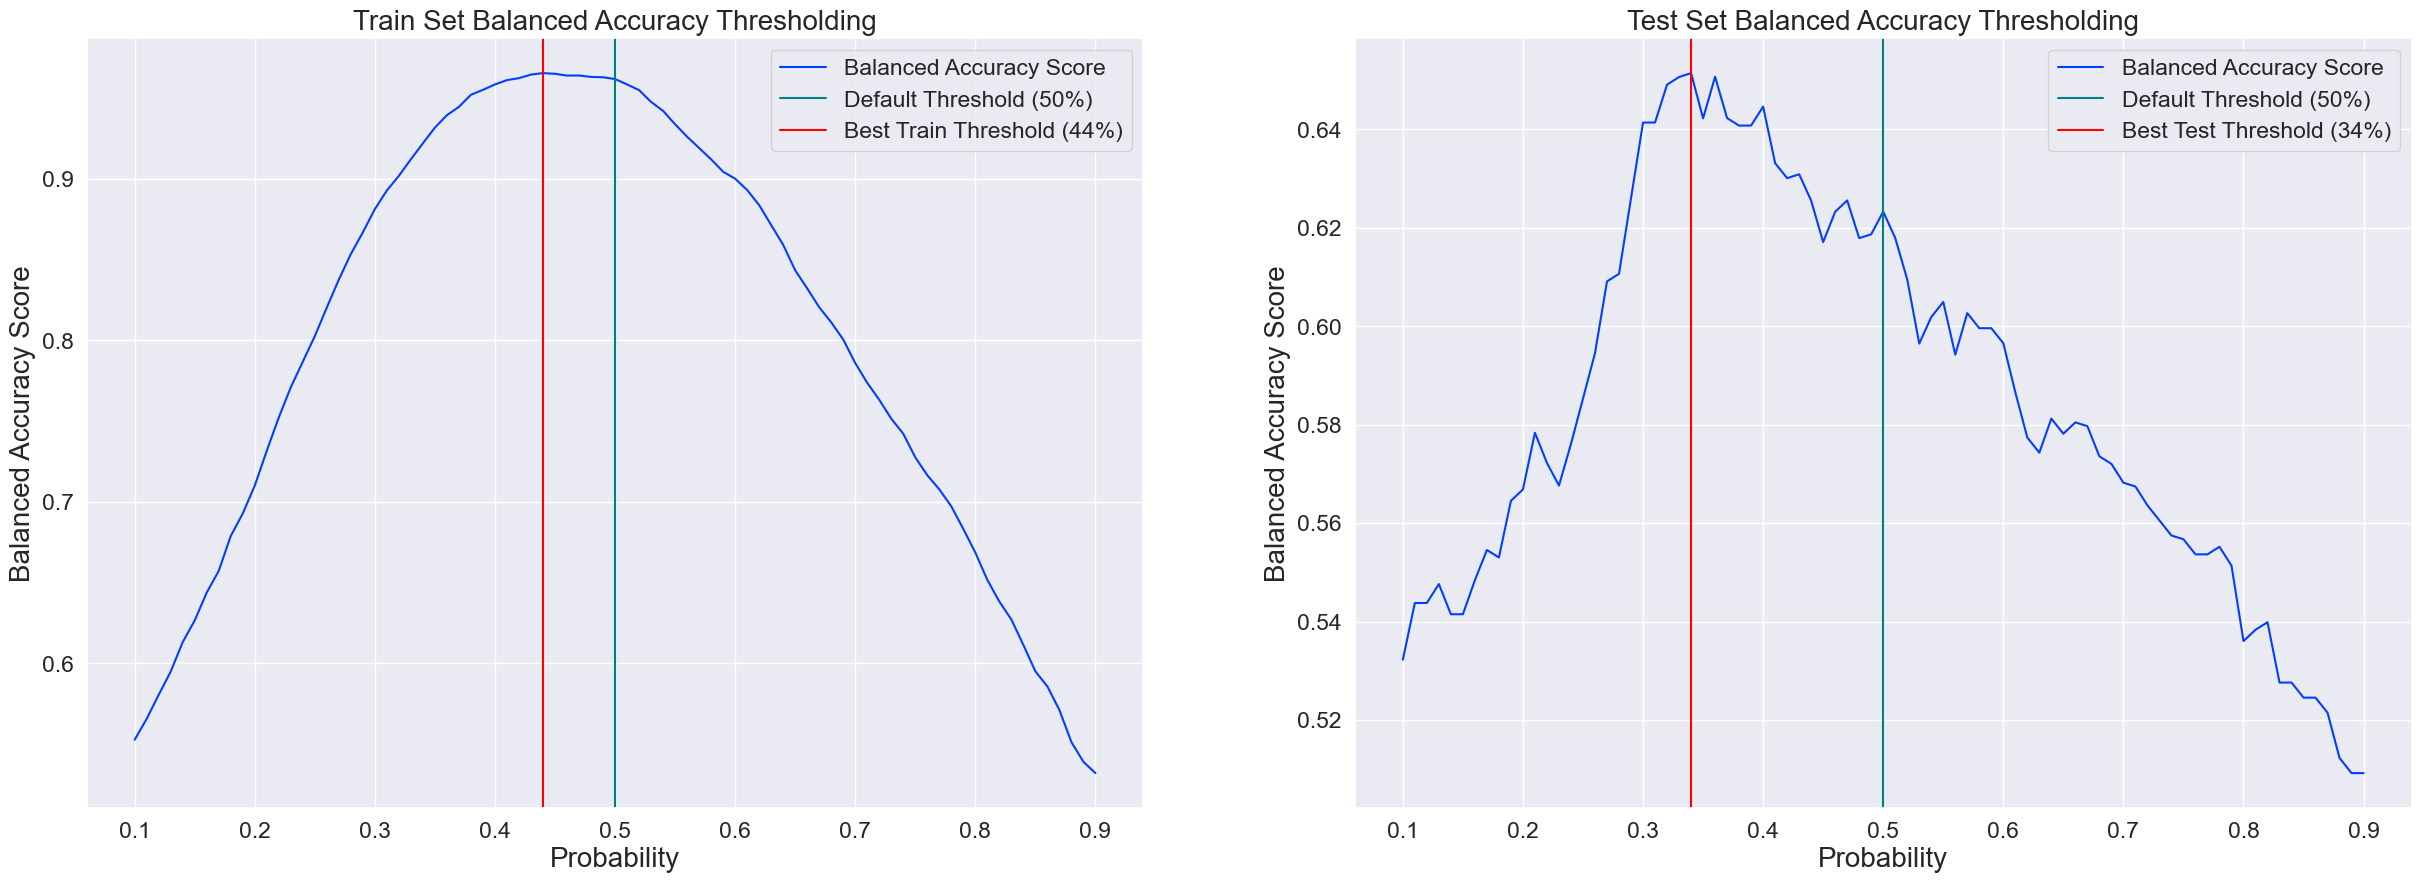

In [85]:
# Calling the function to find the best probability thresholds
train_threshold, test_threshold = find_optimal_threshold(model = catb_model, 
                                                         metric = 'balanced_accuracy', 
                                                         train_features = X_train, 
                                                         train_labels = y_train, 
                                                         test_features = X_test, 
                                                         test_labels = y_test)

In [86]:
# Calling the function to print out the classification report
print_classification_report(model = catb_model, 
                            train_features = X_train, 
                            train_labels = y_train, 
                            test_features = X_test, 
                            test_labels = y_test, 
                            algorithm_name = 'Category Boosting')

Classification Report Summary for Category Boosting Model:

Train report:
              precision    recall  f1-score   support

Loss or Draw       0.98      0.96      0.97      1043
         Win       0.95      0.97      0.96       857

    accuracy                           0.96      1900
   macro avg       0.96      0.97      0.96      1900
weighted avg       0.96      0.96      0.96      1900



Test report:
              precision    recall  f1-score   support

Loss or Draw       0.78      0.49      0.60       217
         Win       0.55      0.81      0.65       163

    accuracy                           0.63       380
   macro avg       0.66      0.65      0.63       380
weighted avg       0.68      0.63      0.62       380



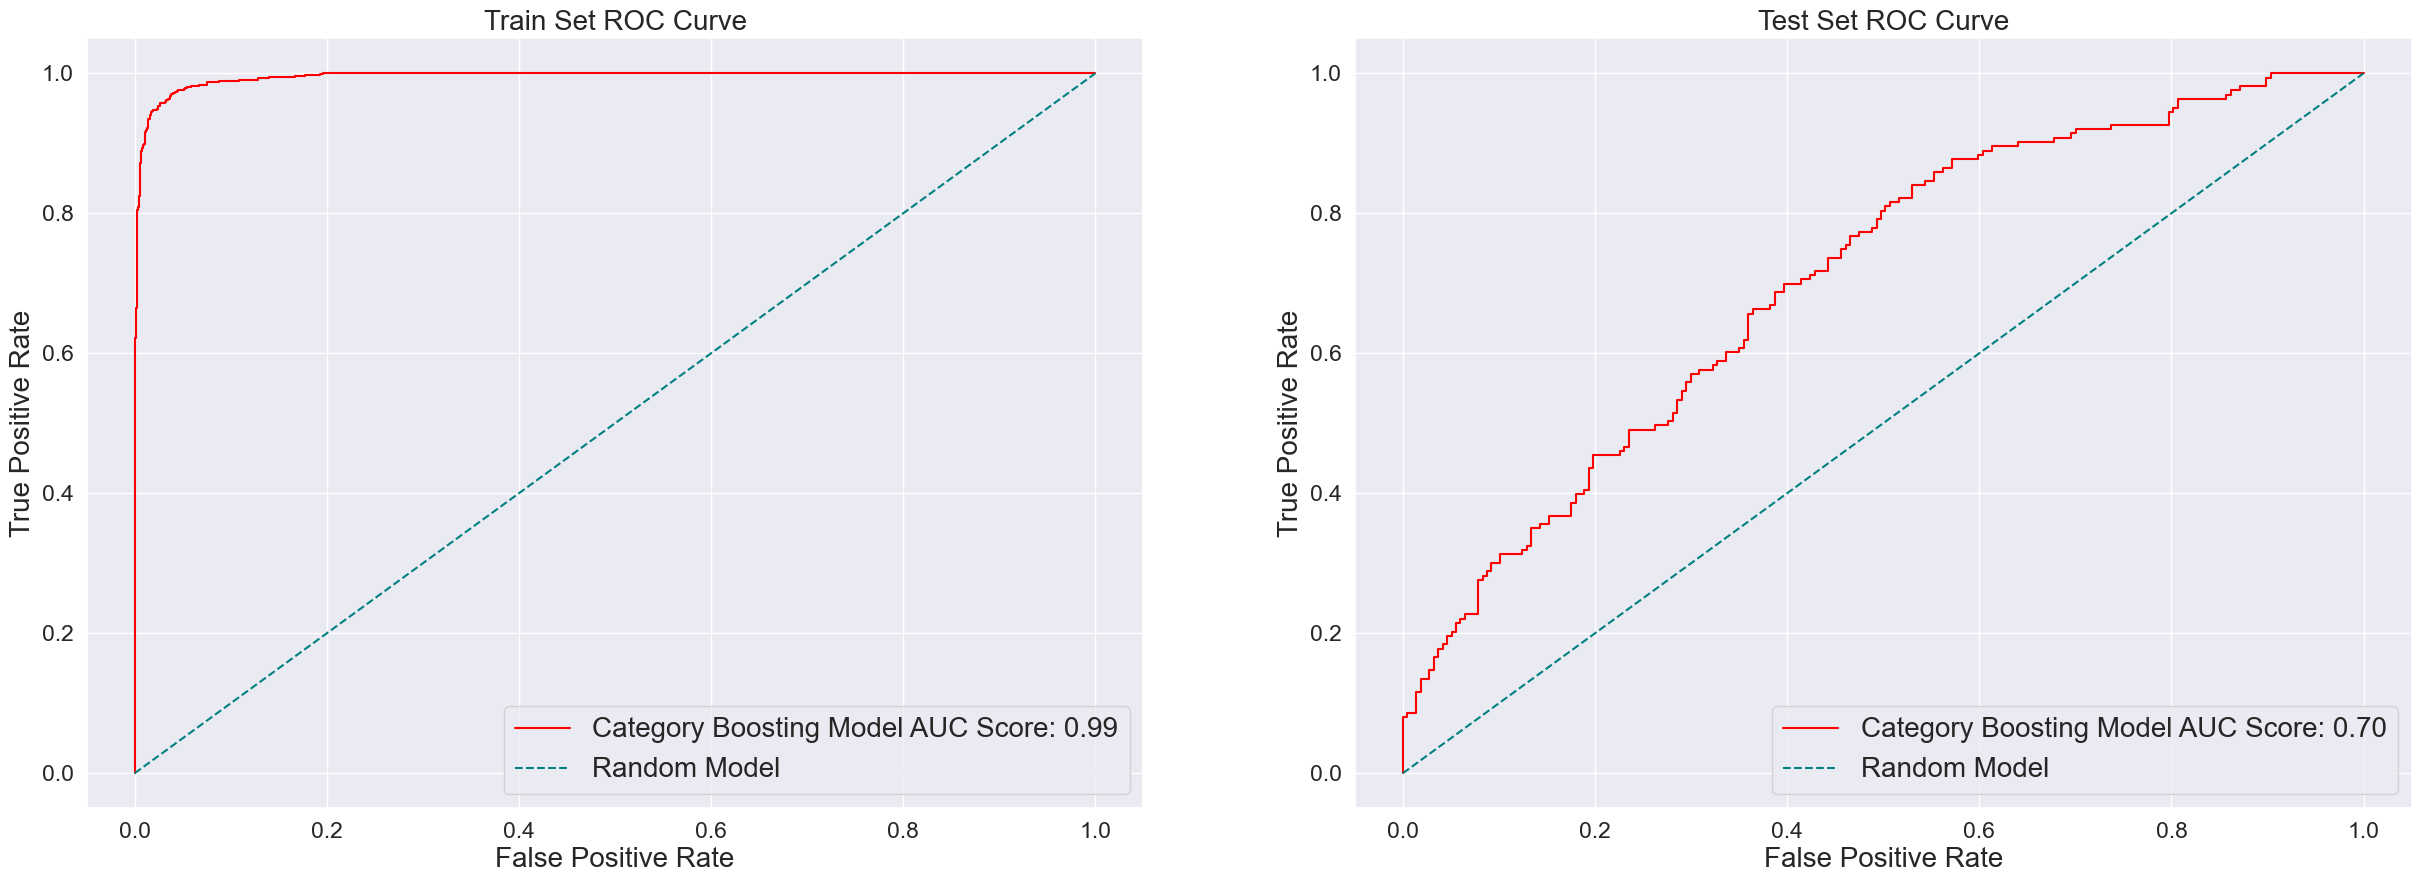

In [87]:
# Calling the function to plot ROC curve
plot_roc_curve(model = catb_model, 
               train_features = X_train, 
               train_labels = y_train, 
               test_features = X_test, 
               test_labels = y_test, 
               algorithm_name = 'Category Boosting')

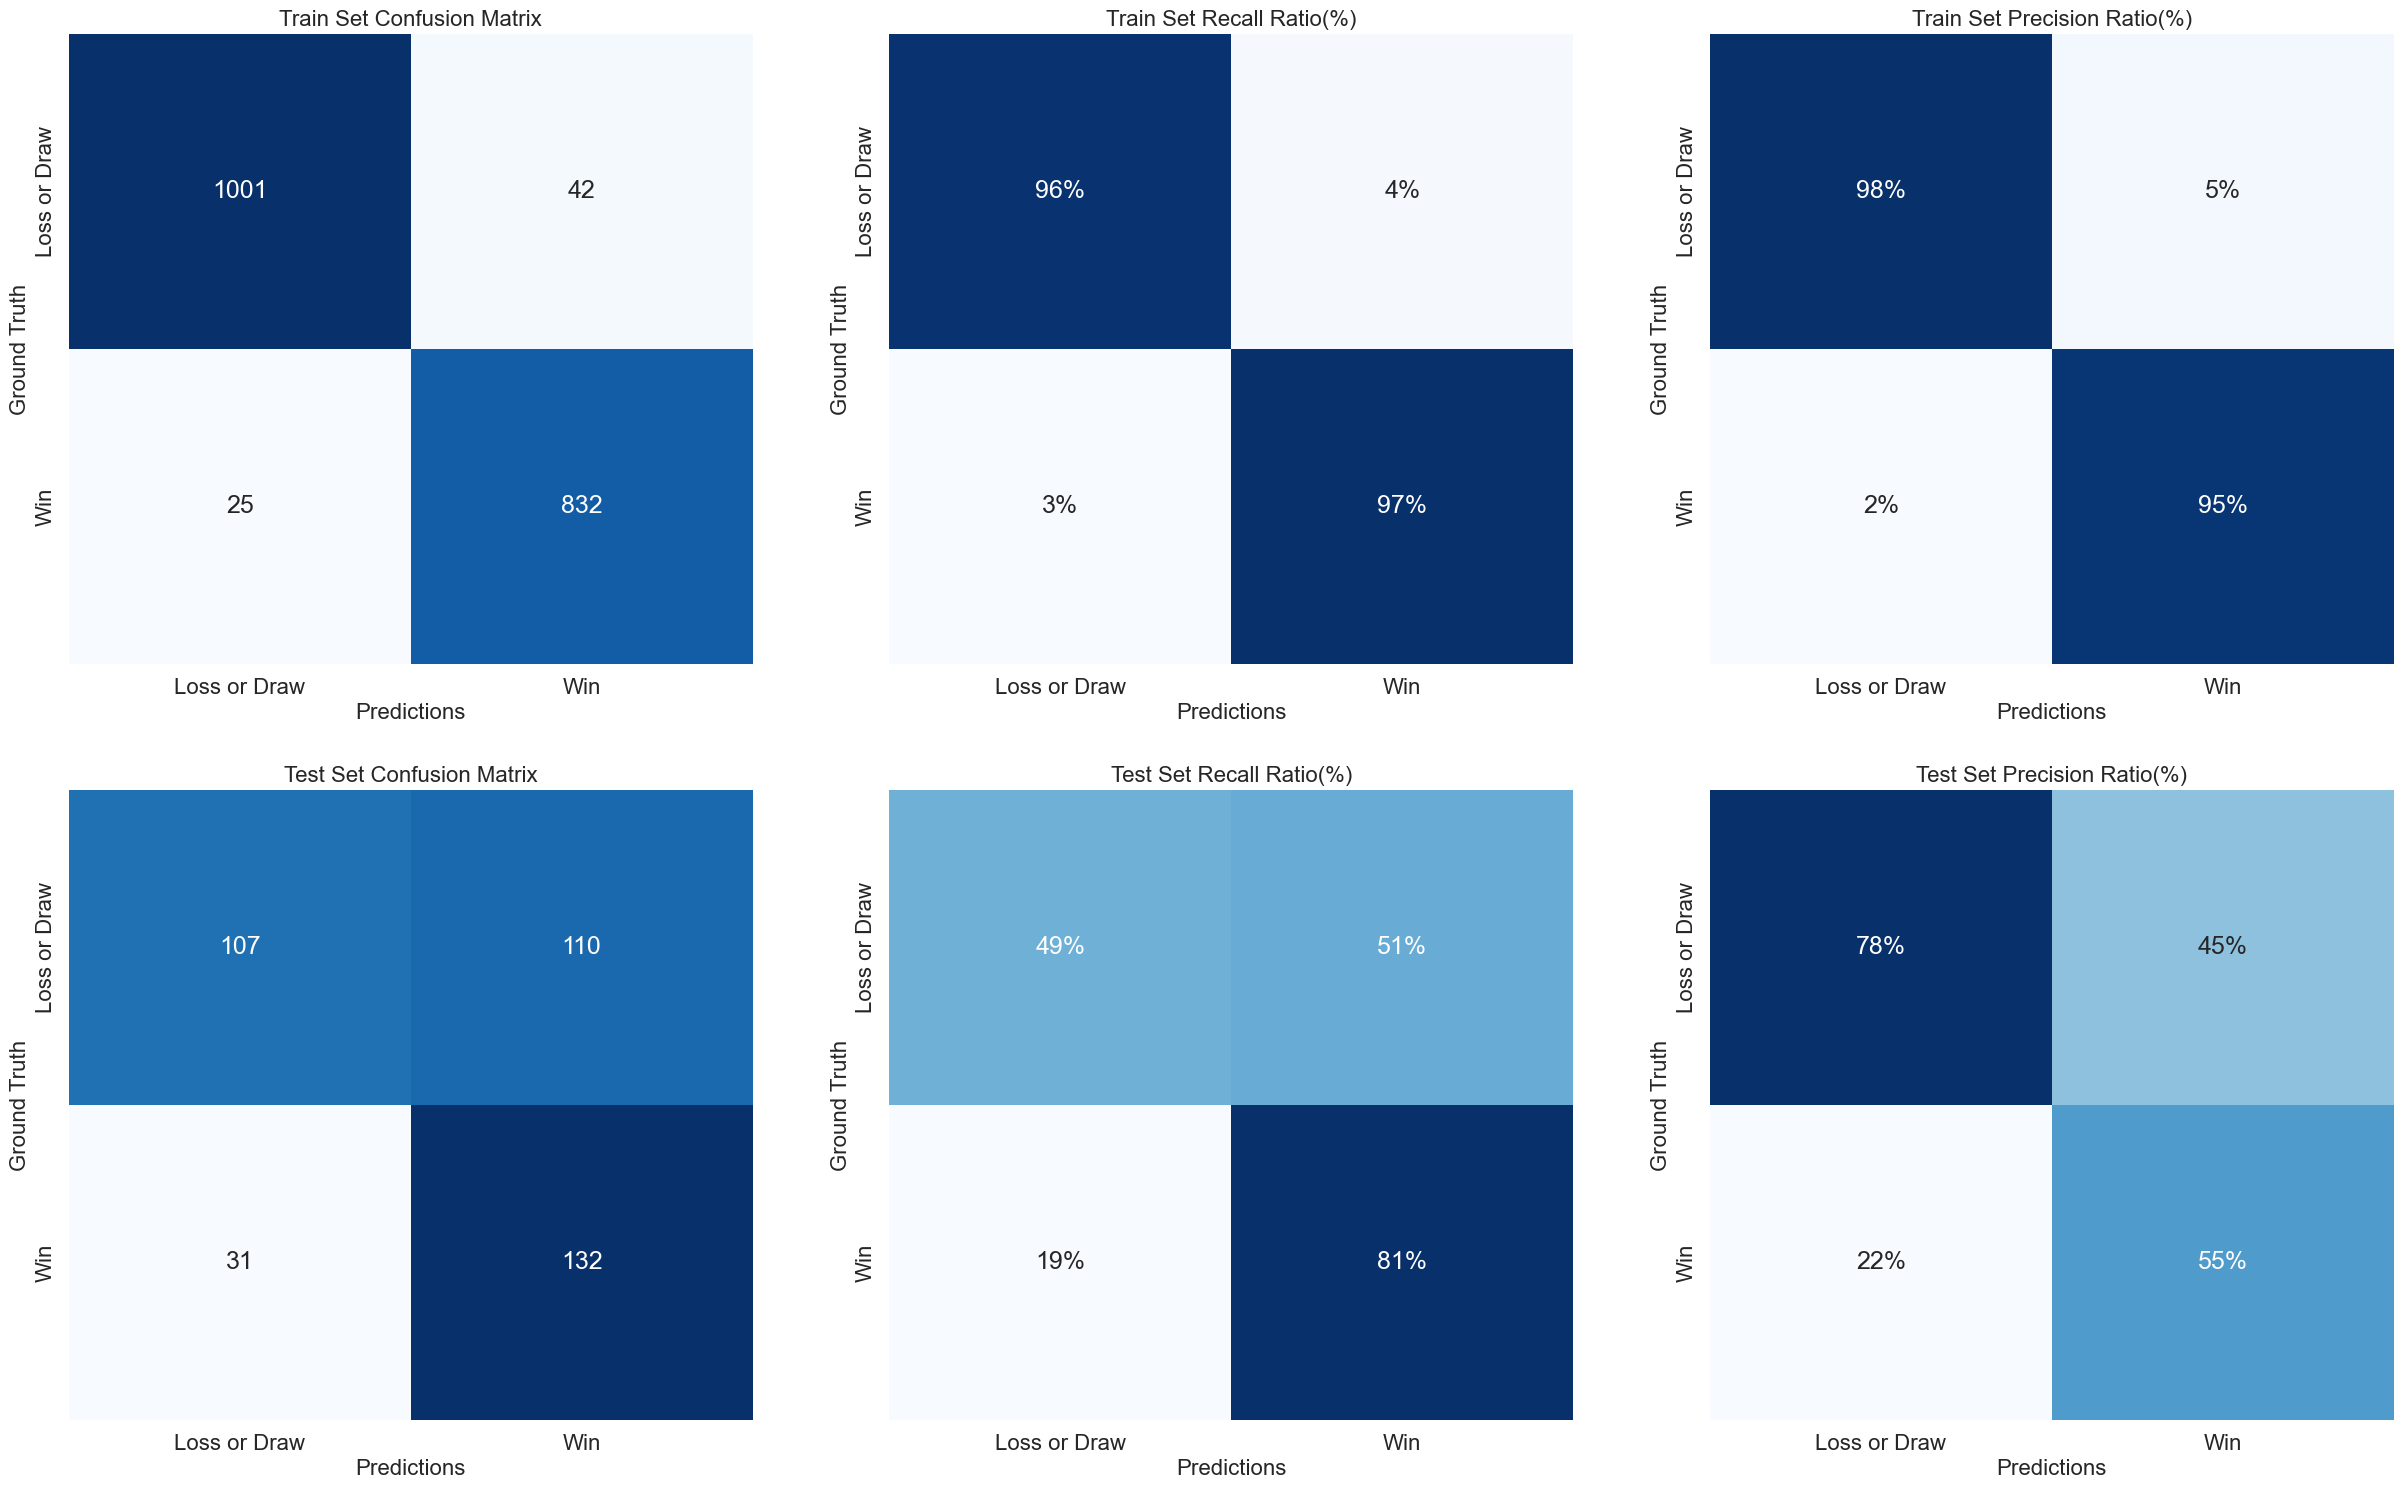

In [88]:
# Calling the function to plot confusion matrices, recall & precision ratio
plot_confusion_matrix(model = catb_model, 
                      train_features = X_train, 
                      train_labels = y_train, 
                      test_features = X_test, 
                      test_labels = y_test)

In [89]:
# Calling the function to evaluate the performance of the classifier
catb_model_summary_df = evaluate_model_performance(model = catb_model, 
                                                   train_features = X_train, 
                                                   train_labels = y_train, 
                                                   test_features = X_test, 
                                                   test_labels = y_test,
                                                   algorithm_name = 'Category Boosting')
catb_model_summary_df

Train Balanced Accuracy  Test Balanced Accuracy  Accuracy  \
Category Boosting                     0.97                    0.65      0.63   

                   Precision  Recall  F0.5  AUC  Brier Score Loss  \
Category Boosting       0.55    0.81  0.59  0.7              0.21   

                   Train Threshold  Test Threshold  
Category Boosting             0.44            0.34

***
### Model Selection

Let's concatenate the evaluation metrics summary for the models in a Pandas DataFrame.

In [90]:
# Concatenating the evaluation metrics summary for the models in a Pandas DataFrame
models_summary_df = pd.concat(objs = [gnb_model_summary_df, lr_model_summary_df, svm_model_summary_df, knn_model_summary_df, mlp_model_summary_df, dt_model_summary_df,
                                      rf_model_summary_df, lgbm_model_summary_df, ada_model_summary_df, gbm_model_summary_df, xgbm_model_summary_df, catb_model_summary_df])

# Sorting the models based on a specified metric in descending order 
models_summary_df.sort_values(by = ['Test Balanced Accuracy', 'Brier Score Loss'], ascending = [False, True], inplace = True)

# Saving the model selection summary for Win Modeling to a csv file
models_summary_df.to_csv(path_or_buf = '/Users/kzeynalzade/Documents/Project/Data/Summary/untuned_win_model_summary.csv', index_label = 'Algorithm')

# Displaying the model selection summary for Win Modeling
models_summary_df

Train Balanced Accuracy  \
Logistic Regression                                  0.66   
Support Vector Machine                               0.70   
Multi Layer Perceptron                               0.68   
Gaussian Naïve Bayes                                 0.65   
Category Boosting                                    0.97   
Gradient Boosted Machine                             0.84   
Extreme Gradient Boosted Machine                     0.99   
Random Forest                                        0.99   
Light Gradient Boosted Machine                       0.99   
Adaptive Boosting                                    0.73   
K Nearest Neighbors                                  0.75   
Decision Tree                                        1.00   

                                  Test Balanced Accuracy  Accuracy  Precision  \
Logistic Regression                                 0.67      0.67       0.61   
Support Vector Machine                              0.67      0.67       0.62   
Multi Layer Perceptron                              0.66      0.65       0.57   
Gaussian Naïve Bayes                                0.66      0.65       0.58   
Category Boosting                                   0.65      0.63       0.55   
Gradient Boosted Machine                            0.64      0.64       0.57   
Extreme Gradient Boosted Machine                    0.64      0.64       0.59   
Random Forest                                       0.63      0.65       0.61   
Light Gradient Boosted Machine                      0.63      0.61       0.53   
Adaptive Boosting                                   0.63      0.65       0.61   
K Nearest Neighbors                                 0.60      0.62       0.56   
Decision Tree                                       0.60      0.60       0.54   

                                  Recall  F0.5   AUC  Brier Score Loss  \
Logistic Regression                 0.63  0.61  0.72              0.21   
Support Vector Machine              0.64  0.62  0.71              0.21   
Multi Layer Perceptron              0.75  0.60  0.70              0.22   
Gaussian Naïve Bayes                0.69  0.60  0.70              0.34   
Category Boosting                   0.81  0.59  0.70              0.21   
Gradient Boosted Machine            0.63  0.58  0.69              0.22   
Extreme Gradient Boosted Machine    0.59  0.59  0.67              0.25   
Random Forest                       0.50  0.58  0.66              0.22   
Light Gradient Boosted Machine      0.79  0.57  0.66              0.24   
Adaptive Boosting                   0.52  0.59  0.68              0.24   
K Nearest Neighbors                 0.49  0.54  0.62              0.26   
Decision Tree                       0.56  0.54  0.60              0.40   

                                  Train Threshold  Test Threshold  
Logistic Regression                          0.46            0.45  
Support Vector Machine                       0.42            0.43  
Multi Layer Perceptron                       0.43            0.36  
Gaussian Naïve Bayes                         0.87            0.15  
Category Boosting                            0.44            0.34  
Gradient Boosted Machine                     0.42            0.39  
Extreme Gradient Boosted Machine             0.50            0.40  
Random Forest                                0.50            0.47  
Light Gradient Boosted Machine               0.37            0.25  
Adaptive Boosting                            0.50            0.50  
K Nearest Neighbors                          0.50            0.50  
Decision Tree                                0.10            0.50